In [1]:
state = 'MT'
root_name = 'Missoula'   # which county will root our district?
k = 2                    # number of districts

In [2]:
# Function to read graph from json file
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [3]:
# Read the county-level graph
filepath = 'C:\\districting-data-2020\\'
filename = state + '_county.json'

G = read_graph_from_json( filepath + filename )

for i in G.nodes:
    G.nodes[i]['TOTPOP'] = int( G.nodes[i]['P0010001'] )

In [4]:
import math

# Calculate lower and upper population limits
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k
L = math.floor( ideal_population )
U = math.ceil( ideal_population )
        
print("Using k =",k,"districts")
print("Lower population limit L =",L)
print("Upper population limit U =",U)

Using k = 2 districts
Lower population limit L = 542112
Upper population limit U = 542113


In [5]:
# Break symmetry by requiring a particular county be in the first district
for i in G.nodes:
    if G.nodes[i]['NAME20'] == root_name:
        root = i
        
print("Use",root_name,"County to root the first district. In our graph, this is vertex #",root)

Use Missoula County to root the first district. In our graph, this is vertex # 35


In [6]:
import networkx as nx

# Finds a minimal vertex subset that separates component from vertex b in digraph DG.
#
# This is algorithm 1 from Fischetti et al. 
#   "Thinning out Steiner trees: a node-based model for uniform edge costs." 
#   Mathematical Programming Computation 9.2 (2017): 203-229.
#
def find_minimal_separator(DG, component, b):
    neighbors_component = { i : False for i in DG.nodes }
    for i in nx.node_boundary(DG, component, None):
        neighbors_component[i] = True
    
    visited = { i : False for i in DG.nodes }
    child = [b]
    visited[b] = True
    
    while child:
        parent = child
        child = list()
        for i in parent:
            if not neighbors_component[i]:
                for j in DG.neighbors(i):
                    if not visited[j]:
                        child.append(j)
                        visited[j] = True
    
    C = [ i for i in DG.nodes if neighbors_component[i] and visited[i] ]
    return C

In [7]:
# Gurobi callback function, 
#   used to find/store the discovered districting plans 
#   or cut off infeasible (disconnected) solutions
def callback_function(m, where):

    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where != GRB.Callback.MIPSOL: 
        return
        
    # retrieve the LP solution
    xval = m.cbGetSolution(m._x)
    k = m._k
    DG = m._DG
    root = m._root
    
    district = [ i for i in DG.nodes if xval[i,0] > 0.5 ]
    assert nx.is_strongly_connected( DG.subgraph(district) )
    
    # is complement connected? if so, we may be able to build a plan from this district
    complement = [ i for i in DG.nodes if xval[i,1] > 0.5 ]
    if len(complement)==1 or nx.is_strongly_connected( DG.subgraph(complement) ):
        m._districts.append( district )
        m._number_of_districts += 1
        #print("found district #", m._number_of_districts, ":", district)
        print("#", m._number_of_districts)
        
        # force at least one vertex from complement must move to first_district. 
        # (this is generally not valid, but with 1-person deviation it will only cut off 
        #   this particular solution as all counties have nontrivial population)
        m.cbLazy( gp.quicksum( m._x[i,0] for i in complement ) >= 1 )

        # hack to exit when enumeration_limit has been reached
        if m._number_of_districts == m._enumeration_limit:
            print("Enumeration limit has been reached. Exiting search.")
            m.cbLazy( m._x[root,1] >= 1 )
        
    # if second district is disconnected, then add a violated a,b-separator inequality
    else:
        assert k==2
        # find a maximum population component
        b = None
        max_component_population = -1
        for component in nx.strongly_connected_components( DG.subgraph(complement) ):
            component_population = sum( DG.nodes[i]['TOTPOP'] for i in component )
            if component_population > max_component_population:

                # find a maximum population vertex 'b' from this component
                max_component_population = component_population
                max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
                max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
                b = max_population_vertices[0]

        # each other component (besides b's), find some vertex 'a' and add cut.
        for component in nx.strongly_connected_components( DG.subgraph(complement) ):
            if b in component:
                continue

            # find a maximum population vertex 'a' from this component
            max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
            max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
            a = max_population_vertices[0]

            # add a,b-separator inequality
            C = find_minimal_separator(DG, component, b)
            m.cbLazy( m._x[a,1] + m._x[b,1] <= 1 + gp.quicksum( m._x[c,1] for c in C ) )

In [8]:
# Need a gurobi license to solve this model
import gurobipy as gp
from gurobipy import GRB

# build model
m = gp.Model()

# x[i,j]=1 if vertex i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# each vertex is assigned to one district
m.addConstrs( x[i,0] + x[i,1] == 1 for i in G.nodes )

# add population balance constraints for district and its complement
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,0] for i in G.nodes ) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,0] for i in G.nodes ) <= U )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,1] for i in G.nodes ) >= (k-1)*L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,1] for i in G.nodes ) <= (k-1)*U )

# symmetry breaking: fix root to be in first district
x[root,0].LB = 1

M = G.number_of_nodes() - 1
DG = nx.DiGraph(G)

# add flow-based contiguity constraints (Shirabe) for first district
f = m.addVars(DG.edges)
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) == x[i,0] for i in G.nodes if i != root )
m.addConstrs( gp.quicksum( f[j,i] for j in G.neighbors(i) ) <= M * x[i,0] for i in G.nodes if i != root )
m.addConstr( gp.quicksum( f[j,root] for j in G.neighbors(root) ) == 0 )

# add compactness objective (to guide the search): a transportation objective for first district
dist = nx.shortest_path_length(G, source=root)
m.setObjective( gp.quicksum( dist[i] * dist[i] * math.ceil(G.nodes[i]['TOTPOP']/1000) * x[i,0] for i in G.nodes ), GRB.MINIMIZE )

Academic license - for non-commercial use only - expires 2024-08-18
Using license file C:\Users\sezazip\gurobi.lic


In [9]:
# add cut-based contiguity constraints for second district (whose root we do not know a priori)
m.Params.LazyConstraints = 1
m._callback = callback_function

# additional bookkeeping 
m._x = x                    # assignment variables
m._k = k
m._L = L
m._U = U
m._DG = DG                  # directed graph
m._root = root              # root of the district
m._enumeration_limit = 10001# terminate the search after this many solutions have been found
m._districts = list()       # store districts here
m._number_of_districts = 0  # count the districts

# MIP tolerances
m.Params.IntFeasTol = 1e-7
m.Params.FeasibilityTol = 1e-7

# solve
m.optimize( m._callback )

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter IntFeasTol to 1e-07
   Prev: 1e-05  Min: 1e-09  Max: 0.1  Default: 1e-05
Changed value of parameter FeasibilityTol to 1e-07
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 171 rows, 388 columns and 1260 nonzeros
Model fingerprint: 0x9c6e796a
Variable types: 276 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+00, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 59 rows and 64 columns
Presolve time: 0.01s
Presolved: 112 rows, 324 columns, 1019 nonzeros
Variable types: 269 continuous, 55 integer (55 binary)

Root relaxation: objective 1.444366e+03, 15 iterations, 0.00 seconds

    Nodes    |    Current Node

# 255
 2949392 980211 2182.63647   45    1          - 2182.63647      -   7.0  220s
 2979876 980341 4685.98837   47    2          - 2182.63647      -   7.1  225s
# 256
# 257
 3009900 979993 2182.63647   45    3          - 2182.63647      -   7.1  230s
# 258
# 259
 3036486 979238 infeasible   41               - 2182.63647      -   7.1  235s
# 260
# 261
 3066484 978551 2417.66983   49    1          - 2182.63647      -   7.1  240s
# 262
# 263
 3095408 977790 4204.69172   51    5          - 2182.63647      -   7.1  245s
# 264
 3121706 976422 5000.23659   47    3          - 2182.63647      -   7.1  250s
# 265
# 266
 3149118 974976 infeasible   53               - 2182.63647      -   7.1  255s
# 267
 3175426 973881 2182.63647   45    1          - 2182.63647      -   7.2  260s
# 268
# 269
# 270
 3202499 972578 2182.63647   48    1          - 2182.63647      -   7.2  265s
# 271
# 272
# 273
 3228608 971719 2182.63647   48    1          - 2182.63647      -   7.2  270s
# 274
# 275
 3254272 970656 

# 647
# 648
# 649
# 650
# 651
# 652
# 653
# 654
# 655
# 656
# 657
 4789377 799242 5272.67236   55    1          - 2335.01790      -   7.5  595s
# 658
# 659
# 660
 4808739 796271 9469.23275   52    4          - 2338.55442      -   7.5  600s
# 661
# 662
# 663
# 664
# 665
# 666
# 667
# 668
# 669
# 670
# 671
 4829283 793064 infeasible   54               - 2342.17023      -   7.5  605s
# 672
# 673
# 674
# 675
# 676
# 677
# 678
# 679
# 680
# 681
# 682
# 683
# 684
# 685
 4849653 789903 2430.98988   55    4          - 2345.60911      -   7.5  610s
# 686
# 687
# 688
# 689
# 690
# 691
# 692
 4869551 786647 3900.16992   48    3          - 2349.26443      -   7.5  615s
# 693
# 694
# 695
# 696
# 697
# 698
# 699
# 700
# 701
# 702
# 703
 4889782 783617 infeasible   52               - 2352.74822      -   7.5  620s
# 704
# 705
# 706
# 707
# 708
 4910776 780072 8579.55732   50    5          - 2356.57897      -   7.5  625s
# 709
# 710
# 711
# 712
 4929882 776893 2386.82591   54    1          - 2359.99430

# 1061
# 1062
 5866582 662113 infeasible   54               - 2511.23288      -   7.5  960s
# 1063
# 1064
# 1065
# 1066
# 1067
# 1068
# 1069
# 1070
 5876228 663540 infeasible   53               - 2512.83781      -   7.5  965s
# 1071
# 1072
# 1073
# 1074
# 1075
# 1076
 5885803 664983 4195.35568   50    3          - 2514.17875      -   7.5  970s
# 1077
# 1078
# 1079
# 1080
# 1081
 5893768 666076 2527.49058   42    1          - 2515.38403      -   7.5  975s
# 1082
 5903235 667452 2606.10038   46    3          - 2516.77130      -   7.5  980s
# 1083
# 1084
# 1085
# 1086
# 1087
 5912611 668828 3221.39081   51    7          - 2518.11501      -   7.5  985s
# 1088
# 1089
 5923660 670274 2563.67755   47    2          - 2519.76860      -   7.5  990s
# 1090
 5933002 671706 infeasible   53               - 2521.24105      -   7.5  995s
# 1091
# 1092
# 1093
# 1094
 5942141 673193 3527.63805   45    6          - 2522.64802      -   7.5 1000s
# 1095
# 1096
# 1097
# 1098
 5951859 674486 4398.73754   55 

# 1301
# 1302
# 1303
 6512833 751706 infeasible   54               - 2602.38189      -   7.4 1380s
# 1304
# 1305
# 1306
 6519129 752500 infeasible   55               - 2603.22393      -   7.4 1386s
# 1307
 6526170 753400 infeasible   47               - 2604.11883      -   7.4 1391s
# 1308
 6530826 753933 3162.55189   56    2          - 2604.73753      -   7.4 1395s
# 1309
 6538999 754811 2814.44832   59    1          - 2605.87122      -   7.4 1401s
 6543968 755541 3025.33735   51    3          - 2606.50155      -   7.4 1405s
# 1310
 6550197 756409 3297.07049   47    3          - 2607.26732      -   7.4 1410s
# 1311
# 1312
 6556333 757130 3368.28045   57    1          - 2608.15686      -   7.4 1416s
# 1313
 6562742 757999 2984.11336   51    1          - 2608.86755      -   7.4 1420s
# 1314
# 1315
# 1316
# 1317
# 1318
 6569235 758717 2623.64901   52    1          - 2609.93890      -   7.4 1426s
# 1319
 6574123 759321 infeasible   57               - 2610.55570      -   7.4 1430s
# 1320
# 

# 1482
# 1483
# 1484
# 1485
 6984848 807721 2709.98850   56    3          - 2665.55598      -   7.4 1825s
 6991065 808446 infeasible   53               - 2666.38121      -   7.4 1830s
# 1486
# 1487
 6995698 809038 infeasible   45               - 2667.02436      -   7.4 1835s
# 1488
# 1489
 7000504 809675 infeasible   58               - 2667.58095      -   7.4 1840s
# 1490
 7007030 810477 2936.25189   49    4          - 2668.34775      -   7.4 1846s
# 1491
# 1492
# 1493
 7011919 811009 5041.21325   48    6          - 2668.98740      -   7.4 1850s
# 1494
# 1495
 7016349 811540 4796.26969   57    2          - 2669.50438      -   7.4 1856s
# 1496
# 1497
# 1498
 7021161 812126 3149.50919   58    1          - 2670.23140      -   7.4 1861s
# 1499
# 1500
# 1501
 7026047 812521 infeasible   50               - 2670.86973      -   7.4 1866s
# 1502
# 1503
# 1504
 7030615 813117 4554.90243   51    5          - 2671.32854      -   7.4 1871s
# 1505
# 1506
 7035445 813637 3058.10183   52    3         

# 1668
# 1669
# 1670
 7407476 853937 infeasible   54               - 2720.45277      -   7.3 2270s
# 1671
# 1672
# 1673
 7413506 854679 2722.65918   51    4          - 2721.26038      -   7.3 2276s
# 1674
# 1675
# 1676
 7418219 855191 2745.60527   47    3          - 2721.70426      -   7.3 2280s
# 1677
 7423968 855781 2746.82996   53    1          - 2722.54436      -   7.3 2285s
# 1678
# 1679
# 1680
 7430608 856498 infeasible   48               - 2723.39631      -   7.3 2290s
# 1681
 7434856 857075 3098.56094   47    3          - 2724.03947      -   7.3 2295s
# 1682
# 1683
 7440961 857810 3201.37967   45    4          - 2724.84252      -   7.3 2300s
# 1684
# 1685
# 1686
 7446761 858608 3140.75731   52    5          - 2725.46281      -   7.3 2306s
# 1687
# 1688
# 1689
 7453135 859341 3088.39167   51    6          - 2726.14148      -   7.3 2311s
# 1690
# 1691
# 1692
# 1693
 7457951 860047 2955.96947   48    7          - 2726.86136      -   7.3 2315s
# 1694
# 1695
 7464353 860876 infeasib

# 1889
# 1890
# 1891
 7883506 910559 infeasible   54               - 2779.21411      -   7.3 2700s
# 1892
# 1893
 7889451 911043 10797.7742   53    2          - 2780.00087      -   7.3 2705s
# 1894
# 1895
 7895337 911839 infeasible   50               - 2780.80084      -   7.3 2710s
# 1896
# 1897
 7901183 912483 3448.56275   57    1          - 2781.44363      -   7.3 2716s
# 1898
 7905630 912928 infeasible   58               - 2781.99875      -   7.3 2720s
# 1899
 7911492 913526 2783.86144   53    2          - 2782.67254      -   7.3 2725s
# 1900
# 1901
# 1902
# 1903
# 1904
# 1905
# 1906
# 1907
 7917514 914263 9802.71413   58    5          - 2783.39576      -   7.3 2730s
 7923471 915140 infeasible   46               - 2784.02729      -   7.3 2735s
# 1908
 7929481 915787 3159.83780   53    2          - 2784.75612      -   7.3 2740s
# 1909
 7935416 916544 infeasible   54               - 2785.38112      -   7.3 2746s
# 1910
# 1911
# 1912
# 1913
 7939563 917010 3061.59974   54    1         

# 2096
# 2097
# 2098
 8337363 962093 2865.64436   52    1          - 2831.34899      -   7.2 3135s
# 2099
# 2100
# 2101
# 2102
 8341808 962606 infeasible   51               - 2831.86846      -   7.2 3140s
# 2103
# 2104
 8346465 963135 infeasible   50               - 2832.37843      -   7.2 3145s
# 2105
# 2106
 8352138 963777 3213.07168   57    1          - 2833.03325      -   7.2 3150s
# 2107
# 2108
 8356670 964286 3611.51340   48   13          - 2833.54745      -   7.2 3155s
# 2109
 8362562 964836 2845.00244   54    1          - 2834.27206      -   7.2 3160s
# 2110
# 2111
 8366949 965380 2846.03836   58    1          - 2834.79584      -   7.2 3165s
# 2112
# 2113
# 2114
 8372671 966091 3056.62262   51    1          - 2835.39694      -   7.2 3170s
# 2115
 8376823 966630 3156.58158   46    1          - 2835.91829      -   7.2 3175s
# 2116
 8382649 967253 3700.82205   51    4          - 2836.58818      -   7.2 3180s
# 2117
# 2118
# 2119
# 2120
# 2121
 8388522 967889 infeasible   54       

# 2281
# 2282
# 2283
# 2284
# 2285
# 2286
 8753747 1008796 4716.87095   59    3          - 2878.41658      -   7.2 3581s
 8757854 1009160 3170.49075   46    2          - 2878.91314      -   7.2 3585s
# 2287
 8762393 1009621 infeasible   61               - 2879.49022      -   7.2 3590s
# 2288
 8766698 1010116 2977.41109   54    1          - 2879.93570      -   7.2 3595s
# 2289
# 2290
 8771195 1010599 3208.35943   50    2          - 2880.39438      -   7.2 3601s
# 2291
# 2292
 8775792 1011149 infeasible   51               - 2880.85789      -   7.2 3606s
# 2293
 8780163 1011671 2917.94298   49    3          - 2881.35461      -   7.2 3611s
# 2294
# 2295
# 2296
# 2297
 8784117 1012082 infeasible   43               - 2881.88583      -   7.2 3616s
# 2298
 8786829 1012364 infeasible   52               - 2882.13390      -   7.2 3620s
# 2299
 8791446 1012813 3066.10795   43    3          - 2882.62730      -   7.2 3625s
 8796059 1013223 4175.28859   55    1          - 2883.12752      -   7.2 3630

# 2425
 9128794 1050224 3100.86564   44    7          - 2918.69016      -   7.2 4035s
# 2426
# 2427
# 2428
 9132739 1050638 3064.31202   54    1          - 2919.12589      -   7.2 4040s
# 2429
# 2430
# 2431
 9137010 1051164 3001.42831   45    4          - 2919.63713      -   7.2 4046s
# 2432
 9141192 1051567 2920.91543   50    1          - 2920.05167      -   7.2 4051s
# 2433
# 2434
# 2435
 9145812 1052142 infeasible   55               - 2920.46482      -   7.2 4056s
 9148602 1052484 infeasible   60               - 2920.77008      -   7.2 4060s
# 2436
# 2437
# 2438
# 2439
# 2440
 9153325 1052988 4796.58779   54    1          - 2921.24238      -   7.2 4066s
 9157247 1053482 infeasible   56               - 2921.68322      -   7.2 4071s
# 2441
 9160240 1053831 infeasible   53               - 2921.93417      -   7.2 4075s
 9164165 1054310 4391.33352   48    2          - 2922.44403      -   7.2 4080s
 9168502 1054790 2926.47295   54    1          - 2922.89912      -   7.2 4085s
# 2442
# 244

# 2569
 9466384 1090235 infeasible   57               - 2952.79842      -   7.1 4490s
# 2570
 9470604 1090744 3217.90289   57    1          - 2953.21612      -   7.1 4496s
# 2571
 9473413 1091131 infeasible   60               - 2953.52034      -   7.1 4500s
# 2572
# 2573
 9477924 1091597 infeasible   55               - 2953.95049      -   7.1 4506s
# 2574
 9480805 1091953 infeasible   52               - 2954.19835      -   7.1 4510s
 9485112 1092483 3584.27255   59    1          - 2954.65976      -   7.1 4515s
# 2575
# 2576
 9487931 1092788 8608.33744   58    1          - 2954.92027      -   7.1 4520s
# 2577
 9492377 1093453 4547.82097   57    1          - 2955.35166      -   7.1 4526s
# 2578
 9495340 1093882 2986.55466   51    1          - 2955.59920      -   7.1 4530s
# 2579
# 2580
# 2581
 9499706 1094334 3797.04333   51    2          - 2956.12346      -   7.1 4535s
# 2582
# 2583
 9504021 1094823 4623.32763   50    8          - 2956.46250      -   7.1 4541s
# 2584
 9506820 1095312 in

# 2705
 9777426 1125242 4304.77494   50    1          - 2983.08808      -   7.1 4952s
# 2706
# 2707
# 2708
# 2709
 9780590 1125555 3109.93302   46    3          - 2983.38131      -   7.1 4956s
 9783304 1125814 infeasible   55               - 2983.68382      -   7.1 4960s
# 2710
# 2711
 9787397 1126222 3475.57014   48    5          - 2984.02645      -   7.1 4966s
# 2712
 9790292 1126534 3117.95983   54    2          - 2984.28407      -   7.1 4970s
# 2713
# 2714
 9793026 1126850 4261.15769   48    4          - 2984.62761      -   7.1 4975s
 9797405 1127287 3057.20218   57    1          - 2985.06073      -   7.1 4981s
 9800027 1127696 3207.31202   53    1          - 2985.31911      -   7.1 4985s
# 2715
 9804502 1128188 infeasible   54               - 2985.72902      -   7.1 4991s
 9807532 1128411 3201.62708   51    1          - 2986.04833      -   7.1 4996s
# 2716
 9810420 1128742 infeasible   47               - 2986.30808      -   7.1 5000s
# 2717
 9813052 1128963 infeasible   60        

# 2824
# 2825
# 2826
# 2827
 10065270 1156920 3374.03015   51    1          - 3009.99552      -   7.1 5416s
 10066680 1157057 3691.04466   50    3          - 3010.12397      -   7.1 5420s
# 2828
 10069622 1157255 infeasible   49               - 3010.46072      -   7.1 5425s
# 2829
# 2830
# 2831
 10074235 1157657 3244.77096   51    1          - 3010.87248      -   7.1 5432s
# 2832
 10075849 1157819 infeasible   56               - 3011.03753      -   7.1 5435s
# 2833
 10079896 1158269 3147.64452   56    1          - 3011.40752      -   7.1 5441s
# 2834
 10082755 1158587 infeasible   48               - 3011.67681      -   7.1 5446s
 10085532 1158845 3980.81935   51    5          - 3011.96987      -   7.1 5450s
# 2835
# 2836
# 2837
 10088418 1159081 4043.44231   55    7          - 3012.17151      -   7.1 5455s
# 2838
 10091258 1159504 4810.13043   62    1          - 3012.51407      -   7.1 5460s
# 2839
 10095559 1160103 4364.14840   54    5          - 3012.82738      -   7.1 5467s
# 2840
#

 10334493 1184951 3111.38619   53    1          - 3034.83681      -   7.1 5877s
# 2951
 10337321 1185169 infeasible   49               - 3035.00896      -   7.1 5882s
# 2952
 10340172 1185467 4164.78556   57    3          - 3035.33333      -   7.1 5887s
 10343154 1185693 infeasible   49               - 3035.67915      -   7.1 5891s
# 2953
 10345889 1186040 infeasible   52               - 3035.83695      -   7.1 5896s
# 2954
 10348533 1186322 3121.95423   52    3          - 3036.11373      -   7.1 5901s
# 2955
 10351235 1186557 infeasible   53               - 3036.36966      -   7.1 5906s
# 2956
# 2957
 10354331 1186816 3037.39980   49    1          - 3036.66935      -   7.1 5911s
# 2958
 10357150 1187127 5124.05443   58    1          - 3036.92938      -   7.1 5916s
 10360126 1187430 3238.83333   54    1          - 3037.20363      -   7.1 5920s
# 2959
# 2960
 10362898 1187746 infeasible   55               - 3037.42118      -   7.1 5925s
 10365441 1187989 3286.70512   50    5          - 

# 3059
 10588881 1211755 infeasible   48               - 3057.32991      -   7.1 6341s
# 3060
# 3061
 10591557 1212019 infeasible   56               - 3057.59981      -   7.1 6346s
 10593970 1212270 4187.93960   57    1          - 3057.83684      -   7.1 6351s
# 3062
 10597142 1212600 3724.42648   48    5          - 3058.10071      -   7.1 6356s
# 3063
# 3064
 10599939 1212787 3088.32699   51    4          - 3058.40774      -   7.1 6362s
# 3065
 10601419 1212968 infeasible   53               - 3058.54234      -   7.1 6365s
# 3066
 10604283 1213365 infeasible   58               - 3058.80447      -   7.1 6370s
# 3067
 10606950 1213604 4406.04097   52    4          - 3058.98196      -   7.1 6376s
# 3068
# 3069
 10609932 1213949 infeasible   57               - 3059.20110      -   7.1 6382s
# 3070
 10612683 1214178 6301.17409   51    1          - 3059.47599      -   7.1 6387s
# 3071
 10614133 1214317 5262.04559   55    3          - 3059.56256      -   7.1 6391s
# 3072
 10617539 1214601 5115

 10832539 1235873 3157.72426   61    1          - 3079.64355      -   7.1 6810s
# 3156
 10835408 1236251 4279.62284   56    3          - 3079.88288      -   7.1 6816s
# 3157
 10838429 1236486 5517.36315   54    1          - 3080.20695      -   7.1 6822s
 10839914 1236670 3081.49099   53    3          - 3080.33004      -   7.1 6825s
# 3158
 10842906 1236890 3161.49735   52    1          - 3080.53154      -   7.1 6830s
 10845774 1237191 3192.18635   57    1          - 3080.83463      -   7.1 6836s
 10848944 1237515 4298.41265   51    3          - 3081.09675      -   7.1 6842s
 10850498 1237718 infeasible   52               - 3081.19507      -   7.1 6845s
# 3159
# 3160
 10853571 1237959 infeasible   58               - 3081.43570      -   7.1 6850s
# 3161
 10856220 1238240 3867.49637   51    3          - 3081.72617      -   7.1 6856s
# 3162
 10858927 1238515 3191.49872   52    1          - 3081.93622      -   7.1 6861s
# 3163
 10860324 1238631 3260.11983   55    1          - 3082.06711    

# 3249
 11062248 1259164 infeasible   53               - 3100.05402      -   7.1 7286s
# 3250
# 3251
 11064974 1259454 3266.68635   55    1          - 3100.33978      -   7.1 7292s
# 3252
# 3253
 11066471 1259593 3713.46691   53    1          - 3100.41879      -   7.1 7295s
# 3254
# 3255
 11069372 1259866 3399.22292   56    1          - 3100.76203      -   7.1 7301s
# 3256
# 3257
 11072168 1260103 infeasible   53               - 3101.01411      -   7.1 7306s
 11075183 1260309 4252.47025   51    4          - 3101.25394      -   7.1 7312s
# 3258
 11076688 1260417 infeasible   54               - 3101.39156      -   7.1 7315s
# 3259
 11079372 1260678 3161.11179   45    1          - 3101.66203      -   7.1 7320s
 11082131 1260977 5210.99204   53    5          - 3101.89721      -   7.1 7326s
 11084758 1261199 9829.83122   55    4          - 3102.06294      -   7.1 7331s
# 3260
 11086066 1261349 3660.61099   47    1          - 3102.23171      -   7.1 7335s
 11089553 1261636 4237.86607   59   

 11285712 1280568 infeasible   56               - 3119.86693      -   7.0 7760s
# 3335
 11288320 1280835 infeasible   51               - 3120.10067      -   7.0 7766s
# 3336
 11291221 1281047 3161.14211   49    3          - 3120.35361      -   7.0 7773s
# 3337
 11292607 1281120 4257.03378   64    2          - 3120.49440      -   7.0 7776s
 11293998 1281286 4342.94740   56    7          - 3120.65784      -   7.0 7780s
# 3338
# 3339
# 3340
 11296885 1281488 infeasible   60               - 3120.86057      -   7.0 7787s
 11298150 1281604 3567.76726   56    1          - 3121.01566      -   7.0 7790s
# 3341
 11300968 1281865 3672.34783   54    1          - 3121.26103      -   7.0 7798s
 11302212 1282016 3140.98839   48    2          - 3121.36201      -   7.0 7800s
# 3342
 11305060 1282281 3834.20043   51    3          - 3121.63607      -   7.0 7806s
 11307960 1282502 3122.61680   52    1          - 3121.91075      -   7.0 7813s
# 3343
 11309310 1282613 infeasible   51               - 3122.00

# 3416
 11499243 1300856 4404.86263   49    4          - 3138.43601      -   7.0 8240s
 11502008 1301149 4389.22849   50    3          - 3138.82897      -   7.0 8246s
# 3417
# 3418
# 3419
 11504729 1301406 infeasible   58               - 3139.03556      -   7.0 8252s
 11506202 1301531 3222.00163   55    1          - 3139.21745      -   7.0 8255s
 11508982 1301808 4529.24827   57    7          - 3139.46913      -   7.0 8260s
# 3420
 11512089 1302158 3195.77953   58    1          - 3139.72918      -   7.0 8266s
 11515005 1302358 3858.01348   53    1          - 3139.98860      -   7.0 8272s
# 3421
 11516478 1302526 infeasible   49               - 3140.07939      -   7.0 8275s
# 3422
# 3423
 11519017 1302887 infeasible   52               - 3140.37957      -   7.0 8282s
 11520396 1302981 3162.65108   50    6          - 3140.46292      -   7.0 8285s
# 3424
 11523174 1303238 infeasible   37               - 3140.66273      -   7.0 8292s
 11524511 1303332 3545.02046   52    1          - 3140.75

 11707477 1320636 infeasible   57               - 3156.46598      -   7.0 8717s
 11708950 1320741 3924.23845   46    4          - 3156.62783      -   7.0 8720s
 11711477 1320972 3469.30490   56    3          - 3156.79386      -   7.0 8725s
 11712740 1321026 4696.85566   53    6          - 3156.93830      -   7.0 8730s
# 3501
 11715521 1321301 infeasible   46               - 3157.14469      -   7.0 8736s
 11717976 1321578 3552.32338   53    2          - 3157.35950      -   7.0 8741s
# 3502
 11720661 1321836 infeasible   51               - 3157.61337      -   7.0 8748s
# 3503
 11721969 1321989 3201.58735   51    5          - 3157.72177      -   7.0 8751s
# 3504
# 3505
 11723403 1322172 infeasible   51               - 3157.84276      -   7.0 8755s
 11726223 1322463 3716.89256   60    1          - 3158.10442      -   7.0 8761s
# 3506
 11727676 1322576 infeasible   54               - 3158.25258      -   7.0 8766s
# 3507
 11730462 1322880 3212.93606   56    1          - 3158.48420      -   7

# 3582
# 3583
 11908894 1339447 infeasible   60               - 3173.54355      -   7.0 9197s
# 3584
 11910326 1339524 4191.44369   56    1          - 3173.66606      -   7.0 9200s
# 3585
# 3586
 11913146 1339836 3264.97319   48    4          - 3173.98416      -   7.0 9209s
 11914278 1339918 4774.67964   59    1          - 3174.00745      -   7.0 9212s
 11915620 1340026 infeasible   50               - 3174.13180      -   7.0 9215s
# 3587
 11918299 1340313 4360.76761   54    1          - 3174.40113      -   7.0 9221s
 11919713 1340488 4609.57947   49    2          - 3174.51347      -   7.0 9225s
# 3588
 11922386 1340633 4408.86443   57    1          - 3174.74337      -   7.0 9231s
 11923859 1340692 3895.37897   57    5          - 3174.89627      -   7.0 9235s
# 3589
 11926554 1340903 infeasible   57               - 3175.10931      -   7.0 9242s
 11927995 1341053 infeasible   55               - 3175.29668      -   7.0 9245s
# 3590
 11930975 1341335 infeasible   58               - 3175.55

# 3650
 12101321 1357040 infeasible   47               - 3190.26247      -   7.0 9682s
 12102696 1357255 3395.80300   55    3          - 3190.44161      -   7.0 9686s
# 3651
 12104307 1357391 infeasible   62               - 3190.54967      -   7.0 9690s
# 3652
 12107403 1357698 5266.39351   59    6          - 3190.71747      -   7.0 9697s
 12108761 1357841 3279.89595   50    2          - 3190.88747      -   7.0 9700s
# 3653
# 3654
# 3655
 12111518 1358058 3782.81913   50    5          - 3191.05779      -   7.0 9708s
 12112819 1358144 infeasible   55               - 3191.23674      -   7.0 9711s
# 3656
# 3657
# 3658
 12114447 1358283 4250.07230   52    3          - 3191.40891      -   7.0 9715s
 12117341 1358554 3205.71053   56    1          - 3191.61313      -   7.0 9722s
 12118449 1358670 infeasible   44               - 3191.73402      -   7.0 9725s
# 3659
 12121129 1358892 3225.63710   52    1          - 3191.99850      -   7.0 9732s
# 3660
 12122574 1359048 infeasible   52          

# 3734
 12285633 1373466 4385.07411   52    3          - 3206.13321      -   7.0 10158s
# 3735
 12286775 1373567 3483.50731   49    4          - 3206.28147      -   7.0 10162s
 12288191 1373755 4749.66204   54    3          - 3206.36391      -   7.0 10165s
# 3736
 12291002 1374125 3367.27179   51    1          - 3206.54277      -   7.0 10175s
# 3737
 12293910 1374293 3239.18844   49    1          - 3206.80021      -   7.0 10183s
# 3738
 12295420 1374417 infeasible   54               - 3206.86790      -   7.0 10186s
# 3739
 12296626 1374468 3307.98346   48    6          - 3206.97414      -   7.0 10190s
 12299469 1374737 3744.03836   55    1          - 3207.30613      -   7.0 10197s
 12300951 1374880 infeasible   55               - 3207.41793      -   7.0 10202s
 12302245 1375019 3705.54892   57    1          - 3207.52393      -   7.0 10206s
# 3740
 12305079 1375259 3313.21737   51    4          - 3207.70725      -   7.0 10213s
 12306607 1375402 3291.62768   51    1          - 3207.86000

 12467538 1389887 infeasible   54               - 3221.66875      -   7.0 10642s
 12468776 1390035 4178.08454   53    6          - 3221.81948      -   7.0 10645s
# 3794
 12471578 1390236 infeasible   57               - 3222.04859      -   7.0 10653s
 12472963 1390414 infeasible   58               - 3222.18597      -   7.0 10657s
 12474573 1390526 3257.01790   57    1          - 3222.31451      -   7.0 10660s
 12477320 1390791 infeasible   53               - 3222.51751      -   7.0 10666s
 12480060 1391098 4042.42758   55    2          - 3222.71298      -   7.0 10672s
 12481441 1391207 5163.21457   65    1          - 3222.85950      -   7.0 10677s
 12482771 1391361 9023.99924   52    7          - 3222.96706      -   7.0 10680s
 12485547 1391621 infeasible   50               - 3223.22953      -   7.0 10685s
 12488187 1391882 3427.54794   53    4          - 3223.46036      -   7.0 10691s
# 3795
 12491096 1392196 3701.18471   55    8          - 3223.70058      -   7.0 10698s
# 3796
# 3797


# 3853
 12645959 1406067 infeasible   53               - 3236.70426      -   7.0 11126s
 12648421 1406268 3269.57812   53    1          - 3236.93865      -   7.0 11132s
# 3854
 12649925 1406297 infeasible   50               - 3237.03143      -   7.0 11139s
 12651002 1406435 3327.69222   56    4          - 3237.16391      -   7.0 11143s
 12652575 1406557 4893.86190   59    3          - 3237.27924      -   7.0 11146s
 12654132 1406775 infeasible   46               - 3237.45425      -   7.0 11150s
# 3855
 12656952 1407063 4602.18159   58    1          - 3237.63719      -   7.0 11158s
 12658465 1407171 4143.43817   49    1          - 3237.72708      -   7.0 11161s
 12659822 1407299 infeasible   55               - 3237.85425      -   7.0 11165s
 12662414 1407553 9087.63148   58    4          - 3238.08392      -   7.0 11173s
# 3856
# 3857
 12663809 1407605 3450.69145   48    9          - 3238.20735      -   7.0 11178s
 12665205 1407694 3239.22798   54    3          - 3238.31311      -   7.0 

# 3910
 12813161 1420622 infeasible   50               - 3250.94993      -   7.0 11610s
 12815651 1420817 3382.15821   51    4          - 3251.20648      -   7.0 11618s
# 3911
# 3912
 12817043 1420928 3336.42066   59    1          - 3251.33953      -   7.0 11622s
 12818278 1421108 3463.23654   54    4          - 3251.44870      -   7.0 11626s
# 3913
 12821113 1421342 infeasible   58               - 3251.66172      -   7.0 11633s
 12822524 1421392 3417.67472   47    8          - 3251.81247      -   7.0 11637s
 12823933 1421589 infeasible   48               - 3251.92335      -   7.0 11641s
 12826306 1421753 infeasible   50               - 3252.11316      -   7.0 11649s
# 3914
 12827693 1421924 3291.02326   44    1          - 3252.26188      -   7.0 11653s
 12829177 1422006 4945.48672   54    2          - 3252.38010      -   7.0 11658s
# 3915
# 3916
 12830560 1422169 infeasible   52               - 3252.45020      -   7.0 11662s
# 3917
# 3918
 12831923 1422263 3422.98449   53    4        

# 3966
 12974462 1434655 3755.47235   59    1          - 3264.69964      -   7.0 12103s
# 3967
 12975752 1434731 3285.68350   48    6          - 3264.81829      -   7.0 12107s
# 3968
# 3969
 12977240 1434849 5484.85813   57    1          - 3264.98347      -   7.0 12112s
 12978457 1434953 5396.42256   60    6          - 3265.06192      -   7.0 12115s
 12979892 1435096 3774.56786   57    2          - 3265.18806      -   7.0 12120s
# 3970
# 3971
 12982618 1435420 3267.83897   55    2          - 3265.38391      -   7.0 12128s
# 3972
 12984093 1435548 infeasible   61               - 3265.51760      -   7.0 12133s
 12985277 1435698 infeasible   56               - 3265.61482      -   7.0 12136s
# 3973
# 3974
 12986660 1435829 3642.42455   58    1          - 3265.75482      -   7.0 12141s
 12989300 1436055 infeasible   52               - 3265.80444      -   7.0 12148s
# 3975
 12990418 1436191 4126.06483   51    1          - 3266.00000      -   7.0 12153s
# 3976
 12991859 1436322 infeasible   5

# 4020
 13130319 1448580 3924.60141   57    1          - 3277.99011      -   7.0 12586s
 13131684 1448729 infeasible   47               - 3278.09307      -   7.0 12590s
# 4021
 13134517 1449065 3302.10742   60    1          - 3278.31341      -   7.0 12598s
 13135866 1449186 infeasible   53               - 3278.41006      -   7.0 12603s
 13137279 1449301 3483.85947   51    1          - 3278.52774      -   7.0 12607s
 13138562 1449481 4460.67935   53    3          - 3278.64326      -   7.0 12611s
# 4022
 13141375 1449678 infeasible   52               - 3278.87971      -   7.0 12619s
# 4023
 13142727 1449777 4207.17306   54    4          - 3279.01477      -   7.0 12623s
 13144034 1449956 3675.63377   59    1          - 3279.14276      -   7.0 12627s
# 4024
# 4025
 13145491 1450126 infeasible   58               - 3279.26534      -   7.0 12631s
 13146946 1450267 3503.16457   47    3          - 3279.31829      -   7.0 12635s
# 4026
# 4027
# 4028
 13149782 1450494 infeasible   58             

# 4072
# 4073
 13293434 1462884 infeasible   55               - 3291.69375      -   7.0 13078s
 13294728 1463001 5206.07481   53    4          - 3291.80671      -   7.0 13082s
 13296049 1463118 3378.84647   55    1          - 3291.96110      -   7.0 13086s
 13297366 1463217 5334.60805   55    1          - 3292.05544      -   7.0 13090s
# 4074
# 4075
# 4076
 13300147 1463446 infeasible   48               - 3292.33315      -   7.0 13099s
 13301423 1463535 3355.02589   53    1          - 3292.37388      -   7.0 13102s
# 4077
# 4078
 13302698 1463673 3323.14328   53    4          - 3292.51342      -   7.0 13107s
# 4079
# 4080
 13304217 1463748 infeasible   55               - 3292.59926      -   7.0 13112s
 13305493 1463856 3726.35963   56    6          - 3292.69685      -   7.0 13116s
# 4081
 13306880 1463963 5096.59732   57    1          - 3292.88058      -   7.0 13121s
# 4082
 13309375 1464195 infeasible   50               - 3293.10147      -   7.0 13129s
# 4083
 13310809 1464299 infeasi

# 4133
 13446112 1475653 infeasible   51               - 3304.54899      -   7.0 13560s
 13448703 1475905 3306.21228   56    1          - 3304.79655      -   7.0 13567s
# 4134
# 4135
 13450117 1476015 4105.73434   57    5          - 3304.83990      -   7.0 13571s
# 4136
 13451424 1476140 8977.38926   52    2          - 3304.93663      -   7.0 13576s
# 4137
 13453283 1476288 3314.74922   48    1          - 3305.11570      -   7.0 13580s
# 4138
 13455642 1476510 infeasible   55               - 3305.34761      -   7.0 13589s
 13457132 1476638 infeasible   56               - 3305.46616      -   7.0 13594s
 13458571 1476805 infeasible   59               - 3305.60483      -   7.0 13598s
 13460139 1476923 infeasible   54               - 3305.69572      -   7.0 13602s
 13461533 1476963 3474.67791   49    7          - 3305.78688      -   7.0 13605s
# 4139
 13463884 1477280 infeasible   57               - 3305.93197      -   7.0 13613s
# 4140
# 4141
 13465297 1477378 5652.59163   62    5        

 13605376 1489705 3318.39271   51    1          - 3317.76524      -   7.0 14050s
# 4183
 13606774 1489901 3462.77654   54    5          - 3317.89372      -   7.0 14055s
# 4184
 13608214 1490027 3727.60463   55    3          - 3318.01409      -   7.0 14060s
# 4185
# 4186
# 4187
 13611080 1490290 infeasible   52               - 3318.21995      -   7.0 14069s
# 4188
 13612427 1490353 4381.14693   55    1          - 3318.36057      -   7.0 14073s
 13613900 1490488 6123.48732   58    1          - 3318.45623      -   7.0 14078s
 13615149 1490587 3319.30446   57    1          - 3318.56961      -   7.0 14082s
 13616595 1490716 infeasible   58               - 3318.73200      -   7.0 14085s
# 4189
 13618098 1490875 infeasible   51               - 3318.85320      -   7.0 14090s
 13620888 1491112 infeasible   56               - 3319.08591      -   7.0 14098s
# 4190
 13622270 1491185 infeasible   52               - 3319.18467      -   7.0 14102s
# 4191
 13623505 1491211 4495.26245   57    8        

 13759717 1502251 infeasible   65               - 3330.72763      -   7.0 14545s
 13762355 1502387 3373.90537   57    1          - 3331.00918      -   7.0 14553s
 13763571 1502551 infeasible   53               - 3331.10611      -   7.0 14559s
# 4233
 13764834 1502655 infeasible   61               - 3331.17588      -   7.0 14564s
 13766117 1502725 3413.15524   58    1          - 3331.32266      -   7.0 14568s
# 4234
 13767500 1502815 infeasible   57               - 3331.43245      -   7.0 14573s
# 4235
 13768920 1502980 infeasible   51               - 3331.53329      -   7.0 14578s
 13770270 1503040 3414.95016   48    4          - 3331.65635      -   7.0 14582s
# 4236
 13771589 1503143 infeasible   59               - 3331.76629      -   7.0 14587s
 13773036 1503300 3349.76316   46    4          - 3331.87143      -   7.0 14591s
 13774451 1503500 3791.32152   54    1          - 3332.00996      -   7.0 14595s
# 4237
 13776985 1503643 3390.83356   57    1          - 3332.22000      -   7.0 

 13909237 1515122 infeasible   62               - 3343.04055      -   7.0 15051s
# 4285
# 4286
 13910676 1515175 infeasible   53               - 3343.14961      -   7.0 15056s
 13912010 1515240 infeasible   54               - 3343.23333      -   7.0 15060s
 13913504 1515315 3908.36631   55    1          - 3343.35455      -   7.0 15065s
 13916358 1515505 infeasible   56               - 3343.67006      -   7.0 15073s
 13917763 1515629 4920.11467   55    3          - 3343.74042      -   7.0 15076s
# 4287
# 4288
 13919068 1515735 3697.44121   55    2          - 3343.83731      -   7.0 15083s
 13920321 1515869 4981.87780   56    3          - 3343.95724      -   7.0 15088s
 13921514 1515966 5076.77080   54    3          - 3344.07833      -   7.0 15092s
 13922935 1516001 infeasible   51               - 3344.17748      -   7.0 15096s
# 4289
 13924302 1516137 infeasible   52               - 3344.31855      -   7.0 15101s
# 4290
 13925577 1516233 4700.97487   54    4          - 3344.44892      -

 14051398 1527116 infeasible   49               - 3354.77059      -   7.0 15542s
 14052734 1527216 infeasible   63               - 3354.91436      -   7.0 15546s
# 4337
# 4338
 14054092 1527349 infeasible   55               - 3355.00844      -   7.0 15550s
# 4339
 14055437 1527494 infeasible   54               - 3355.08094      -   7.0 15555s
 14056706 1527584 infeasible   47               - 3355.14685      -   7.0 15562s
 14057840 1527631 3357.60452   45    5          - 3355.25575      -   7.0 15565s
 14060451 1527847 3447.89955   54    3          - 3355.62220      -   7.0 15573s
 14061818 1527977 infeasible   56               - 3355.70403      -   7.0 15577s
# 4340
# 4341
# 4342
 14063244 1528096 infeasible   57               - 3355.86935      -   7.0 15582s
# 4343
 14064658 1528242 3846.64718   60    2          - 3355.91711      -   7.0 15590s
# 4344
# 4345
 14067353 1528476 infeasible   52               - 3356.18427      -   7.0 15600s
 14070175 1528759 infeasible   48             

 14198125 1539621 infeasible   57               - 3366.89311      -   7.0 16053s
 14199537 1539711 infeasible   54               - 3367.04295      -   7.0 16058s
 14200900 1539886 infeasible   60               - 3367.16880      -   7.0 16063s
# 4389
# 4390
 14202367 1539962 3671.85281   44    7          - 3367.23906      -   7.0 16068s
# 4391
# 4392
 14203744 1540099 infeasible   60               - 3367.38521      -   7.0 16073s
# 4393
 14205022 1540233 infeasible   56               - 3367.45746      -   7.0 16077s
# 4394
 14206266 1540350 infeasible   49               - 3367.50413      -   7.0 16082s
 14207552 1540424 4088.80567   54    1          - 3367.67881      -   7.0 16087s
 14208940 1540513 infeasible   58               - 3367.76170      -   7.0 16091s
# 4395
 14209935 1540635 3953.29848   47    3          - 3367.88197      -   7.0 16096s
# 4396
# 4397
 14211287 1540717 infeasible   56               - 3367.97584      -   7.0 16100s
 14212616 1540798 4856.90115   59    1        

 14339946 1551908 infeasible   58               - 3378.31745      -   7.0 16546s
 14341407 1552079 infeasible   59               - 3378.41060      -   7.0 16551s
# 4448
# 4449
 14342804 1552240 infeasible   56               - 3378.48306      -   7.0 16558s
 14344190 1552317 4832.52670   50    6          - 3378.64587      -   7.0 16563s
 14345618 1552426 4082.20818   56    2          - 3378.75711      -   7.0 16568s
 14346911 1552562 3997.36812   48    8          - 3378.84514      -   7.0 16572s
# 4450
 14348316 1552646 4678.32225   53    1          - 3378.86528      -   7.0 16577s
 14349588 1552747 4244.30699   55    2          - 3379.08272      -   7.0 16582s
 14350745 1552827 3907.78431   58    5          - 3379.13547      -   7.0 16586s
# 4451
 14352005 1552974 infeasible   58               - 3379.21580      -   7.0 16592s
 14353363 1553100 infeasible   60               - 3379.37365      -   7.0 16596s
# 4452
 14354706 1553243 infeasible   54               - 3379.45556      -   7.0 

 14490252 1564675 3683.96701   53    3          - 3390.36389      -   7.0 17056s
 14491549 1564824 3494.07331   56    1          - 3390.50479      -   7.0 17060s
 14494278 1565140 5325.47346   52    3          - 3390.69535      -   7.0 17068s
 14495814 1565248 3567.76727   48    4          - 3390.77758      -   7.0 17072s
 14497168 1565350 4808.74197   58    5          - 3390.86257      -   7.0 17076s
 14498271 1565470 3406.19345   50    1          - 3390.96356      -   7.0 17080s
 14500922 1565729 3584.33401   53    4          - 3391.17691      -   7.0 17087s
 14502267 1565923 3440.81408   57    2          - 3391.24403      -   7.0 17092s
 14503679 1565987 4360.40533   53    6          - 3391.37476      -   7.0 17097s
# 4488
 14505023 1566029 3398.28756   53    3          - 3391.43359      -   7.0 17102s
 14506421 1566236 infeasible   51               - 3391.58773      -   7.0 17106s
 14507837 1566353 infeasible   52               - 3391.68606      -   7.0 17111s
 14509222 1566437 367

# 4516
 14642313 1578551 infeasible   52               - 3402.24708      -   7.0 17565s
# 4517
# 4518
 14643558 1578743 4171.52676   62    3          - 3402.36187      -   7.0 17570s
 14644898 1578832 4114.40436   60    3          - 3402.46281      -   7.0 17578s
# 4519
# 4520
 14646295 1578943 infeasible   54               - 3402.57898      -   7.0 17583s
# 4521
 14647652 1579075 4028.89404   59    2          - 3402.65069      -   7.0 17589s
# 4522
# 4523
 14648997 1579161 4844.80005   57    4          - 3402.70311      -   7.0 17594s
# 4524
 14650265 1579299 3403.46194   54    1          - 3402.85432      -   7.0 17599s
# 4525
 14651627 1579379 infeasible   56               - 3402.97698      -   7.0 17604s
 14653029 1579540 4014.63459   52    3          - 3403.07615      -   7.0 17609s
 14654476 1579691 3625.22416   55    1          - 3403.17710      -   7.0 17613s
 14655780 1579820 5806.14832   53    7          - 3403.28151      -   7.0 17617s
# 4526
 14657218 1579921 3426.77516   5

 14782625 1590295 5112.78560   61    5          - 3413.22302      -   7.0 18050s
# 4572
 14785424 1590567 infeasible   55               - 3413.46264      -   7.0 18059s
 14786905 1590715 infeasible   56               - 3413.56939      -   7.0 18064s
# 4573
 14788393 1590843 3528.27840   53    1          - 3413.69620      -   7.0 18069s
 14789798 1590936 3862.74899   57    1          - 3413.82609      -   7.0 18073s
# 4574
# 4575
 14791283 1591006 infeasible   49               - 3413.90948      -   7.0 18078s
# 4576
 14792675 1591086 infeasible   58               - 3414.02367      -   7.0 18084s
 14794144 1591203 4285.61454   57    3          - 3414.14908      -   7.0 18088s
# 4577
 14795449 1591381 3465.47553   56    1          - 3414.25503      -   7.0 18096s
 14796748 1591472 infeasible   57               - 3414.36020      -   7.0 18100s
# 4578
 14798035 1591579 3950.24919   47    4          - 3414.45530      -   7.0 18105s
 14799599 1591659 infeasible   61               - 3414.51868

# 4618
 14925792 1603061 5004.02724   62    1          - 3424.23980      -   7.0 18563s
# 4619
 14927340 1603172 4798.56526   49    3          - 3424.31953      -   7.0 18569s
 14928777 1603272 9028.62545   51    5          - 3424.41784      -   7.0 18574s
# 4620
 14930125 1603421 infeasible   55               - 3424.57895      -   7.0 18579s
 14931339 1603627 4233.38273   56    4          - 3424.64914      -   7.0 18583s
 14932838 1603701 3955.31842   57    3          - 3424.72684      -   7.0 18587s
# 4621
# 4622
 14934256 1603792 4504.17486   57    7          - 3424.88702      -   7.0 18592s
 14935580 1603901 infeasible   59               - 3425.01074      -   7.0 18598s
 14936919 1604089 9142.60957   50    6          - 3425.08023      -   7.0 18602s
# 4623
 14938286 1604207 3457.90088   59    1          - 3425.21745      -   7.0 18607s
 14939668 1604335 3441.64826   50    6          - 3425.30377      -   7.0 18612s
 14941050 1604434 infeasible   59               - 3425.42975      -

# 4661
 15072399 1615228 infeasible   51               - 3435.65626      -   7.0 19101s
 15073798 1615382 3569.84595   56    3          - 3435.75347      -   7.0 19106s
 15075232 1615479 infeasible   61               - 3435.84005      -   7.0 19110s
# 4662
# 4663
 15076599 1615572 5364.91305   61    5          - 3435.98411      -   7.0 19118s
# 4664
 15077882 1615650 infeasible   57               - 3436.08804      -   7.0 19122s
# 4665
 15078858 1615791 4184.27110   58    1          - 3436.18182      -   7.0 19127s
 15080296 1615881 6323.24478   51    1          - 3436.28161      -   7.0 19132s
# 4666
 15081771 1616028 4039.58751   51    3          - 3436.37290      -   7.0 19137s
# 4667
# 4668
# 4669
 15083210 1616175 infeasible   60               - 3436.50846      -   7.0 19143s
# 4670
 15084495 1616284 4118.34826   50    5          - 3436.56170      -   7.0 19148s
# 4671
 15086066 1616423 3929.07097   53    5          - 3436.68118      -   7.0 19153s
 15087455 1616580 4301.29581   5

 15206327 1627081 3446.96173   55    2          - 3445.95394      -   7.0 19606s
 15207798 1627256 3822.39500   57    1          - 3446.04413      -   7.0 19610s
 15209217 1627422 infeasible   60               - 3446.16596      -   7.0 19617s
# 4724
 15210562 1627594 infeasible   62               - 3446.24036      -   7.0 19623s
 15211955 1627729 infeasible   59               - 3446.37692      -   7.0 19628s
 15213445 1627774 3931.03339   56    2          - 3446.50607      -   7.0 19633s
 15214820 1627893 3971.05702   54    6          - 3446.64223      -   7.0 19638s
# 4725
 15216268 1628045 4892.08348   56    3          - 3446.71911      -   7.0 19643s
 15217726 1628123 infeasible   57               - 3446.85093      -   7.0 19648s
# 4726
# 4727
 15219105 1628258 6315.06114   59    3          - 3446.90378      -   7.0 19653s
 15220386 1628346 4563.37405   55    4          - 3446.99878      -   7.0 19657s
 15221467 1628419 infeasible   49               - 3447.10263      -   7.0 19661s


# 4757
 15348291 1639747 5560.59575   56    5          - 3456.55026      -   7.0 20116s
 15349697 1639908 3732.10863   59    2          - 3456.68502      -   7.0 20121s
 15351048 1640060 4385.58268   61    1          - 3456.81555      -   7.0 20125s
 15352508 1640195 4854.94960   56    2          - 3456.88674      -   7.0 20130s
 15355223 1640385 infeasible   56               - 3457.09757      -   7.0 20138s
 15356568 1640455 3458.99278   54    4          - 3457.19437      -   7.0 20142s
 15358033 1640603 4933.09349   56    6          - 3457.32771      -   7.0 20147s
 15359547 1640729 infeasible   59               - 3457.45404      -   7.0 20151s
 15360898 1640799 5811.24103   58    3          - 3457.56412      -   7.0 20155s
 15362164 1640911 infeasible   54               - 3457.63758      -   7.0 20160s
# 4758
# 4759
 15363270 1641094 infeasible   51               - 3457.74388      -   7.0 20165s
# 4760
 15364764 1641198 infeasible   55               - 3457.85758      -   7.0 20172s


 15489900 1651919 4220.07776   54    5          - 3467.45151      -   7.0 20626s
 15491171 1651981 4377.32537   61    1          - 3467.57399      -   7.0 20630s
 15492505 1652031 infeasible   47               - 3467.65149      -   7.0 20635s
# 4798
 15495289 1652272 3609.15747   55    5          - 3467.91204      -   7.0 20645s
# 4799
# 4800
 15496680 1652429 infeasible   60               - 3467.99386      -   7.0 20650s
 15498020 1652611 3510.66667   58    3          - 3468.10604      -   7.0 20655s
 15500843 1652816 4698.62142   53    4          - 3468.28188      -   7.0 20664s
 15502232 1652927 infeasible   54               - 3468.39586      -   7.0 20668s
# 4801
 15503562 1653024 3488.35871   53    3          - 3468.50245      -   7.0 20673s
 15504906 1653170 3486.61440   47    7          - 3468.63286      -   7.0 20678s
 15506336 1653272 3918.95564   52    4          - 3468.74122      -   7.0 20685s
# 4802
 15509191 1653553 infeasible   54               - 3468.87121      -   7.0 

 15634622 1663899 infeasible   59               - 3478.54761      -   7.0 21148s
# 4832
 15636150 1663946 infeasible   48               - 3478.65070      -   7.0 21153s
 15637522 1664096 infeasible   55               - 3478.77161      -   7.0 21157s
# 4833
# 4834
 15638836 1664168 3574.34204   57    1          - 3478.86352      -   7.0 21163s
# 4835
 15640217 1664275 4108.18206   55    4          - 3479.00792      -   7.0 21168s
 15641533 1664412 infeasible   57               - 3479.10172      -   7.0 21172s
 15642846 1664606 infeasible   57               - 3479.21260      -   7.0 21178s
# 4836
 15644323 1664745 infeasible   61               - 3479.31339      -   7.0 21183s
 15645723 1664867 infeasible   52               - 3479.39168      -   7.0 21187s
 15647112 1665039 4444.26210   60    2          - 3479.50843      -   7.0 21191s
# 4837
# 4838
 15648535 1665097 3514.49629   51    6          - 3479.64276      -   7.0 21197s
 15649892 1665286 3757.58144   53    1          - 3479.76462

 15779570 1676681 infeasible   58               - 3489.08787      -   7.0 21650s
# 4874
 15780977 1676766 3493.47866   50    3          - 3489.19685      -   7.0 21655s
# 4875
 15782486 1676918 4577.48167   51    5          - 3489.31557      -   7.0 21663s
 15783827 1677029 infeasible   52               - 3489.35102      -   7.0 21667s
# 4876
# 4877
 15785207 1677150 4124.29610   56    6          - 3489.52250      -   7.0 21672s
# 4878
 15786624 1677329 3600.75762   51    3          - 3489.66067      -   7.0 21677s
# 4879
# 4880
 15788213 1677503 infeasible   57               - 3489.74977      -   7.0 21683s
 15789624 1677584 3490.39895   59    1          - 3489.84551      -   7.0 21687s
# 4881
 15791076 1677670 4674.53300   54    4          - 3489.94016      -   7.0 21692s
# 4882
 15792545 1677836 3542.12454   49    3          - 3490.03793      -   7.0 21698s
# 4883
 15794001 1677956 infeasible   51               - 3490.11061      -   7.0 21702s
# 4884
 15795361 1678064 4193.93810   5

 15918973 1688335 4881.56711   51    5          - 3499.39075      -   7.0 22161s
 15920481 1688458 infeasible   47               - 3499.52372      -   7.0 22166s
 15921898 1688563 infeasible   56               - 3499.61773      -   7.0 22170s
# 4938
 15923142 1688594 infeasible   49               - 3499.70613      -   7.0 22175s
 15924527 1688716 3900.55061   54    1          - 3499.83631      -   7.0 22180s
 15925905 1688826 3501.97570   49    1          - 3499.94362      -   7.0 22185s
# 4939
 15927209 1688974 infeasible   55               - 3500.05317      -   7.0 22190s
 15928588 1689099 4118.93449   50    3          - 3500.14451      -   7.0 22195s
 15930013 1689156 3603.36642   54    4          - 3500.25638      -   7.0 22202s
 15931350 1689327 4578.18962   58    2          - 3500.37139      -   7.0 22206s
# 4940
 15932804 1689467 infeasible   56               - 3500.42550      -   7.0 22212s
# 4941
 15934215 1689585 4135.52215   60    1          - 3500.54287      -   7.0 22217s


# 4993
 16059790 1700269 3599.87748   56    1          - 3509.62945      -   7.0 22670s
# 4994
 16062555 1700522 4283.14026   49    4          - 3509.81818      -   7.0 22680s
 16063883 1700680 infeasible   55               - 3509.91762      -   7.0 22685s
# 4995
 16065293 1700765 infeasible   52               - 3510.00544      -   7.0 22690s
 16066695 1700821 infeasible   51               - 3510.12430      -   7.0 22695s
# 4996
 16069471 1701031 infeasible   50               - 3510.36662      -   7.0 22704s
 16070697 1701134 3568.81517   50    6          - 3510.41400      -   7.0 22708s
 16072003 1701215 infeasible   56               - 3510.48725      -   7.0 22712s
 16073418 1701346 3798.11355   46   10          - 3510.57879      -   7.0 22717s
# 4997
 16074724 1701425 3952.53333   54    3          - 3510.65130      -   7.0 22722s
 16075955 1701536 infeasible   56               - 3510.78346      -   7.0 22726s
 16077325 1701661 3754.80134   60    1          - 3510.89957      -   7.0 

 16202761 1712118 3532.30023   53    3          - 3520.00514      -   7.0 23180s
 16204175 1712281 4249.45753   54    4          - 3520.09360      -   7.0 23185s
# 5036
# 5037
 16205583 1712391 4085.23165   55    1          - 3520.16794      -   7.0 23191s
# 5038
# 5039
 16207078 1712500 infeasible   53               - 3520.34432      -   7.0 23197s
# 5040
 16208784 1712584 3542.74199   52    1          - 3520.43725      -   7.0 23202s
 16209993 1712746 4133.28453   53    6          - 3520.51822      -   7.0 23206s
# 5041
 16211439 1712834 3718.70604   53    1          - 3520.63967      -   7.0 23212s
 16212871 1712910 infeasible   61               - 3520.73733      -   7.0 23217s
# 5042
 16214345 1712990 infeasible   64               - 3520.82685      -   7.0 23223s
# 5043
 16215720 1713100 infeasible   53               - 3520.93218      -   7.0 23228s
# 5044
 16217051 1713275 infeasible   56               - 3520.99744      -   7.0 23233s
 16218492 1713411 3539.74916   55    1        

 16348995 1724085 4964.79102   52    5          - 3530.70745      -   7.0 23722s
# 5086
 16350377 1724213 5030.16376   56    1          - 3530.74633      -   7.0 23727s
 16351722 1724363 4163.71617   57    6          - 3530.86443      -   7.0 23732s
 16353099 1724497 9651.69973   55   10          - 3530.97291      -   7.0 23736s
 16354490 1724588 infeasible   52               - 3531.02768      -   7.0 23741s
 16355865 1724683 4902.23274   59    1          - 3531.15679      -   7.0 23746s
# 5087
 16357232 1724761 infeasible   50               - 3531.27127      -   7.0 23751s
# 5088
 16358286 1724903 infeasible   52               - 3531.30742      -   7.0 23756s
 16359727 1725052 infeasible   58               - 3531.45407      -   7.0 23763s
 16361057 1725181 infeasible   55               - 3531.55165      -   7.0 23768s
# 5089
 16362460 1725301 3636.43763   50    3          - 3531.61102      -   7.0 23773s
 16363913 1725423 4784.14275   54    8          - 3531.71873      -   7.0 23778s


 16491581 1735970 5061.24197   58    5          - 3541.12880      -   7.0 24246s
 16492831 1736096 infeasible   50               - 3541.23840      -   7.0 24251s
 16494325 1736240 3660.67442   49    3          - 3541.37063      -   7.0 24258s
# 5139
 16495640 1736434 3655.57390   53    1          - 3541.45183      -   7.0 24263s
 16497228 1736542 4927.19997   53    1          - 3541.56231      -   7.0 24267s
# 5140
 16498597 1736612 3879.05322   53    4          - 3541.64406      -   7.0 24273s
 16499985 1736630 3870.23753   55    1          - 3541.72081      -   7.0 24277s
 16501409 1736684 infeasible   54               - 3541.84875      -   7.0 24281s
 16502672 1736770 3594.50989   51    3          - 3541.97455      -   7.0 24286s
 16504058 1736908 infeasible   53               - 3542.08065      -   7.0 24290s
 16505523 1736990 infeasible   55               - 3542.17696      -   7.0 24295s
# 5141
 16508005 1737232 infeasible   55               - 3542.36354      -   7.0 24304s
# 5142


# 5181
 16637687 1747890 infeasible   59               - 3551.65185      -   7.0 24764s
 16639214 1748002 infeasible   58               - 3551.74027      -   7.0 24768s
 16640612 1748138 3878.98804   46    8          - 3551.85448      -   7.0 24773s
# 5182
 16641897 1748212 infeasible   54               - 3551.97652      -   7.0 24781s
# 5183
# 5184
 16643221 1748332 infeasible   59               - 3552.08621      -   7.0 24786s
# 5185
 16644593 1748414 3940.71470   50    4          - 3552.18205      -   7.0 24791s
# 5186
 16645956 1748556 4447.41948   54    4          - 3552.28676      -   7.0 24796s
 16647347 1748696 4037.89393   51    3          - 3552.39527      -   7.0 24800s
# 5187
 16648844 1748871 infeasible   58               - 3552.47550      -   7.0 24807s
 16650236 1748938 infeasible   50               - 3552.52640      -   7.0 24811s
 16651534 1749050 3625.38478   51    1          - 3552.68933      -   7.0 24815s
# 5188
# 5189
# 5190
 16653104 1749169 infeasible   51      

 16781244 1759215 5481.90565   61    4          - 3562.05572      -   7.0 25283s
# 5237
# 5238
 16782750 1759372 4380.95132   58    3          - 3562.19294      -   7.0 25288s
 16784144 1759447 4195.45119   55    4          - 3562.27957      -   7.0 25293s
 16785508 1759608 3568.18027   51    4          - 3562.37723      -   7.0 25297s
# 5239
 16786885 1759639 infeasible   57               - 3562.44768      -   7.0 25303s
# 5240
 16788237 1759721 5616.70256   59    8          - 3562.58580      -   7.0 25308s
 16789466 1759804 4619.68228   57    2          - 3562.68654      -   7.0 25315s
 16791359 1759906 3582.91529   53   10          - 3562.83901      -   7.0 25320s
 16793552 1760199 infeasible   55               - 3562.99866      -   7.0 25329s
 16794934 1760323 5578.65096   51    6          - 3563.06687      -   7.0 25334s
 16796166 1760449 infeasible   56               - 3563.15345      -   7.0 25338s
 16797482 1760537 infeasible   56               - 3563.23186      -   7.0 25342s


 16920649 1770942 infeasible   58               - 3572.03253      -   7.0 25793s
 16922055 1771051 3573.64601   56    2          - 3572.13698      -   7.0 25800s
 16923398 1771132 3876.90046   55    3          - 3572.24925      -   7.0 25805s
# 5285
 16924822 1771252 4767.34824   53    4          - 3572.32677      -   7.0 25811s
 16926238 1771370 3770.71089   54    2          - 3572.40410      -   7.0 25815s
 16927651 1771536 3735.72019   49    3          - 3572.53140      -   7.0 25820s
# 5286
# 5287
 16929061 1771670 6824.67447   60    2          - 3572.61677      -   7.0 25828s
# 5288
 16930478 1771756 infeasible   51               - 3572.68529      -   7.0 25834s
 16931756 1771849 infeasible   57               - 3572.77559      -   7.0 25839s
 16933224 1772000 infeasible   57               - 3572.87149      -   7.0 25843s
# 5289
# 5290
 16934519 1772123 5636.94734   57    5          - 3572.95142      -   7.0 25849s
 16935927 1772275 infeasible   62               - 3572.95142      -

 17064181 1783050 3817.66411   43    4          - 3581.90646      -   7.0 26301s
 17065680 1783183 infeasible   58               - 3582.02560      -   7.0 26305s
# 5333
 17067198 1783330 3830.12316   55    2          - 3582.09799      -   7.0 26310s
 17069820 1783546 4932.77423   54    7          - 3582.27451      -   7.0 26319s
# 5334
# 5335
 17071248 1783663 3612.43548   55    1          - 3582.40537      -   7.0 26324s
# 5336
 17071833 1783664 4075.44785   63    1          - 3582.43728      -   7.0 26325s
 17072641 1783756 5790.22007   61    1          - 3582.50658      -   7.0 26330s
 17075589 1784006 4333.75655   56    3          - 3582.71736      -   7.0 26341s
 17076999 1784091 5434.51175   58    4          - 3582.77707      -   7.0 26345s
# 5337
 17078296 1784211 3594.48462   52    5          - 3582.91693      -   7.0 26350s
 17079684 1784312 infeasible   56               - 3583.01837      -   7.0 26355s
# 5338
 17081295 1784457 infeasible   53               - 3583.09220      -

# 5381
 17207654 1794435 infeasible   57               - 3591.76145      -   7.0 26818s
 17209119 1794488 3732.84333   55    6          - 3591.80308      -   7.0 26823s
 17210585 1794540 infeasible   54               - 3591.94357      -   7.0 26828s
 17212055 1794678 infeasible   57               - 3592.06019      -   7.0 26833s
 17213523 1794786 5661.14751   58    1          - 3592.16274      -   7.0 26838s
 17214977 1794834 3615.56379   53    1          - 3592.25408      -   7.0 26844s
# 5382
# 5383
# 5384
 17216383 1794930 5858.72794   60    1          - 3592.34614      -   7.0 26850s
# 5385
 17217815 1795035 infeasible   61               - 3592.45951      -   7.0 26855s
# 5386
 17219115 1795191 infeasible   50               - 3592.52066      -   7.0 26862s
 17220549 1795284 infeasible   58               - 3592.64340      -   7.0 26867s
 17221887 1795443 5689.38507   53    9          - 3592.73089      -   7.0 26872s
 17223226 1795559 3803.37584   48    1          - 3592.81363      -

 17350235 1805701 infeasible   58               - 3601.57545      -   7.0 27343s
 17351623 1805747 5148.98434   56    4          - 3601.65329      -   7.0 27348s
# 5432
# 5433
 17353150 1805857 infeasible   51               - 3601.71812      -   7.0 27354s
 17354547 1806011 3897.44241   52    2          - 3601.86561      -   7.0 27358s
 17356004 1806132 infeasible   50               - 3601.95320      -   7.0 27363s
 17357437 1806230 3796.45524   55    1          - 3602.01264      -   7.0 27368s
 17358824 1806361 4739.82546   52    5          - 3602.17085      -   7.0 27373s
 17360151 1806504 3706.29241   56    2          - 3602.24614      -   7.0 27378s
 17361603 1806589 3612.35603   49    3          - 3602.34657      -   7.0 27383s
# 5434
 17363038 1806746 infeasible   54               - 3602.41654      -   7.0 27388s
# 5435
 17364346 1806897 3845.02811   52    4          - 3602.48760      -   7.0 27393s
# 5436
 17365657 1806968 5141.59448   53    3          - 3602.57648      -   7.0 

# 5481
 17489238 1816455 infeasible   53               - 3611.02028      -   7.0 27877s
# 5482
 17490704 1816558 infeasible   59               - 3611.11499      -   7.0 27883s
 17492052 1816651 3745.46055   54    2          - 3611.20260      -   7.0 27887s
 17493552 1816765 3781.71910   52    2          - 3611.29003      -   7.0 27892s
 17494894 1816868 infeasible   61               - 3611.40266      -   7.0 27897s
# 5483
# 5484
 17496341 1816976 5065.85366   51    7          - 3611.52304      -   7.0 27905s
 17497806 1817086 infeasible   60               - 3611.59734      -   7.0 27911s
# 5485
 17499262 1817170 3716.88665   52    5          - 3611.69948      -   7.0 27917s
 17500597 1817280 4265.98819   55    1          - 3611.79906      -   7.0 27921s
# 5486
 17502101 1817375 3970.19254   52    3          - 3611.90171      -   7.0 27927s
 17503431 1817479 5010.34008   62    1          - 3611.95082      -   7.0 27932s
 17504792 1817550 infeasible   58               - 3612.06924      -

# 5535
 17628075 1826717 4424.35270   50    7          - 3620.59197      -   7.0 28405s
 17628214 1826852 3632.71745   56    2          - 3620.64029      -   7.0 28410s
# 5536
# 5537
 17629587 1826916 4195.58919   56    3          - 3620.72819      -   7.0 28416s
 17631071 1827031 4627.27878   55    4          - 3620.87531      -   7.0 28421s
 17632484 1827151 infeasible   52               - 3620.97158      -   7.0 28426s
 17634124 1827262 infeasible   50               - 3621.09198      -   7.0 28431s
# 5538
 17635472 1827409 4343.26160   58    3          - 3621.15349      -   7.0 28437s
 17636790 1827512 4846.29961   55    3          - 3621.24278      -   7.0 28442s
 17638116 1827605 3821.96952   48    7          - 3621.31982      -   7.0 28447s
 17639494 1827687 4681.92844   53    3          - 3621.43087      -   7.0 28452s
 17640895 1827794 3845.27424   54    4          - 3621.53848      -   7.0 28460s
 17642294 1827895 3950.95928   53    5          - 3621.60602      -   7.0 28465s


 17764691 1837758 infeasible   57               - 3629.87923      -   7.0 28959s
# 5583
# 5584
 17766352 1837848 5171.21623   60    1          - 3629.97071      -   7.0 28965s
 17767835 1838005 infeasible   57               - 3630.10546      -   7.0 28970s
 17769212 1838113 4919.78133   54    4          - 3630.19060      -   7.0 28975s
# 5585
 17770750 1838206 3803.12221   53    3          - 3630.26731      -   7.0 28981s
 17772232 1838319 4002.96523   51    4          - 3630.37147      -   7.0 28986s
 17773733 1838433 3721.92681   48    3          - 3630.47685      -   7.0 28991s
 17775146 1838545 infeasible   57               - 3630.59195      -   7.0 28997s
# 5586
 17776722 1838646 infeasible   52               - 3630.70844      -   7.0 29003s
 17778223 1838815 5935.32711   56    3          - 3630.82620      -   7.0 29008s
 17779690 1838920 infeasible   60               - 3630.91678      -   7.0 29013s
# 5587
 17780887 1839035 infeasible   61               - 3630.99060      -   7.0 

# 5637
# 5638
# 5639
# 5640
 17905437 1848616 infeasible   52               - 3639.42676      -   7.0 29526s
# 5641
 17906928 1848746 3843.05333   50    2          - 3639.57653      -   7.0 29533s
 17908405 1848808 5071.12039   59    3          - 3639.64470      -   7.0 29538s
 17909930 1848987 infeasible   56               - 3639.73182      -   7.0 29543s
 17911351 1849131 infeasible   56               - 3639.84106      -   7.0 29549s
# 5642
 17912852 1849248 4845.76199   58   11          - 3639.94303      -   7.0 29555s
 17914362 1849402 4052.26497   58    7          - 3640.03581      -   7.0 29560s
 17915748 1849536 infeasible   51               - 3640.12299      -   7.0 29565s
 17917183 1849652 6389.45369   54    1          - 3640.18044      -   7.0 29570s
 17918462 1849748 4229.83906   58    4          - 3640.28697      -   7.0 29575s
 17919889 1849947 infeasible   55               - 3640.36656      -   7.0 29582s
# 5643
 17921399 1850090 5320.87987   58    4          - 3640.49049

 18044449 1860107 infeasible   48               - 3648.69998      -   7.0 30074s
 18044976 1860107 4297.07619   57    5          - 3648.72132      -   7.0 30075s
# 5684
 18045992 1860208 3718.60000   58    1          - 3648.80942      -   7.0 30080s
 18047385 1860349 infeasible   53               - 3648.89755      -   7.0 30085s
 18048812 1860462 3851.02650   49    6          - 3648.95053      -   7.0 30090s
 18050338 1860639 5021.32918   60    4          - 3649.06148      -   7.0 30095s
 18051804 1860784 3715.18097   54    1          - 3649.14281      -   7.0 30101s
# 5685
 18053370 1860889 3727.94118   57    1          - 3649.23221      -   7.0 30107s
# 5686
# 5687
 18054850 1860991 3649.83741   56    6          - 3649.34779      -   7.0 30113s
 18056282 1861111 infeasible   60               - 3649.45121      -   7.0 30118s
 18057738 1861276 4694.53288   55    6          - 3649.54810      -   7.0 30123s
 18059307 1861427 5134.09285   67    1          - 3649.62166      -   7.0 30128s


# 5730
 18184170 1871137 infeasible   54               - 3657.97813      -   7.0 30626s
 18185637 1871188 infeasible   58               - 3658.05804      -   7.0 30631s
 18186743 1871342 3795.33674   59    2          - 3658.12627      -   7.0 30636s
 18188245 1871417 infeasible   56               - 3658.20925      -   7.0 30644s
 18189579 1871489 infeasible   58               - 3658.30872      -   7.0 30649s
 18189976 1871489 4358.73869   55    3          - 3658.33308      -   7.0 30650s
# 5731
 18190962 1871577 6194.00131   56    1          - 3658.40729      -   7.0 30655s
 18192366 1871705 4904.74821   54    5          - 3658.48034      -   7.0 30660s
 18193781 1871837 infeasible   58               - 3658.60150      -   7.0 30666s
# 5732
 18195212 1872001 4436.86744   54    3          - 3658.70655      -   7.0 30675s
 18196566 1872038 infeasible   51               - 3658.78086      -   7.0 30681s
# 5733
# 5734
# 5735
# 5736
 18197961 1872173 3833.03759   45    3          - 3658.88074

# 5777
 18317499 1881477 3667.60924   49    7          - 3666.93936      -   7.0 31179s
 18318907 1881552 infeasible   49               - 3667.02776      -   7.0 31184s
 18320305 1881589 infeasible   57               - 3667.11386      -   7.0 31190s
# 5778
# 5779
# 5780
 18321699 1881714 infeasible   59               - 3667.25000      -   7.0 31196s
# 5781
 18323211 1881845 4730.23463   64    1          - 3667.33437      -   7.0 31202s
# 5782
 18324639 1881992 infeasible   59               - 3667.39841      -   7.0 31209s
# 5783
 18326064 1882102 5175.04237   57    3          - 3667.50368      -   7.0 31215s
# 5784
 18327617 1882192 4269.79379   52    2          - 3667.57002      -   7.0 31222s
 18329092 1882308 3679.81414   55    1          - 3667.69725      -   7.0 31227s
 18330542 1882394 infeasible   59               - 3667.80658      -   7.0 31232s
 18332058 1882561 infeasible   52               - 3667.90812      -   7.0 31238s
# 5785
 18333298 1882690 infeasible   48             

 18452706 1891633 5691.99268   60    3          - 3675.70619      -   7.0 31744s
# 5824
# 5825
 18454200 1891681 3852.21737   58    1          - 3675.78019      -   7.0 31750s
# 5826
 18455540 1891839 infeasible   55               - 3675.90054      -   7.0 31756s
# 5827
 18457080 1891967 infeasible   46               - 3675.98760      -   7.0 31763s
 18458547 1892119 infeasible   55               - 3676.10755      -   7.0 31768s
# 5828
# 5829
 18459938 1892249 4256.86752   59    3          - 3676.19247      -   7.0 31775s
 18461357 1892397 infeasible   54               - 3676.25614      -   7.0 31780s
 18462733 1892535 4265.33808   55    1          - 3676.33603      -   7.0 31786s
 18464173 1892659 5013.86451   54    4          - 3676.45402      -   7.0 31792s
 18465705 1892762 infeasible   57               - 3676.51822      -   7.0 31797s
 18467264 1892843 4286.63241   56    2          - 3676.65473      -   7.0 31803s
# 5830
 18468571 1892958 infeasible   62               - 3676.71867

 18592393 1902655 3883.43897   52    3          - 3684.64571      -   7.0 32315s
# 5881
# 5882
# 5883
 18593863 1902803 5681.80972   60    1          - 3684.75773      -   7.0 32321s
# 5884
 18595266 1902808 4165.76881   53    5          - 3684.86553      -   7.0 32327s
 18596595 1903017 4081.34330   53    2          - 3684.94450      -   7.0 32335s
 18599573 1903114 infeasible   52               - 3685.12017      -   7.0 32341s
# 5885
 18601017 1903179 3880.96608   54    4          - 3685.22076      -   7.0 32350s
 18602395 1903267 4358.65834   60    6          - 3685.35194      -   7.0 32355s
 18603833 1903349 infeasible   55               - 3685.40679      -   7.0 32360s
# 5886
 18605296 1903504 infeasible   58               - 3685.51640      -   7.0 32366s
 18606865 1903621 3824.86219   58    1          - 3685.63840      -   7.0 32371s
# 5887
 18608326 1903762 4589.34238   57    2          - 3685.70631      -   7.0 32378s
# 5888
 18609721 1903900 infeasible   56               - 368

# 5930
 18731883 1913020 5285.93335   59    7          - 3693.64605      -   7.0 32895s
 18733277 1913180 infeasible   61               - 3693.73317      -   7.0 32900s
 18734561 1913248 infeasible   59               - 3693.79856      -   7.0 32907s
 18735969 1913273 infeasible   57               - 3693.84806      -   7.0 32912s
# 5931
 18737463 1913414 infeasible   57               - 3694.00164      -   7.0 32919s
 18738915 1913556 3962.29950   55    3          - 3694.10367      -   7.0 32925s
# 5932
# 5933
 18740448 1913707 infeasible   61               - 3694.19734      -   7.0 32931s
# 5934
 18741870 1913801 infeasible   63               - 3694.26654      -   7.0 32938s
 18743319 1913976 infeasible   49               - 3694.36141      -   7.0 32943s
 18744850 1914106 4280.52490   51   10          - 3694.45024      -   7.0 32949s
# 5935
# 5936
# 5937
 18746237 1914179 4666.31042   53    8          - 3694.52103      -   7.0 32955s
# 5938
# 5939
 18747718 1914240 3862.53294   53    3 

# 5988
 18868414 1923543 3721.89218   55    1          - 3702.31405      -   7.0 33504s
 18869857 1923644 3956.82353   54    1          - 3702.39616      -   7.0 33510s
 18871313 1923762 infeasible   54               - 3702.46992      -   7.0 33516s
# 5989
 18872728 1923894 5213.45011   57    3          - 3702.58463      -   7.0 33523s
 18874267 1924032 3909.39077   51    5          - 3702.61983      -   7.0 33529s
 18875811 1924115 infeasible   59               - 3702.75137      -   7.0 33535s
 18877297 1924263 infeasible   57               - 3702.86183      -   7.0 33540s
 18878771 1924327 infeasible   60               - 3702.94555      -   7.0 33547s
# 5990
 18880450 1924455 3840.04143   47    5          - 3703.03806      -   7.0 33553s
 18881952 1924556 infeasible   55               - 3703.08628      -   7.0 33559s
# 5991
 18883383 1924639 infeasible   60               - 3703.21488      -   7.0 33566s
# 5992
 18884958 1924780 4711.81199   46    5          - 3703.33290      -   7.0 

# 6040
# 6041
 19009001 1933662 4743.23169   48    5          - 3711.30444      -   7.0 34129s
 19010270 1933785 4842.97197   59    3          - 3711.36181      -   7.0 34135s
 19011627 1933861 infeasible   60               - 3711.42643      -   7.0 34141s
 19013234 1933917 5342.12658   53    5          - 3711.55396      -   7.0 34146s
 19014697 1934013 5376.09146   53    4          - 3711.63177      -   7.0 34152s
 19016252 1934075 infeasible   53               - 3711.75776      -   7.0 34159s
 19016617 1934075 infeasible   60               - 3711.77232      -   7.0 34160s
 19017662 1934167 infeasible   64               - 3711.85290      -   7.0 34165s
# 6042
 19019171 1934325 infeasible   53               - 3711.96510      -   7.0 34173s
 19020698 1934481 5379.24430   60    1          - 3712.04027      -   7.0 34180s
 19022049 1934612 infeasible   54               - 3712.15987      -   7.0 34186s
 19023396 1934678 3877.47757   50    2          - 3712.24880      -   7.0 34192s
# 6043


# 6087
 19150670 1944602 3945.54958   55    2          - 3720.12503      -   7.0 34786s
# 6088
 19152149 1944807 infeasible   64               - 3720.21238      -   7.0 34793s
 19153731 1944891 4003.89324   51    8          - 3720.29907      -   7.0 34799s
# 6089
 19155136 1945031 3731.11933   51    5          - 3720.38173      -   7.0 34806s
# 6090
 19156531 1945148 infeasible   56               - 3720.48147      -   7.0 34813s
# 6091
 19157999 1945245 3921.76858   59    2          - 3720.56066      -   7.0 34820s
 19159470 1945324 infeasible   63               - 3720.69264      -   7.0 34826s
# 6092
 19161069 1945408 4027.50089   47   10          - 3720.77880      -   7.0 34833s
 19162521 1945488 4465.34372   53    4          - 3720.85605      -   7.0 34839s
 19163986 1945582 3735.45780   56    1          - 3720.99595      -   7.0 34845s
# 6093
# 6094
 19165456 1945704 infeasible   52               - 3721.07642      -   7.0 34852s
 19167054 1945828 4214.77590   59    1          - 372

 19288375 1954723 infeasible   57               - 3728.86155      -   7.0 35412s
 19289636 1954921 4642.36460   52    5          - 3728.96362      -   7.0 35418s
# 6136
 19291100 1955125 infeasible   56               - 3729.01653      -   7.0 35425s
 19292633 1955192 3753.17197   53    6          - 3729.12663      -   7.0 35431s
 19294144 1955238 5851.43137   60    7          - 3729.18068      -   7.0 35437s
# 6137
 19295584 1955384 infeasible   56               - 3729.30024      -   7.0 35444s
 19296966 1955463 infeasible   57               - 3729.35570      -   7.0 35450s
 19298291 1955574 infeasible   58               - 3729.46174      -   7.0 35456s
 19299955 1955649 3730.03396   54    3          - 3729.54171      -   7.0 35463s
 19301262 1955799 4464.33918   47    5          - 3729.66809      -   7.0 35469s
# 6138
 19302611 1955800 infeasible   55               - 3729.71446      -   7.0 35470s
 19302849 1955876 4470.17245   60    3          - 3729.77145      -   7.0 35478s
# 6139


# 6183
 19424434 1965158 3740.86297   60    1          - 3737.23628      -   7.0 36057s
 19425877 1965292 infeasible   57               - 3737.35197      -   7.0 36062s
 19427091 1965443 infeasible   62               - 3737.42163      -   7.0 36068s
 19428584 1965592 4548.68965   59    5          - 3737.49950      -   7.0 36074s
# 6184
 19429989 1965719 5601.79513   54    2          - 3737.59007      -   7.0 36081s
 19431479 1965782 4330.25671   52    3          - 3737.68385      -   7.0 36091s
 19432849 1965867 3897.11071   54    3          - 3737.78410      -   7.0 36097s
 19434206 1965946 4030.19498   56    2          - 3737.87276      -   7.0 36104s
# 6185
 19435752 1966068 3901.37667   55    2          - 3737.95396      -   7.0 36111s
 19437208 1966185 infeasible   55               - 3738.02933      -   7.0 36118s
# 6186
 19438646 1966266 9005.72469   58    3          - 3738.11081      -   7.0 36125s
 19440221 1966386 4083.44275   53    5          - 3738.17355      -   7.0 36131s


# 6238
# 6239
 19561707 1975620 infeasible   60               - 3745.64999      -   7.0 36736s
 19563136 1975711 10434.3335   53    3          - 3745.71447      -   7.0 36744s
# 6240
 19564608 1975740 infeasible   48               - 3745.79577      -   7.0 36752s
# 6241
# 6242
 19566021 1975812 infeasible   61               - 3745.92081      -   7.0 36760s
# 6243
 19567550 1975895 4827.38328   53    2          - 3746.00986      -   7.0 36768s
 19569076 1975937 infeasible   60               - 3746.11313      -   7.0 36778s
 19570524 1976022 3815.28516   59    1          - 3746.17852      -   7.0 36784s
 19572078 1976162 5087.48490   56    3          - 3746.29960      -   7.0 36793s
 19573639 1976219 4343.34217   55    5          - 3746.41863      -   7.0 36800s
 19575251 1976309 4094.35746   49    3          - 3746.53289      -   7.0 36808s
 19576696 1976363 infeasible   57               - 3746.62518      -   7.0 36814s
 19578107 1976431 5553.01315   51    5          - 3746.65729      -

# 6302
# 6303
 19704734 1985273 3994.15857   60    1          - 3754.52609      -   7.0 37451s
 19706120 1985419 infeasible   58               - 3754.60898      -   7.0 37458s
 19707619 1985571 infeasible   54               - 3754.68964      -   7.0 37465s
# 6304
 19709017 1985663 3942.27044   55    3          - 3754.76410      -   7.0 37472s
# 6305
 19710490 1985771 4387.33680   54   10          - 3754.90542      -   7.0 37479s
 19711969 1985909 3872.58319   51    3          - 3754.97691      -   7.0 37485s
 19713408 1985980 infeasible   56               - 3755.00671      -   7.0 37491s
 19714838 1986059 infeasible   56               - 3755.14527      -   7.0 37497s
 19716314 1986134 4610.76579   57    1          - 3755.26853      -   7.0 37503s
# 6306
 19717801 1986191 infeasible   59               - 3755.30502      -   7.0 37510s
 19718937 1986340 infeasible   64               - 3755.40665      -   7.0 37517s
# 6307
# 6308
# 6309
 19720319 1986458 infeasible   63               - 375

 19844414 1995160 3852.37114   58    3          - 3763.08262      -   7.0 38146s
# 6347
# 6348
 19845801 1995220 4027.21491   58    4          - 3763.19693      -   7.0 38155s
# 6349
 19847235 1995388 3917.17096   63    1          - 3763.28028      -   7.0 38166s
 19848617 1995502 5787.56870   61    4          - 3763.34803      -   7.0 38173s
 19850135 1995621 3971.50170   52    3          - 3763.44165      -   7.0 38180s
# 6350
 19851699 1995659 infeasible   56               - 3763.52835      -   7.0 38188s
 19853135 1995717 3867.62220   48    8          - 3763.59007      -   7.0 38195s
# 6351
 19854566 1995797 4243.58629   58    2          - 3763.68861      -   7.0 38203s
 19856049 1995903 infeasible   60               - 3763.76923      -   7.0 38211s
# 6352
 19857513 1996014 infeasible   61               - 3763.85463      -   7.0 38219s
 19858959 1996146 4019.91732   63    1          - 3763.90187      -   7.0 38225s
# 6353
 19860472 1996216 4440.56361   57    1          - 3764.01842

# 6406
 19987943 2005275 infeasible   61               - 3771.71283      -   7.0 38889s
 19989441 2005485 4066.62912   52    3          - 3771.78916      -   7.0 38896s
 19991011 2005618 5005.69847   52    4          - 3771.88295      -   7.0 38904s
# 6407
 19992432 2005770 infeasible   59               - 3771.99255      -   7.0 38912s
 19993818 2005820 infeasible   54               - 3772.06624      -   7.0 38923s
 19995425 2005966 infeasible   52               - 3772.15851      -   7.0 38930s
# 6408
 19996862 2005969 5506.63637   53    4          - 3772.22739      -   7.0 38938s
# 6409
 19998343 2006106 3774.61125   58    1          - 3772.34685      -   7.0 38947s
# 6410
 19999844 2006222 3964.65924   57    3          - 3772.46547      -   7.0 38956s
 20001484 2006334 infeasible   56               - 3772.53442      -   7.0 38963s
 20002996 2006519 4407.16678   60    4          - 3772.63958      -   7.0 38970s
 20004499 2006642 infeasible   56               - 3772.70341      -   7.0 

 20132431 2015741 infeasible   59               - 3780.35111      -   7.0 39661s
# 6463
 20133969 2015803 infeasible   62               - 3780.41522      -   7.0 39669s
 20135135 2015803 3848.85851   59    1          - 3780.45918      -   7.0 39670s
 20135546 2015895 3993.05300   55    1          - 3780.50617      -   7.0 39677s
# 6464
 20136973 2015957 3781.05911   56    2          - 3780.60112      -   7.0 39685s
 20138397 2015956 4878.86488   56    3          - 3780.63714      -   7.0 39695s
# 6465
 20139852 2016051 4926.11609   50    4          - 3780.78442      -   7.0 39707s
 20142661 2016123 3781.33423   54    1          - 3780.95907      -   7.0 39715s
# 6466
 20144167 2016204 6157.24051   56    2          - 3781.03627      -   7.0 39723s
 20145527 2016349 infeasible   60               - 3781.14329      -   7.0 39730s
 20147069 2016395 3792.82819   55    1          - 3781.24690      -   7.0 39737s
 20148556 2016507 4582.19830   54    3          - 3781.36143      -   7.0 39745s


# 6509
 20272071 2024543 infeasible   52               - 3788.89521      -   7.0 40413s
# 6510
 20273555 2024644 4670.38887   60    4          - 3788.98236      -   7.0 40421s
 20275003 2024784 4024.11579   53    7          - 3789.11808      -   7.0 40429s
# 6511
# 6512
 20276467 2024851 infeasible   58               - 3789.17625      -   7.0 40437s
# 6513
 20278016 2024887 4811.65511   55    5          - 3789.27574      -   7.0 40446s
 20279566 2024930 5282.65772   56    3          - 3789.38937      -   7.0 40455s
# 6514
 20280966 2025068 infeasible   52               - 3789.46170      -   7.0 40467s
# 6515
 20282379 2025188 infeasible   57               - 3789.54628      -   7.0 40475s
 20283776 2025247 3798.18551   56    2          - 3789.61279      -   7.0 40484s
# 6516
 20285155 2025367 4204.72628   52    4          - 3789.72330      -   7.0 40492s
 20286734 2025468 infeasible   55               - 3789.78634      -   7.0 40499s
 20287923 2025511 3801.31110   53    6          - 378

 20410712 2033303 3797.89841   51    3          - 3797.45314      -   7.0 41195s
# 6570
 20412208 2033413 5158.34275   52    5          - 3797.56514      -   7.0 41204s
 20413768 2033483 4005.27530   54    1          - 3797.64380      -   7.0 41211s
# 6571
# 6572
 20415235 2033614 4461.94818   61    1          - 3797.72595      -   7.0 41220s
 20416664 2033732 infeasible   61               - 3797.82267      -   7.0 41227s
 20418193 2033899 infeasible   48               - 3797.90844      -   7.0 41235s
 20419738 2033970 infeasible   60               - 3797.98475      -   7.0 41242s
 20421059 2034097 5340.43148   59    2          - 3798.05785      -   7.0 41249s
# 6573
 20422497 2034136 5802.24691   54   11          - 3798.15111      -   7.0 41261s
 20423919 2034173 infeasible   57               - 3798.22114      -   7.0 41270s
# 6574
 20425288 2034302 5289.97166   56    3          - 3798.30729      -   7.0 41279s
 20426795 2034377 infeasible   61               - 3798.39766      -   7.0 

 20552876 2042625 infeasible   57               - 3805.83202      -   7.0 42014s
 20554496 2042685 4014.30535   51    3          - 3805.94823      -   7.0 42022s
# 6625
 20555981 2042886 3950.60807   55    1          - 3806.00000      -   7.0 42031s
# 6626
# 6627
 20557477 2042971 5720.54493   56    3          - 3806.07874      -   7.0 42040s
# 6628
 20558936 2043118 3809.08722   56    9          - 3806.16345      -   7.0 42049s
 20560443 2043168 4757.23099   54    8          - 3806.23675      -   7.0 42057s
 20561872 2043274 infeasible   55               - 3806.31409      -   7.0 42066s
# 6629
# 6630
 20563313 2043382 infeasible   57               - 3806.42283      -   7.0 42075s
 20564755 2043470 infeasible   62               - 3806.52493      -   7.0 42083s
# 6631
 20566233 2043671 5784.13437   58    3          - 3806.60526      -   7.0 42092s
# 6632
# 6633
 20567737 2043793 infeasible   51               - 3806.71175      -   7.0 42101s
 20569157 2043928 infeasible   56             

 20694039 2052222 4047.78565   55    7          - 3814.29904      -   7.0 42842s
 20695531 2052343 4474.88043   56    2          - 3814.34271      -   7.0 42850s
# 6685
 20697022 2052443 infeasible   58               - 3814.44697      -   7.0 42859s
# 6686
# 6687
 20698544 2052568 4313.19485   56    1          - 3814.53722      -   7.0 42869s
# 6688
# 6689
 20700105 2052694 4250.20453   58    4          - 3814.60870      -   7.0 42878s
# 6690
# 6691
 20701560 2052831 infeasible   55               - 3814.72243      -   7.0 42887s
# 6692
 20703055 2052961 5675.63523   56    2          - 3814.79333      -   7.0 42897s
# 6693
 20704596 2053040 4248.54199   58    1          - 3814.89770      -   7.0 42906s
 20706105 2053115 infeasible   55               - 3814.95355      -   7.0 42914s
 20707646 2053206 infeasible   55               - 3815.06065      -   7.0 42925s
 20708895 2053338 4223.64955   51    5          - 3815.13468      -   7.0 42933s
# 6694
 20710445 2053406 infeasible   51      

# 6727
# 6728
 20835718 2061318 4008.80237   56    4          - 3822.72296      -   7.0 43666s
 20837227 2061490 4047.56172   54    4          - 3822.80630      -   7.0 43674s
 20838722 2061571 4372.02983   47   14          - 3822.89304      -   7.0 43682s
 20840174 2061629 infeasible   48               - 3822.95867      -   7.0 43689s
 20841580 2061753 3825.23982   52    6          - 3823.00866      -   7.0 43696s
 20843095 2061856 4607.39493   54    4          - 3823.14961      -   7.0 43704s
# 6729
 20844601 2061956 3897.23240   60    1          - 3823.24597      -   7.0 43713s
# 6730
# 6731
# 6732
 20846112 2062139 3863.51979   53    6          - 3823.31969      -   7.0 43722s
# 6733
# 6734
 20847591 2062240 4300.43846   53    8          - 3823.41949      -   7.0 43731s
 20849010 2062332 4047.68645   56    3          - 3823.44674      -   7.0 43739s
 20850370 2062410 infeasible   54               - 3823.59724      -   7.0 43747s
 20851932 2062465 4056.56488   52    2          - 382

# 6779
 20983191 2070595 4024.51050   62    1          - 3831.38590      -   7.0 44550s
 20984639 2070693 infeasible   51               - 3831.46086      -   7.0 44559s
 20986081 2070781 infeasible   54               - 3831.52024      -   7.0 44567s
 20987489 2070899 3955.71424   50    3          - 3831.62343      -   7.0 44576s
 20988977 2071005 3942.50672   55    2          - 3831.67730      -   7.0 44584s
 20990559 2071078 3861.69821   60    1          - 3831.78024      -   7.0 44593s
 20992099 2071161 4065.14124   54    3          - 3831.88044      -   7.0 44602s
 20993628 2071290 infeasible   51               - 3831.97210      -   7.0 44610s
 20995152 2071357 3837.07822   47    9          - 3832.05043      -   7.0 44619s
# 6780
 20996719 2071432 infeasible   60               - 3832.13428      -   7.0 44629s
 20998259 2071541 5449.31828   57    2          - 3832.26485      -   7.0 44638s
 20999689 2071636 5507.37248   58    4          - 3832.35422      -   7.0 44646s
 21001162 2071

# 6828
 21127361 2079734 3854.30804   47    6          - 3839.79986      -   7.0 45432s
# 6829
 21128823 2079821 infeasible   57               - 3839.87081      -   7.0 45442s
# 6830
# 6831
 21130311 2079960 infeasible   51               - 3839.95815      -   7.0 45451s
# 6832
# 6833
# 6834
 21131842 2080086 infeasible   49               - 3840.04161      -   7.0 45461s
 21133315 2080168 4232.52485   59    2          - 3840.11595      -   7.0 45469s
# 6835
 21134767 2080263 3898.22666   56    2          - 3840.22442      -   7.0 45479s
 21136492 2080332 infeasible   58               - 3840.33652      -   7.0 45488s
 21137961 2080421 infeasible   57               - 3840.40938      -   7.0 45495s
# 6836
# 6837
 21139528 2080508 4400.43507   55    3          - 3840.49393      -   7.0 45505s
 21140993 2080624 infeasible   57               - 3840.59014      -   7.0 45513s
 21142434 2080721 4237.96734   55    4          - 3840.67422      -   7.0 45523s
 21143942 2080745 infeasible   54      

# 6887
# 6888
 21267421 2087845 4065.92215   56    1          - 3848.00000      -   7.0 46323s
 21268619 2087942 5310.42526   58    4          - 3848.01837      -   7.0 46331s
 21270145 2088052 infeasible   55               - 3848.10607      -   7.0 46340s
# 6889
# 6890
 21271792 2088189 5316.50564   57    3          - 3848.21719      -   7.0 46350s
# 6891
# 6892
 21273350 2088312 6401.51772   48    2          - 3848.30480      -   7.0 46360s
 21274840 2088404 3979.12534   49    5          - 3848.35237      -   7.0 46369s
# 6893
 21276416 2088537 infeasible   57               - 3848.46818      -   7.0 46378s
 21277874 2088603 infeasible   60               - 3848.54593      -   7.0 46387s
 21279391 2088652 infeasible   61               - 3848.65767      -   7.0 46396s
 21280856 2088787 infeasible   47               - 3848.72596      -   7.0 46404s
# 6894
 21281697 2088788 3897.50842   55    1          - 3848.75871      -   7.0 46405s
 21282414 2088946 3953.59960   47   10          - 384

# 6954
 21407044 2096839 infeasible   61               - 3855.95099      -   7.0 47230s
# 6955
 21408636 2096913 4312.10931   57    1          - 3856.05642      -   7.0 47240s
# 6956
 21410179 2097032 infeasible   57               - 3856.12311      -   7.0 47249s
 21411693 2097145 4024.59862   55    4          - 3856.23052      -   7.0 47258s
 21413260 2097207 5409.30987   56    3          - 3856.30435      -   7.0 47266s
# 6957
 21414723 2097345 infeasible   54               - 3856.40551      -   7.0 47276s
 21416199 2097416 infeasible   55               - 3856.48458      -   7.0 47285s
# 6958
 21417538 2097538 infeasible   54               - 3856.56250      -   7.0 47300s
 21418988 2097635 3990.48089   53    4          - 3856.62835      -   7.0 47308s
 21420391 2097702 3906.27664   50    4          - 3856.72196      -   7.0 47317s
 21421848 2097714 4917.23410   63    2          - 3856.81036      -   7.0 47325s
# 6959
# 6960
 21423460 2097825 infeasible   53               - 3856.88225

 21550025 2105933 infeasible   57               - 3863.96144      -   7.0 48177s
# 7007
# 7008
 21551582 2106146 infeasible   57               - 3864.05341      -   7.0 48187s
# 7009
# 7010
 21553186 2106289 3924.83174   47    6          - 3864.14877      -   7.0 48198s
 21554776 2106438 4300.23199   53    2          - 3864.22778      -   7.0 48207s
# 7011
# 7012
 21556307 2106500 4658.61543   62    3          - 3864.31645      -   7.0 48218s
# 7013
 21557945 2106599 3966.31238   55    1          - 3864.37340      -   7.0 48228s
 21559411 2106712 4722.58171   57    3          - 3864.45456      -   7.0 48236s
# 7014
 21560871 2106862 5563.20532   60    4          - 3864.54526      -   7.0 48246s
 21562482 2106971 3865.04116   53    5          - 3864.59843      -   7.0 48255s
# 7015
 21563993 2107023 5708.25283   56    3          - 3864.67669      -   7.0 48265s
# 7016
 21565546 2107094 3868.13121   46    8          - 3864.80971      -   7.0 48275s
 21566947 2107232 4450.45821   52    2 

# 7065
 21698589 2115383 3909.34092   57    3          - 3872.22851      -   7.0 49146s
 21700110 2115522 infeasible   61               - 3872.31824      -   7.0 49157s
 21701689 2115583 3874.06730   57    2          - 3872.40688      -   7.0 49170s
 21703244 2115654 5237.87663   54    7          - 3872.48029      -   7.0 49179s
 21704788 2115769 5352.78373   58    2          - 3872.57326      -   7.0 49188s
# 7066
 21706219 2115881 infeasible   51               - 3872.66225      -   7.0 49198s
# 7067
# 7068
 21707701 2115991 3968.09035   59    1          - 3872.71840      -   7.0 49209s
# 7069
 21709016 2116099 4436.74997   56    5          - 3872.75567      -   7.0 49219s
 21710484 2116202 infeasible   57               - 3872.87216      -   7.0 49228s
 21711911 2116261 3903.52227   57    1          - 3872.92008      -   7.0 49236s
 21713458 2116375 infeasible   49               - 3873.05825      -   7.0 49245s
# 7070
# 7071
# 7072
 21715046 2116405 4453.52036   59    3          - 387

 21834736 2123446 infeasible   56               - 3879.94019      -   7.0 50086s
# 7125
# 7126
 21836271 2123520 infeasible   58               - 3880.02206      -   7.0 50102s
 21837708 2123552 5419.83292   55    4          - 3880.14135      -   7.0 50112s
 21839241 2123672 4328.14058   56    3          - 3880.20735      -   7.0 50125s
# 7127
# 7128
 21840729 2123793 infeasible   47               - 3880.30067      -   7.0 50136s
# 7129
 21842282 2123952 infeasible   58               - 3880.35819      -   7.0 50149s
# 7130
# 7131
 21843761 2124064 infeasible   56               - 3880.43631      -   7.0 50160s
# 7132
# 7133
 21845319 2124182 4507.08153   57    4          - 3880.51718      -   7.0 50172s
# 7134
 21847008 2124279 infeasible   59               - 3880.61134      -   7.0 50182s
# 7135
 21848573 2124425 3997.62613   51    2          - 3880.70023      -   7.0 50192s
# 7136
 21850204 2124535 3912.15660   55    1          - 3880.75448      -   7.0 50208s
 21851703 2124625 3883.56

 21980063 2131756 4517.06655   58    2          - 3887.99403      -   7.0 51115s
 21980453 2131834 infeasible   56               - 3888.04866      -   7.0 51124s
# 7187
# 7188
 21982042 2131975 infeasible   55               - 3888.11188      -   7.0 51136s
# 7189
 21983528 2132092 infeasible   58               - 3888.22920      -   7.0 51148s
# 7190
 21985100 2132179 3978.29044   57    3          - 3888.33534      -   7.0 51159s
# 7191
 21986550 2132260 3998.51837   51    3          - 3888.39303      -   7.0 51170s
# 7192
# 7193
# 7194
 21988004 2132364 infeasible   53               - 3888.47638      -   7.0 51182s
 21989443 2132537 5396.22310   64    1          - 3888.55659      -   7.0 51191s
 21990897 2132658 5758.39278   56    5          - 3888.59048      -   7.0 51200s
 21992406 2132744 4870.79757   57    1          - 3888.72727      -   7.0 51210s
 21993963 2132773 infeasible   48               - 3888.81233      -   7.0 51220s
 21995643 2132890 infeasible   57               - 388

# 7230
 22118933 2139939 4078.85503   58    1          - 3895.86309      -   7.0 52122s
 22120518 2139991 infeasible   55               - 3895.91412      -   7.0 52131s
 22121952 2140056 3980.85412   63    1          - 3896.00526      -   7.0 52141s
 22123516 2140090 infeasible   58               - 3896.11635      -   7.0 52152s
 22125103 2140173 infeasible   61               - 3896.22589      -   7.0 52162s
 22126641 2140264 4033.09797   55    3          - 3896.30315      -   7.0 52172s
 22127903 2140362 4064.73300   58    2          - 3896.35358      -   7.0 52181s
# 7231
 22129398 2140395 infeasible   53               - 3896.46148      -   7.0 52198s
 22130823 2140595 infeasible   58               - 3896.53376      -   7.0 52214s
 22131702 2140595 4930.87330   55    4          - 3896.54987      -   7.0 52215s
# 7232
 22133700 2140660 4011.11004   46    7          - 3896.62762      -   7.0 52227s
 22135082 2140732 4117.68777   55    1          - 3896.79254      -   7.0 52237s
# 7233


 22263794 2147904 infeasible   65               - 3903.91252      -   7.0 53154s
# 7278
# 7279
 22265320 2147909 infeasible   56               - 3903.98868      -   7.0 53165s
 22266849 2148038 infeasible   51               - 3904.07417      -   7.0 53174s
# 7280
 22267925 2148039 4002.61946   55    5          - 3904.10409      -   7.0 53175s
# 7281
 22268422 2148116 3986.67068   57    1          - 3904.17767      -   7.0 53185s
# 7282
 22269986 2148179 infeasible   54               - 3904.26185      -   7.0 53200s
 22271415 2148315 3957.54142   56    2          - 3904.32482      -   7.0 53209s
# 7283
# 7284
 22272555 2148317 3987.30329   50    4          - 3904.36114      -   7.0 53210s
 22273033 2148378 4824.50599   54    3          - 3904.44405      -   7.0 53220s
# 7285
 22274498 2148449 infeasible   58               - 3904.50165      -   7.0 53231s
# 7286
 22276185 2148542 4850.79788   54    4          - 3904.56629      -   7.0 53241s
 22277648 2148658 3935.95141   59    1        

# 7338
# 7339
 22403951 2155964 4726.80556   57    3          - 3911.60790      -   7.0 54177s
 22405480 2156037 3925.76982   60    1          - 3911.70530      -   7.0 54187s
 22406953 2156144 infeasible   56               - 3911.79814      -   7.0 54198s
# 7340
# 7341
# 7342
 22408581 2156242 infeasible   59               - 3911.86205      -   7.0 54210s
 22410091 2156323 3963.56441   50    3          - 3911.93987      -   7.0 54220s
 22411688 2156457 4096.16044   56    2          - 3912.04382      -   7.0 54231s
# 7343
 22413274 2156498 infeasible   54               - 3912.10919      -   7.0 54242s
 22414439 2156588 infeasible   59               - 3912.17926      -   7.0 54253s
 22416036 2156670 3964.00218   55    6          - 3912.27997      -   7.0 54264s
# 7344
 22417612 2156791 4870.73439   48    6          - 3912.31413      -   7.0 54276s
# 7345
 22419101 2156897 3912.80198   49    5          - 3912.45455      -   7.0 54289s
 22419849 2156897 4395.35705   53    3          - 391

 22546492 2164292 infeasible   61               - 3919.28128      -   7.0 55240s
 22548046 2164431 infeasible   56               - 3919.35445      -   7.0 55252s
# 7399
 22549680 2164534 5384.83759   60    4          - 3919.46174      -   7.0 55264s
# 7400
 22551241 2164672 5305.45915   53    5          - 3919.54507      -   7.0 55278s
# 7401
 22552928 2164714 4451.57757   54    3          - 3919.60502      -   7.0 55290s
# 7402
# 7403
 22554470 2164886 infeasible   53               - 3919.70311      -   7.0 55302s
# 7404
 22555963 2165030 5533.51923   60    5          - 3919.77994      -   7.0 55315s
 22557479 2165074 infeasible   56               - 3919.84693      -   7.0 55326s
 22559051 2165132 infeasible   63               - 3919.93910      -   7.0 55341s
# 7405
 22560661 2165192 3920.41250   59    2          - 3920.02780      -   7.0 55352s
 22562115 2165264 3941.08381   53    3          - 3920.10484      -   7.0 55364s
 22563473 2165330 5453.18281   57    6          - 3920.19835

# 7460
 22689732 2172620 4169.27686   58    2          - 3926.87730      -   7.0 56360s
# 7461
 22691198 2172669 infeasible   55               - 3926.96987      -   7.0 56372s
 22692586 2172734 infeasible   58               - 3927.01331      -   7.0 56383s
 22694188 2172857 4424.97887   54    2          - 3927.13934      -   7.0 56396s
 22695827 2172894 6426.47808   45   10          - 3927.22758      -   7.0 56409s
 22697265 2172966 5580.04777   54    5          - 3927.29705      -   7.0 56420s
# 7462
 22698730 2173045 infeasible   55               - 3927.40403      -   7.0 56433s
# 7463
# 7464
 22700353 2173140 3970.38913   58    7          - 3927.46828      -   7.0 56445s
 22701970 2173271 4110.44298   59    5          - 3927.55255      -   7.0 56457s
# 7465
 22703526 2173320 infeasible   57               - 3927.62716      -   7.0 56469s
 22704266 2173320 infeasible   59               - 3927.66942      -   7.0 56470s
 22705026 2173413 5645.95791   58    2          - 3927.73947      -

# 7523
# 7524
 22830360 2180837 4334.09747   53    4          - 3934.47769      -   7.0 57480s
 22830428 2180983 infeasible   54               - 3934.50466      -   7.0 57492s
# 7525
 22832029 2181041 infeasible   61               - 3934.55146      -   7.0 57504s
# 7526
 22832735 2181042 3970.60611   49    1          - 3934.58658      -   7.0 57505s
# 7527
 22833032 2181133 4378.67591   57    8          - 3934.60411      -   7.0 57516s
 22834582 2181233 infeasible   57               - 3934.69342      -   7.0 57527s
# 7528
 22836217 2181290 infeasible   58               - 3934.79329      -   7.0 57543s
# 7529
 22837769 2181381 infeasible   58               - 3934.88396      -   7.0 57556s
 22839286 2181436 infeasible   58               - 3934.99575      -   7.0 57567s
# 7530
# 7531
# 7532
 22840724 2181522 4025.26441   55    3          - 3935.05971      -   7.0 57580s
# 7533
 22842269 2181612 3979.93317   62    1          - 3935.17204      -   7.0 57595s
# 7534
# 7535
 22843731 2181721 

# 7580
 22968890 2188905 6057.83138   55    4          - 3942.13480      -   7.0 58631s
# 7581
 22970455 2188994 infeasible   61               - 3942.18964      -   7.0 58644s
 22971124 2188994 infeasible   57               - 3942.20923      -   7.0 58645s
# 7582
 22972064 2189112 infeasible   55               - 3942.28558      -   7.0 58658s
 22973636 2189224 4124.01208   57    1          - 3942.37001      -   7.0 58669s
 22974285 2189224 infeasible   51               - 3942.38752      -   7.0 58670s
# 7583
 22975173 2189337 5090.28758   57    3          - 3942.46007      -   7.0 58683s
# 7584
 22976856 2189435 4163.07517   54    1          - 3942.52970      -   7.0 58701s
 22978392 2189495 5872.18543   63    1          - 3942.59888      -   7.0 58713s
# 7585
 22979866 2189561 3949.00525   54    1          - 3942.70341      -   7.0 58726s
 22981442 2189630 4354.10888   58    3          - 3942.75722      -   7.0 58738s
# 7586
 22983091 2189737 infeasible   56               - 3942.85758

 23114502 2196749 4271.27495   52    3          - 3949.94617      -   7.0 59832s
 23117207 2196828 infeasible   57               - 3950.05052      -   7.0 59844s
# 7631
# 7632
 23118606 2196882 4595.90244   57    1          - 3950.14223      -   7.0 59857s
# 7633
 23120112 2196933 infeasible   59               - 3950.25526      -   7.0 59870s
# 7634
# 7635
 23121670 2197035 4302.62184   48    6          - 3950.27682      -   7.0 59884s
 23123130 2197048 3950.79552   57    4          - 3950.40746      -   7.0 59895s
 23124578 2197092 infeasible   57               - 3950.48047      -   7.0 59907s
 23126105 2197177 5570.34742   58    4          - 3950.55508      -   7.0 59919s
# 7636
 23127675 2197193 4620.98696   59    6          - 3950.65671      -   7.0 59932s
# 7637
 23129193 2197315 infeasible   58               - 3950.76340      -   7.0 59946s
# 7638
 23130867 2197350 3951.22828   53    9          - 3950.84856      -   7.0 59960s
# 7639
 23132403 2197427 infeasible   51             

 23265268 2204698 infeasible   63               - 3957.80104      -   7.0 61073s
 23266964 2204771 4010.09928   49    5          - 3957.87223      -   7.0 61091s
 23268465 2204885 4045.86039   58    3          - 3957.92782      -   7.0 61103s
 23270007 2204962 infeasible   57               - 3958.01577      -   7.0 61114s
 23270270 2204962 infeasible   54               - 3958.03187      -   7.0 61115s
 23271506 2205048 6139.42257   62    1          - 3958.08187      -   7.0 61126s
# 7692
 23273066 2205106 6707.42105   60    1          - 3958.16089      -   7.0 61140s
# 7693
 23274644 2205170 4013.02484   55    5          - 3958.25541      -   7.0 61154s
 23276307 2205285 5286.69182   61    3          - 3958.33259      -   7.0 61168s
 23278045 2205332 4143.37824   54    7          - 3958.43043      -   7.0 61180s
# 7694
 23279547 2205372 infeasible   48               - 3958.50788      -   7.0 61195s
 23281161 2205487 4084.86701   46    1          - 3958.60134      -   7.0 61207s
# 7695


 23418539 2212847 infeasible   61               - 3965.71976      -   7.0 62355s
 23418719 2212885 infeasible   55               - 3965.77042      -   7.0 62365s
 23420162 2212929 3968.26471   57    1          - 3965.83641      -   7.0 62376s
# 7744
 23421758 2212970 infeasible   55               - 3965.90453      -   7.0 62389s
 23423253 2212968 4807.05211   55    3          - 3966.01731      -   7.0 62401s
# 7745
 23424654 2213022 4135.73609   57    2          - 3966.07801      -   7.0 62415s
 23426194 2213085 infeasible   53               - 3966.19979      -   7.0 62429s
 23427835 2213085 4504.65910   54    6          - 3966.29283      -   7.0 62430s
 23427931 2213146 4440.68260   58    3          - 3966.29654      -   7.0 62441s
# 7746
 23429447 2213219 infeasible   59               - 3966.38422      -   7.0 62459s
 23431062 2213317 4238.08696   53    1          - 3966.45609      -   7.0 62470s
# 7747
# 7748
# 7749
 23432495 2213426 3971.13420   55    3          - 3966.54153      -

 23564836 2219382 5471.73380   55    2          - 3973.63859      -   7.0 63610s
 23566345 2219423 4110.87226   56    2          - 3973.71742      -   7.0 63621s
# 7816
 23567923 2219503 infeasible   56               - 3973.81742      -   7.0 63635s
# 7817
 23569542 2219677 4819.69809   57    4          - 3973.90431      -   7.0 63654s
# 7818
# 7819
# 7820
 23572366 2219771 infeasible   57               - 3974.00000      -   7.0 63668s
# 7821
 23573921 2219796 3974.50804   50    6          - 3974.08850      -   7.0 63680s
 23575446 2219873 5181.55722   55    3          - 3974.21144      -   7.0 63692s
# 7822
 23577070 2219916 4266.68181   54    1          - 3974.27218      -   7.0 63705s
# 7823
 23578570 2220035 infeasible   59               - 3974.38017      -   7.0 63718s
# 7824
# 7825
 23580127 2220127 4064.55931   58    2          - 3974.46301      -   7.0 63732s
 23581807 2220207 infeasible   61               - 3974.56520      -   7.0 63744s
 23583432 2220285 4944.29659   52    5 

 23710629 2227206 4516.62302   40    6          - 3981.16615      -   7.0 64879s
 23710880 2227206 infeasible   58               - 3981.18230      -   7.0 64880s
 23712147 2227305 infeasible   62               - 3981.23261      -   7.0 64891s
# 7876
# 7877
# 7878
 23713923 2227394 infeasible   51               - 3981.34935      -   7.0 64905s
 23715542 2227466 4070.69843   46   12          - 3981.44787      -   7.0 64918s
 23717073 2227532 4133.69950   51    4          - 3981.49918      -   7.0 64930s
# 7879
 23718628 2227663 4386.43347   58    1          - 3981.58177      -   7.0 64949s
 23720033 2227719 infeasible   51               - 3981.65846      -   7.0 64962s
 23721615 2227848 4917.73142   48    3          - 3981.72888      -   7.0 64980s
 23723188 2227947 5284.39354   56    7          - 3981.80857      -   7.0 64993s
# 7880
 23724661 2227987 infeasible   53               - 3981.88481      -   7.0 65007s
# 7881
 23726194 2227965 infeasible   60               - 3981.97302      -

 23858223 2233749 infeasible   56               - 3988.88456      -   7.0 66178s
# 7928
 23859759 2233789 infeasible   58               - 3988.95730      -   7.0 66193s
 23861397 2233888 4130.88591   61    1          - 3989.02930      -   7.0 66206s
# 7929
# 7930
 23862875 2233970 4153.59789   54    4          - 3989.10553      -   7.0 66220s
# 7931
 23864114 2234068 4327.56770   56    6          - 3989.19024      -   7.0 66237s
# 7932
 23865669 2234111 5513.30819   53    9          - 3989.25503      -   7.0 66251s
# 7933
 23867208 2234216 infeasible   54               - 3989.33688      -   7.0 66265s
 23868667 2234284 4108.00421   50    5          - 3989.40714      -   7.0 66278s
 23870233 2234346 infeasible   56               - 3989.46926      -   7.0 66291s
# 7934
 23871710 2234439 infeasible   63               - 3989.55590      -   7.0 66305s
 23873319 2234528 infeasible   61               - 3989.68388      -   7.0 66318s
 23874895 2234612 infeasible   58               - 3989.76228

 24000774 2240206 3996.63576   56    1          - 3996.29593      -   7.0 67494s
 24002267 2240226 infeasible   61               - 3996.36779      -   7.0 67507s
# 7987
 24003728 2240264 5575.11271   57    6          - 3996.44429      -   7.0 67527s
 24005273 2240389 4340.89933   54    1          - 3996.52685      -   7.0 67540s
 24006939 2240497 5437.36716   55    3          - 3996.61983      -   7.0 67554s
# 7988
 24008485 2240542 infeasible   61               - 3996.69769      -   7.0 67569s
 24010123 2240572 5323.68993   59    1          - 3996.77833      -   7.0 67583s
 24011784 2240686 4300.64743   56    1          - 3996.85404      -   7.0 67603s
 24014615 2240715 4912.97187   56    1          - 3996.99194      -   7.0 67617s
 24016122 2240864 4380.37383   57    3          - 3997.08445      -   7.0 67638s
 24018824 2240927 5504.67173   58    2          - 3997.21488      -   7.0 67651s
 24020360 2241009 5769.53467   59    3          - 3997.33248      -   7.0 67665s
 24022075 2241

 24151587 2246615 infeasible   60               - 4004.14858      -   7.0 68873s
 24153256 2246672 4064.49602   48    6          - 4004.24317      -   7.0 68888s
# 8049
# 8050
 24154844 2246757 4209.43419   45    8          - 4004.31481      -   7.0 68904s
 24156416 2246852 infeasible   54               - 4004.31481      -   7.0 68917s
# 8051
 24157934 2246898 infeasible   60               - 4004.47683      -   7.0 68932s
 24159128 2247011 4008.86777   56    1          - 4004.51862      -   7.0 68946s
 24160818 2247093 4038.01627   56    8          - 4004.57737      -   7.0 68959s
 24161239 2247093 4266.94936   53    2          - 4004.60870      -   7.0 68960s
 24162322 2247168 4278.93372   51    4          - 4004.66024      -   7.0 68972s
 24163871 2247217 5716.53053   57    3          - 4004.73579      -   7.0 68986s
# 8052
# 8053
 24165466 2247249 4917.91650   54    3          - 4004.82504      -   7.0 69001s
# 8054
 24167124 2247340 4014.41519   53    3          - 4004.95426      -

# 8113
# 8114
 24305579 2253362 infeasible   61               - 4012.09719      -   7.0 70306s
 24307149 2253370 infeasible   46               - 4012.15323      -   7.0 70320s
 24308787 2253461 4012.62205   56    1          - 4012.26503      -   7.0 70337s
 24310345 2253596 infeasible   59               - 4012.35164      -   7.0 70350s
# 8115
 24311992 2253665 4191.53844   54    4          - 4012.44027      -   7.0 70366s
 24313730 2253778 infeasible   61               - 4012.53116      -   7.0 70380s
# 8116
 24315283 2253882 infeasible   51               - 4012.61208      -   7.0 70395s
# 8117
 24316918 2253978 4705.92621   55    6          - 4012.68477      -   7.0 70411s
# 8118
 24318451 2254074 5541.06401   58    3          - 4012.76096      -   7.0 70427s
 24320088 2254108 4062.23827   58    2          - 4012.83471      -   7.0 70441s
# 8119
 24321745 2254183 4844.24818   58    2          - 4012.92160      -   7.0 70460s
# 8120
 24323386 2254261 infeasible   63               - 401

# 8194
 24458569 2260217 4294.75999   51    8          - 4020.04064      -   7.0 71785s
 24460160 2260335 5152.96063   60    1          - 4020.09861      -   7.0 71799s
 24461732 2260417 4314.43581   46    8          - 4020.14980      -   7.0 71812s
 24463191 2260514 infeasible   53               - 4020.26605      -   7.0 71825s
# 8195
# 8196
 24464793 2260583 4088.01043   58    4          - 4020.34685      -   7.0 71841s
# 8197
 24466400 2260654 infeasible   52               - 4020.43444      -   7.0 71856s
# 8198
# 8199
 24468090 2260734 infeasible   61               - 4020.53672      -   7.0 71873s
# 8200
# 8201
 24469743 2260797 5614.92693   61    6          - 4020.62587      -   7.0 71889s
# 8202
 24471495 2260846 infeasible   53               - 4020.71031      -   7.0 71905s
 24473121 2260928 infeasible   58               - 4020.75705      -   7.0 71918s
# 8203
 24474713 2260971 4149.25761   58    1          - 4020.87500      -   7.0 71932s
# 8204
# 8205
 24475958 2261028 infeasi

 24610006 2266721 6061.96373   57    3          - 4027.81946      -   7.0 73249s
 24610962 2266721 4028.14912   50    3          - 4027.84975      -   7.0 73250s
 24611358 2266743 6106.30096   59    1          - 4027.89577      -   7.0 73263s
# 8266
 24612926 2266777 5819.72222   53    5          - 4027.97787      -   7.0 73285s
 24614547 2266800 4402.45454   54    3          - 4028.03742      -   7.0 73298s
 24616195 2266892 4596.36783   57    2          - 4028.12382      -   7.0 73312s
# 8267
 24617838 2266997 infeasible   51               - 4028.22401      -   7.0 73329s
 24618241 2266997 infeasible   53               - 4028.23359      -   7.0 73330s
 24619471 2267111 5723.70872   54    7          - 4028.30079      -   7.0 73344s
 24621033 2267222 infeasible   59               - 4028.37735      -   7.0 73357s
# 8268
 24622749 2267308 infeasible   62               - 4028.47794      -   7.0 73374s
# 8269
 24624454 2267387 infeasible   58               - 4028.53852      -   7.0 73390s


 24751604 2272686 infeasible   55               - 4035.15892      -   7.0 74643s
 24753196 2272764 infeasible   54               - 4035.21444      -   7.0 74656s
# 8324
 24754887 2272849 infeasible   59               - 4035.34178      -   7.0 74673s
 24756578 2272890 infeasible   50               - 4035.41049      -   7.0 74688s
 24758191 2272964 4296.38269   49    6          - 4035.49366      -   7.0 74702s
 24759880 2273048 infeasible   53               - 4035.59914      -   7.0 74719s
 24761625 2273098 infeasible   59               - 4035.65356      -   7.0 74733s
# 8325
 24763162 2273190 infeasible   58               - 4035.70514      -   7.0 74750s
 24764756 2273297 4654.49241   54    7          - 4035.81198      -   7.0 74764s
 24766299 2273358 infeasible   55               - 4035.86263      -   7.0 74778s
 24767839 2273415 5758.06384   58    2          - 4035.94482      -   7.0 74792s
 24769357 2273484 4118.13862   52    5          - 4036.04594      -   7.0 74807s
 24771157 2273

# 8388
 24899862 2278498 5569.68544   54    5          - 4042.65715      -   7.0 76102s
 24901571 2278539 infeasible   58               - 4042.73557      -   7.0 76116s
# 8389
 24903097 2278572 infeasible   52               - 4042.82167      -   7.0 76133s
# 8390
 24904666 2278626 infeasible   55               - 4042.91946      -   7.0 76149s
 24904773 2278626 4481.42213   57    4          - 4042.92611      -   7.0 76150s
 24906339 2278682 4413.93000   55    2          - 4043.00810      -   7.0 76164s
 24907929 2278698 4083.74409   65    1          - 4043.08942      -   7.0 76179s
 24909671 2278757 4406.52615   55    1          - 4043.14315      -   7.0 76194s
# 8391
# 8392
 24911250 2278835 5063.83200   57    3          - 4043.24336      -   7.0 76210s
# 8393
 24912943 2278831 infeasible   54               - 4043.28935      -   7.0 76226s
 24914123 2278874 4217.75370   52    1          - 4043.40945      -   7.0 76240s
 24915625 2278944 4110.47965   41    6          - 4043.46495      -

 25046763 2283970 6171.16706   59    5          - 4050.19580      -   7.0 77548s
# 8450
 25048411 2284018 infeasible   52               - 4050.30323      -   7.0 77565s
 25050101 2284089 4875.72634   58    3          - 4050.39772      -   7.0 77580s
# 8451
 25051881 2284119 infeasible   58               - 4050.49593      -   7.0 77596s
 25053458 2284177 4139.89997   46    7          - 4050.57710      -   7.0 77611s
# 8452
 25055180 2284224 infeasible   49               - 4050.65879      -   7.0 77628s
 25056825 2284310 infeasible   60               - 4050.75207      -   7.0 77643s
# 8453
 25058550 2284340 6086.84969   58    4          - 4050.82416      -   7.0 77665s
 25060026 2284485 infeasible   55               - 4050.91607      -   7.0 77690s
 25063060 2284510 4075.69161   46   10          - 4051.04068      -   7.0 77704s
 25064443 2284571 5390.15705   57    7          - 4051.12374      -   7.0 77719s
# 8454
 25066141 2284634 4203.59203   58    1          - 4051.25591      -   7.0 

 25213031 2290274 infeasible   52               - 4058.61582      -   7.0 79196s
 25214649 2290353 infeasible   60               - 4058.69118      -   7.0 79210s
# 8504
# 8505
 25216259 2290419 infeasible   54               - 4058.77847      -   7.0 79226s
# 8506
 25217788 2290472 infeasible   56               - 4058.86446      -   7.0 79243s
 25219461 2290548 infeasible   46               - 4058.95299      -   7.0 79257s
# 8507
# 8508
 25220934 2290596 7881.25184   56    1          - 4059.03581      -   7.0 79274s
 25222554 2290624 5295.79396   64    1          - 4059.09689      -   7.0 79289s
 25224201 2290678 infeasible   55               - 4059.17118      -   7.0 79303s
# 8509
 25225762 2290700 infeasible   57               - 4059.26784      -   7.0 79318s
 25227321 2290876 4221.31197   51    3          - 4059.31969      -   7.0 79342s
 25230198 2290896 6163.21354   55    3          - 4059.48224      -   7.0 79355s
# 8510
# 8511
 25231587 2290949 4062.54163   55    4          - 405

# 8580
# 8581
 25380968 2296279 infeasible   62               - 4067.05785      -   7.0 80890s
 25382649 2296318 4087.37936   46    7          - 4067.13456      -   7.0 80904s
 25384336 2296389 4097.92300   58    3          - 4067.21502      -   7.0 80919s
 25385902 2296459 5538.33165   54    2          - 4067.28346      -   7.0 80933s
 25387406 2296527 4068.33990   56    1          - 4067.35513      -   7.0 80947s
 25388760 2296530 5132.62945   56    3          - 4067.41819      -   7.0 80961s
# 8582
 25390324 2296539 4402.78513   61    3          - 4067.51595      -   7.0 80978s
 25391949 2296578 4195.00572   55    3          - 4067.61657      -   7.0 80992s
# 8583
 25393555 2296673 5088.60287   56    2          - 4067.65750      -   7.0 81028s
# 8584
# 8585
 25396433 2296735 infeasible   57               - 4067.77874      -   7.0 81046s
# 8586
 25398035 2296823 5318.06826   57    2          - 4067.90473      -   7.0 81062s
# 8587
 25399538 2296909 4082.84872   54    1          - 406

 25543320 2301428 5035.49646   60    4          - 4075.51534      -   7.0 82544s
 25544170 2301428 infeasible   55               - 4075.53801      -   7.0 82545s
 25544847 2301503 4147.91187   59    2          - 4075.56755      -   7.0 82559s
# 8650
# 8651
# 8652
 25546457 2301558 infeasible   61               - 4075.66575      -   7.0 82576s
 25548090 2301559 4186.71644   58    2          - 4075.74301      -   7.0 82596s
# 8653
 25549635 2301814 infeasible   57               - 4075.79674      -   7.0 82624s
 25552835 2301925 infeasible   62               - 4075.93663      -   7.0 82641s
 25554569 2301941 infeasible   53               - 4076.04254      -   7.0 82655s
# 8654
 25555985 2302041 4374.71375   59    4          - 4076.11533      -   7.0 82672s
# 8655
 25557567 2302083 4392.90261   49    6          - 4076.15721      -   7.0 82689s
 25559169 2302141 5422.47639   55    4          - 4076.26309      -   7.0 82704s
# 8656
 25560662 2302208 infeasible   61               - 4076.32337

# 8721
 25705549 2307138 4376.37546   57    1          - 4083.58300      -   7.0 84207s
# 8722
# 8723
# 8724
 25706998 2307291 infeasible   52               - 4083.67382      -   7.0 84224s
 25707705 2307291 infeasible   57               - 4083.70295      -   7.0 84225s
# 8725
# 8726
 25708684 2307336 4223.97976   58    1          - 4083.77069      -   7.0 84241s
# 8727
 25710324 2307388 5380.40103   63    2          - 4083.84360      -   7.0 84258s
 25711809 2307447 infeasible   52               - 4083.89798      -   7.0 84273s
 25713306 2307464 4136.41078   59    1          - 4084.00178      -   7.0 84288s
 25714872 2307524 infeasible   58               - 4084.03878      -   7.0 84301s
# 8728
 25716338 2307573 4166.21074   54    1          - 4084.17422      -   7.0 84319s
# 8729
 25717968 2307588 4467.45636   58    1          - 4084.24855      -   7.0 84336s
 25719560 2307561 infeasible   56               - 4084.31115      -   7.0 84356s
# 8730
 25721180 2307631 4329.62730   50   11 

# 8809
# 8810
 25850430 2311296 4849.70415   63    1          - 4090.99354      -   7.0 85704s
# 8811
 25851495 2311297 infeasible   63               - 4091.00000      -   7.0 85705s
 25852099 2311390 infeasible   62               - 4091.00000      -   7.0 85738s
# 8812
 25854756 2311408 10428.3360   52    5          - 4091.19976      -   7.0 85755s
# 8813
 25856340 2311469 infeasible   54               - 4091.23251      -   7.0 85771s
 25857661 2311562 6280.27869   56    3          - 4091.37289      -   7.0 85787s
 25859460 2311629 4548.00630   60    3          - 4091.45526      -   7.0 85802s
 25861078 2311696 infeasible   57               - 4091.54138      -   7.0 85835s
# 8814
# 8815
# 8816
 25864076 2311743 4177.08755   49    4          - 4091.69054      -   7.0 85854s
 25864408 2311743 infeasible   55               - 4091.70466      -   7.0 85855s
 25865681 2311802 4354.92327   61    1          - 4091.78519      -   7.0 85871s
 25867261 2311909 4122.82212   58    3          - 409

 26010993 2315919 4099.54296   49    6          - 4099.23693      -   7.0 87435s
# 8891
# 8892
 26014169 2315882 infeasible   57               - 4099.34611      -   7.0 87453s
# 8893
 26015660 2315965 4342.11442   49    6          - 4099.45821      -   7.0 87490s
# 8894
# 8895
# 8896
# 8897
# 8898
 26018863 2316014 5727.36929   64    3          - 4099.55991      -   7.0 87508s
 26020375 2316058 4272.66417   58    3          - 4099.68639      -   7.0 87524s
 26021225 2316058 4100.03415   62    1          - 4099.71678      -   7.0 87525s
 26022025 2316155 infeasible   61               - 4099.77756      -   7.0 87540s
# 8899
 26023757 2316254 infeasible   60               - 4099.86232      -   7.0 87558s
 26025511 2316320 infeasible   53               - 4099.95220      -   7.0 87583s
# 8900
# 8901
 26028319 2316416 5405.12886   51    1          - 4100.07397      -   7.0 87601s
 26029814 2316468 5471.69448   59    8          - 4100.17059      -   7.0 87616s
 26031297 2316560 5446.35082   5

# 8970
# 8971
 26166569 2320800 4173.73536   57    1          - 4107.04937      -   7.0 89083s
 26168110 2320906 4898.72532   56    3          - 4107.16156      -   7.0 89099s
 26168730 2320906 6449.34679   58    2          - 4107.17392      -   7.0 89100s
 26169764 2320964 5638.03601   54    5          - 4107.25319      -   7.0 89116s
# 8972
 26171380 2321011 4129.19559   48   10          - 4107.29074      -   7.0 89135s
# 8973
# 8974
 26172876 2321042 infeasible   56               - 4107.37173      -   7.0 89152s
# 8975
 26174565 2321193 4699.92101   58    2          - 4107.44365      -   7.0 89181s
# 8976
 26177478 2321343 5548.31591   60    4          - 4107.57715      -   7.0 89200s
 26179072 2321388 5708.95889   59    6          - 4107.67405      -   7.0 89217s
# 8977
 26180646 2321421 5718.68765   63    1          - 4107.75736      -   7.0 89234s
 26181323 2321421 infeasible   57               - 4107.77464      -   7.0 89235s
# 8978
 26182320 2321499 4118.39898   51    6        

# 9036
 26322006 2325613 infeasible   49               - 4114.79650      -   7.0 90762s
# 9037
 26323538 2325718 5692.85208   56    4          - 4114.87145      -   7.0 90781s
# 9038
 26325099 2325815 4416.40197   56    3          - 4114.98190      -   7.0 90799s
# 9039
 26326772 2325905 infeasible   52               - 4115.05882      -   7.0 90825s
 26328307 2325997 4749.42741   54    1          - 4115.12485      -   7.0 90841s
# 9040
# 9041
 26329907 2326089 4473.42385   50    5          - 4115.21343      -   7.0 90860s
# 9042
 26331490 2326140 infeasible   58               - 4115.26952      -   7.0 90879s
# 9043
 26332906 2326142 infeasible   58               - 4115.29979      -   7.0 90881s
 26333212 2326176 4124.46174   52    1          - 4115.34777      -   7.0 90899s
# 9044
# 9045
# 9046
 26334714 2326256 infeasible   60               - 4115.41705      -   7.0 90923s
# 9047
 26336306 2326340 infeasible   57               - 4115.48147      -   7.0 90942s
# 9048
 26338038 2326399 

# 9127
 26478708 2330435 4238.77432   55    2          - 4122.55904      -   7.0 92563s
# 9128
 26480349 2330457 infeasible   57               - 4122.63843      -   7.0 92581s
 26481974 2330454 5464.82839   56    5          - 4122.70248      -   7.0 92598s
# 9129
# 9130
# 9131
 26483565 2330524 4123.26296   56    4          - 4122.80576      -   7.0 92628s
# 9132
 26484516 2330525 4135.58147   52    3          - 4122.81918      -   7.0 92630s
 26486581 2330604 5867.05887   56    6          - 4122.94865      -   7.0 92648s
 26488066 2330695 infeasible   54               - 4123.04869      -   7.0 92664s
 26489625 2330686 infeasible   64               - 4123.09974      -   7.0 92680s
 26491199 2330777 4624.83821   57    3          - 4123.17447      -   7.0 92716s
# 9133
# 9134
# 9135
 26494164 2330806 4633.57890   57    6          - 4123.29412      -   7.0 92735s
# 9136
 26495677 2330804 4597.43219   56    3          - 4123.38464      -   7.0 92754s
# 9137
 26497329 2330978 infeasible   5

 26588843 2334350 4124.41580   59    3          - 4124.41580      -   7.0 96273s
 26593386 2334000 infeasible   63               - 4124.41580      -   7.0 96296s
 26597646 2333750 infeasible   60               - 4124.41580      -   7.0 96320s
 26601803 2333402 4124.41580   58    3          - 4124.41580      -   7.0 96345s
# 9150
 26605684 2333086 4124.41580   55    3          - 4124.41580      -   7.0 96368s
 26609573 2332860 infeasible   59               - 4124.41580      -   7.0 96389s
 26613551 2332582 infeasible   60               - 4124.41580      -   7.0 96410s
 26617539 2332307 4124.41580   57    3          - 4124.41580      -   7.0 96431s
 26621257 2332031 4124.41580   51    4          - 4124.41580      -   7.0 96451s
 26624783 2331745 infeasible   56               - 4124.41580      -   7.0 96472s
 26628494 2331511 infeasible   62               - 4124.41580      -   7.0 96492s
 26632030 2331289 8525.24046   55    4          - 4124.41580      -   7.0 96512s
 26635564 2330988 inf

 26878595 2305656 infeasible   67               - 4124.41580      -   7.0 97772s
# 9170
 26881419 2305213 7966.00672   53    5          - 4124.41580      -   7.0 97786s
 26884159 2304928 infeasible   64               - 4124.41580      -   7.0 97799s
# 9171
 26887109 2304536 4124.41580   65    1          - 4124.41580      -   7.0 97812s
# 9172
 26889936 2304099 infeasible   62               - 4124.41580      -   7.0 97826s
 26892644 2303641 4652.17136   61    2          - 4124.41580      -   7.0 97839s
 26895317 2302751 4124.41580   63    2          - 4124.41580      -   7.0 97840s
 26895439 2303210 4124.41580   56    4          - 4124.41580      -   7.0 97853s
 26898162 2302874 7337.15529   54    3          - 4124.41580      -   7.0 97866s
 26900913 2302388 infeasible   60               - 4124.41580      -   7.0 97879s
 26903613 2302116 4124.41580   56    1          - 4124.41580      -   7.0 97892s
 26906422 2301750 4124.41580   58    2          - 4124.41580      -   7.0 97904s
 269074

 27143515 2265919 infeasible   54               - 4124.41580      -   7.1 99013s
 27146161 2265414 4921.22162   61    5          - 4124.41580      -   7.1 99025s
 27148833 2265011 4124.41580   57    1          - 4124.41580      -   7.1 99037s
 27151589 2264612 4124.41580   56    2          - 4124.41580      -   7.1 99051s
 27154577 2264080 infeasible   59               - 4124.41580      -   7.1 99063s
# 9187
 27157421 2263689 4124.41580   52    1          - 4124.41580      -   7.1 99076s
 27160255 2263158 4124.41580   58    5          - 4124.41580      -   7.1 99089s
 27162686 2262826 4124.41580   58    1          - 4124.41580      -   7.1 99100s
 27165362 2262450 infeasible   56               - 4124.41580      -   7.1 99113s
 27168310 2261894 infeasible   66               - 4124.41580      -   7.1 99126s
 27171118 2261469 4124.41580   61    1          - 4124.41580      -   7.1 99139s
 27174227 2260852 5332.60949   62    1          - 4124.41580      -   7.1 99152s
 27176802 2260438 412

 27390944 2223436 infeasible   65               - 4124.41580      -   7.1 100153s
 27393535 2222922 infeasible   61               - 4124.41580      -   7.1 100167s
 27396152 2222429 6376.35962   56    1          - 4124.41580      -   7.1 100179s
 27398852 2221910 4124.41580   56    1          - 4124.41580      -   7.1 100190s
# 9199
 27401282 2221440 infeasible   58               - 4124.41580      -   7.1 100203s
# 9200
 27403959 2220893 4124.41580   61    5          - 4124.41580      -   7.1 100216s
# 9201
 27406566 2220432 7796.39691   58    1          - 4124.41580      -   7.1 100228s
 27408894 2220022 4124.41580   60    1          - 4124.41580      -   7.1 100241s
 27411854 2219399 4208.17878   57   10          - 4124.41580      -   7.1 100253s
 27414278 2219014 4124.41580   52    3          - 4124.41580      -   7.1 100265s
 27416843 2218610 infeasible   60               - 4124.41580      -   7.1 100277s
 27419417 2218093 8579.49169   61    1          - 4124.41580      -   7.1 100

# 9215
 27636250 2176686 infeasible   61               - 4124.41580      -   7.1 101336s
 27638777 2176188 4124.41580   59    5          - 4124.41580      -   7.1 101350s
# 9216
# 9217
 27641240 2175741 4124.41580   57    3          - 4124.41580      -   7.1 101363s
 27643958 2175160 infeasible   63               - 4124.41580      -   7.1 101375s
 27646353 2174628 infeasible   65               - 4124.41580      -   7.1 101386s
 27648821 2174108 4124.41580   55    1          - 4124.41580      -   7.1 101399s
 27651335 2173644 4124.41580   54    4          - 4124.41580      -   7.1 101412s
# 9218
 27653955 2173190 4124.41580   57    1          - 4124.41580      -   7.1 101424s
 27654707 2172940 infeasible   61               - 4124.41580      -   7.1 101425s
 27656542 2172710 4124.41580   57    4          - 4124.41580      -   7.1 101437s
 27659050 2172194 4124.41580   55    5          - 4124.41580      -   7.1 101449s
 27661530 2171733 4124.41580   57    1          - 4124.41580      -   

 27869617 2131621 4124.41580   60    6          - 4124.41580      -   7.1 102504s
# 9239
 27871666 2130939 7771.84189   54    7          - 4124.41580      -   7.1 102505s
 27872037 2131047 4124.41580   64    1          - 4124.41580      -   7.1 102518s
 27874392 2130698 4124.41580   55    2          - 4124.41580      -   7.1 102531s
# 9240
 27876996 2130177 infeasible   72               - 4124.41580      -   7.1 102545s
 27879605 2129629 4124.41580   54    3          - 4124.41580      -   7.1 102558s
 27882088 2129028 4124.41580   55    4          - 4124.41580      -   7.1 102571s
# 9241
 27884537 2128482 4124.41580   62    1          - 4124.41580      -   7.1 102585s
 27887295 2127879 infeasible   58               - 4124.41580      -   7.1 102598s
 27889607 2127385 4124.41580   56    1          - 4124.41580      -   7.1 102611s
 27892358 2126775 infeasible   60               - 4124.41580      -   7.1 102624s
 27894936 2126258 4124.41580   56    4          - 4124.41580      -   7.1 102

 28106963 2079221 infeasible   58               - 4124.41580      -   7.1 103715s
 28109619 2078605 5297.51336   57   11          - 4124.41580      -   7.1 103727s
 28111879 2078189 infeasible   63               - 4124.41580      -   7.1 103740s
 28114561 2077611 8447.66802   59    1          - 4124.41580      -   7.1 103752s
 28116960 2077044 4124.41580   58    1          - 4124.41580      -   7.1 103765s
# 9263
 28119546 2076445 infeasible   60               - 4124.41580      -   7.1 103778s
 28122085 2075911 4124.41580   63    1          - 4124.41580      -   7.1 103791s
 28124690 2075246 4124.41580   57    1          - 4124.41580      -   7.1 103803s
 28127066 2074729 infeasible   54               - 4124.41580      -   7.1 103815s
# 9264
 28129527 2074232 infeasible   63               - 4124.41580      -   7.1 103828s
 28132249 2073527 infeasible   64               - 4124.41580      -   7.1 103842s
 28134707 2073021 4124.41580   55    5          - 4124.41580      -   7.1 103854s
 2

# 9281
# 9282
 28343906 2023826 infeasible   58               - 4124.41580      -   7.1 104893s
 28346472 2023245 infeasible   60               - 4124.41580      -   7.1 104907s
# 9283
 28349434 2022524 4124.41580   57    1          - 4124.41580      -   7.1 104920s
 28351936 2021936 infeasible   59               - 4124.41580      -   7.1 104932s
 28354254 2021348 infeasible   67               - 4124.41580      -   7.1 104945s
 28356738 2020723 infeasible   56               - 4124.41580      -   7.1 104957s
# 9284
 28359108 2020140 4351.99496   59    4          - 4124.41580      -   7.1 104969s
 28360601 2019643 4124.41580   58    1          - 4124.41580      -   7.1 104970s
 28361480 2019559 4124.41580   55    1          - 4124.41580      -   7.1 104982s
 28364001 2018940 infeasible   61               - 4124.41580      -   7.1 104995s
 28366583 2018292 4124.41580   62    1          - 4124.41580      -   7.1 105009s
 28369000 2017715 4622.64911   63    3          - 4124.41580      -   

 28581525 1964457 infeasible   63               - 4124.41580      -   7.1 106105s
# 9306
 28583955 1963849 4124.41580   60    3          - 4124.41580      -   7.1 106119s
# 9307
 28586743 1963114 7988.20893   57    3          - 4124.41580      -   7.1 106132s
# 9308
 28588867 1962641 infeasible   56               - 4124.41580      -   7.1 106147s
 28591596 1961954 4124.41580   65    1          - 4124.41580      -   7.1 106161s
 28594440 1961223 infeasible   52               - 4124.41580      -   7.1 106175s
# 9309
 28597071 1960552 infeasible   66               - 4124.41580      -   7.1 106189s
 28599759 1959860 infeasible   62               - 4124.41580      -   7.1 106202s
 28602407 1959308 infeasible   65               - 4124.41580      -   7.1 106217s
 28605519 1958552 8920.84966   67    1          - 4124.41580      -   7.1 106231s
 28608153 1957824 4373.18375   64    7          - 4124.41580      -   7.1 106244s
# 9310
 28610962 1957018 5339.03739   65    1          - 4124.41580   

 28836469 1900621 4124.41580   65    1          - 4124.41580      -   7.1 107438s
 28839196 1899894 4124.41580   64    1          - 4124.41580      -   7.1 107453s
 28841866 1899212 infeasible   66               - 4124.41580      -   7.1 107468s
# 9321
 28844713 1898459 infeasible   55               - 4124.41580      -   7.1 107482s
 28847292 1897764 infeasible   66               - 4124.41580      -   7.1 107495s
 28849893 1897111 infeasible   60               - 4124.41580      -   7.1 107509s
 28852465 1896441 4124.41580   65    3          - 4124.41580      -   7.1 107523s
# 9322
 28855231 1895709 infeasible   65               - 4124.41580      -   7.1 107537s
 28857791 1895159 4124.41580   57    3          - 4124.41580      -   7.1 107551s
 28860572 1894423 4124.41580   58    1          - 4124.41580      -   7.1 107564s
 28863040 1893855 4124.41580   62    1          - 4124.41580      -   7.1 107578s
 28865767 1893059 4765.77214   55    5          - 4124.41580      -   7.1 107591s
 2

# 9338
 29066756 1838999 4124.41580   63    1          - 4124.41580      -   7.1 108669s
 29067862 1838630 4124.41580   63    1          - 4124.41580      -   7.1 108670s
 29069688 1838228 infeasible   57               - 4124.41580      -   7.1 108683s
# 9339
 29072227 1837555 infeasible   67               - 4124.41580      -   7.1 108697s
 29074731 1836875 infeasible   67               - 4124.41580      -   7.1 108710s
# 9340
 29077292 1836177 4124.41580   64    1          - 4124.41580      -   7.1 108725s
 29080076 1835439 infeasible   64               - 4124.41580      -   7.1 108739s
 29081374 1835006 infeasible   60               - 4124.41580      -   7.1 108740s
 29082728 1834747 infeasible   65               - 4124.41580      -   7.1 108753s
 29085285 1834114 4124.41580   65    3          - 4124.41580      -   7.1 108769s
# 9341
 29088237 1833303 4124.41580   68    1          - 4124.41580      -   7.1 108783s
 29090666 1832740 4124.41580   49    1          - 4124.41580      -   

 29307462 1773099 8371.40486   71    1          - 4124.41580      -   7.1 110006s
 29310122 1772302 infeasible   63               - 4124.41580      -   7.1 110021s
 29312911 1771496 4124.41580   65    1          - 4124.41580      -   7.1 110035s
 29315316 1770766 infeasible   66               - 4124.41580      -   7.1 110050s
 29318011 1769839 infeasible   65               - 4124.41580      -   7.1 110061s
 29319955 1769339 infeasible   58               - 4124.41580      -   7.1 110070s
 29321958 1768726 4124.41580   60    5          - 4124.41580      -   7.1 110084s
 29324523 1768010 infeasible   60               - 4124.41580      -   7.1 110098s
 29327240 1767382 4124.41580   62    1          - 4124.41580      -   7.1 110114s
 29330139 1766525 4701.07643   56    5          - 4124.41580      -   7.1 110128s
 29332645 1765857 infeasible   63               - 4124.41580      -   7.1 110142s
 29335306 1765121 4124.41580   61    1          - 4124.41580      -   7.1 110156s
 29337859 176437

# 9371
 29550840 1708282 infeasible   62               - 4124.41580      -   7.1 111388s
 29553172 1707705 4124.41580   58    2          - 4124.41580      -   7.1 111401s
 29555529 1706977 4124.41580   56    6          - 4124.41580      -   7.1 111415s
 29558185 1706298 5358.42248   60    1          - 4124.41580      -   7.1 111429s
 29560618 1705625 4124.41580   57    1          - 4124.41580      -   7.1 111442s
 29562944 1705050 4124.41580   55    6          - 4124.41580      -   7.1 111457s
 29565497 1704334 infeasible   62               - 4124.41580      -   7.1 111471s
 29567981 1703631 infeasible   60               - 4124.41580      -   7.1 111486s
# 9372
 29570923 1702772 4124.41580   59    3          - 4124.41580      -   7.1 111502s
 29573253 1702172 infeasible   61               - 4124.41580      -   7.1 111517s
 29575674 1701468 4124.41580   62    3          - 4124.41580      -   7.1 111529s
 29577875 1700902 4124.41580   60    1          - 4124.41580      -   7.1 111544s
 2

# 9386
 29788085 1644202 5970.40919   62    1          - 4124.41580      -   7.1 112769s
 29790912 1643435 4124.41580   54    3          - 4124.41580      -   7.1 112783s
# 9387
 29793353 1642792 4124.41580   57    7          - 4124.41580      -   7.1 112799s
 29796056 1642043 infeasible   67               - 4124.41580      -   7.1 112814s
 29798591 1641358 4124.41580   60    1          - 4124.41580      -   7.1 112828s
 29800897 1640797 4124.41580   62    1          - 4124.41580      -   7.1 112844s
 29803577 1640018 infeasible   63               - 4124.41580      -   7.1 112859s
 29806169 1639438 4124.41580   58    2          - 4124.41580      -   7.1 112874s
 29806671 1639270 4124.41580   52    4          - 4124.41580      -   7.1 112875s
 29808591 1638769 4469.29197   63    3          - 4124.41580      -   7.1 112889s
 29808850 1638683 infeasible   62               - 4124.41580      -   7.1 112890s
# 9388
 29811228 1638031 infeasible   64               - 4124.41580      -   7.1 112

 30020628 1580241 5719.35867   69    1          - 4124.41580      -   7.1 114163s
 30023081 1579543 infeasible   53               - 4124.41580      -   7.1 114178s
 30025752 1578778 infeasible   65               - 4124.41580      -   7.1 114192s
 30028383 1578059 infeasible   67               - 4124.41580      -   7.1 114207s
 30030819 1577330 infeasible   58               - 4124.41580      -   7.1 114220s
# 9401
# 9402
# 9403
 30033192 1576689 4124.41580   57    4          - 4124.41580      -   7.1 114232s
 30035142 1576179 infeasible   63               - 4124.41580      -   7.1 114245s
 30037485 1575547 4124.41580   58    1          - 4124.41580      -   7.1 114259s
 30039860 1574856 4124.41580   58    5          - 4124.41580      -   7.1 114274s
 30042291 1574225 4262.76367   63    1          - 4124.41580      -   7.1 114287s
 30044611 1573567 infeasible   59               - 4124.41580      -   7.1 114302s
# 9404
 30046987 1572892 4124.41580   62    1          - 4124.41580      -   

 30250381 1518332 6135.18249   59    1          - 4124.41580      -   7.1 115554s
 30252728 1517697 infeasible   58               - 4124.41580      -   7.1 115569s
 30255268 1516911 infeasible   61               - 4124.41580      -   7.1 115583s
 30257652 1516237 4124.41580   58    4          - 4124.41580      -   7.1 115595s
 30259604 1515647 4404.89770   59    4          - 4124.41580      -   7.1 115609s
 30261162 1515127 4124.41580   66    1          - 4124.41580      -   7.1 115610s
 30261865 1515086 4124.41580   59    3          - 4124.41580      -   7.1 115625s
 30264158 1514415 5016.09119   59    7          - 4124.41580      -   7.1 115640s
 30266589 1513776 infeasible   58               - 4124.41580      -   7.1 115656s
 30269280 1513122 4124.41580   62    1          - 4124.41580      -   7.1 115671s
 30271780 1512473 infeasible   63               - 4124.41580      -   7.1 115687s
 30274350 1511799 4124.41580   59    1          - 4124.41580      -   7.1 115702s
 30276971 151116

# 9428
 30481453 1456893 4124.41580   65    1          - 4124.41580      -   7.0 116963s
 30483686 1456371 5518.66648   64    3          - 4124.41580      -   7.0 116979s
 30486203 1455732 infeasible   61               - 4124.41580      -   7.0 116997s
 30488873 1455087 infeasible   66               - 4124.41580      -   7.0 117012s
 30491234 1454441 4124.41580   63    6          - 4124.41580      -   7.0 117029s
# 9429
 30493371 1453966 4124.41580   59    4          - 4124.41580      -   7.0 117045s
 30496024 1453243 infeasible   67               - 4124.41580      -   7.0 117061s
# 9430
 30498414 1452592 4124.41580   66    1          - 4124.41580      -   7.0 117077s
# 9431
 30501152 1451911 4124.41580   62    1          - 4124.41580      -   7.0 117094s
 30503117 1451431 infeasible   66               - 4124.41580      -   7.0 117109s
 30504214 1451065 infeasible   64               - 4124.41580      -   7.0 117110s
 30505574 1450788 4522.53255   63    4          - 4124.41580      -   

# 9452
 30711171 1395992 4124.41580   51    5          - 4124.41580      -   7.0 118433s
# 9453
 30713251 1395491 4124.41580   57    3          - 4124.41580      -   7.0 118449s
# 9454
 30715556 1394901 4205.28357   63    4          - 4124.41580      -   7.0 118467s
 30717924 1394286 5794.35072   64    1          - 4124.41580      -   7.0 118482s
# 9455
 30720560 1393524 infeasible   61               - 4124.41580      -   7.0 118500s
# 9456
 30723130 1392848 4124.41580   59    3          - 4124.41580      -   7.0 118518s
 30725723 1392085 4148.22254   54    4          - 4124.41580      -   7.0 118534s
 30728347 1391352 4124.41580   61    6          - 4124.41580      -   7.0 118551s
 30731031 1390555 infeasible   57               - 4124.41580      -   7.0 118565s
 30733210 1390078 4273.79568   55    2          - 4124.41580      -   7.0 118579s
 30733835 1389870 5407.54597   60    5          - 4124.41580      -   7.0 118580s
 30735525 1389408 5343.72784   63    2          - 4124.41580   

 30927997 1336102 4124.41580   62    1          - 4124.41580      -   7.0 119808s
 30930281 1335492 infeasible   66               - 4124.41580      -   7.0 119825s
 30932807 1334743 5182.22281   60    4          - 4124.41580      -   7.0 119840s
 30935035 1334046 4124.41580   56    1          - 4124.41580      -   7.0 119856s
# 9477
 30937739 1333281 4124.41580   59    2          - 4124.41580      -   7.0 119871s
 30940078 1332648 infeasible   68               - 4124.41580      -   7.0 119887s
 30942438 1332061 infeasible   65               - 4124.41580      -   7.0 119902s
 30944547 1331501 4124.41580   54    3          - 4124.41580      -   7.0 119918s
# 9478
 30946892 1330810 infeasible   68               - 4124.41580      -   7.0 119934s
 30947146 1330725 infeasible   66               - 4124.41580      -   7.0 119935s
 30949444 1330084 infeasible   64               - 4124.41580      -   7.0 119949s
 30951222 1329491 4124.41580   61    1          - 4124.41580      -   7.0 119950s
 3

 31137941 1277144 4124.41580   60    2          - 4124.41580      -   7.0 121191s
# 9494
 31140251 1276516 4133.47337   62    2          - 4124.41580      -   7.0 121209s
 31142443 1275912 infeasible   66               - 4124.41580      -   7.0 121225s
 31144961 1275178 4124.41580   65    1          - 4124.41580      -   7.0 121239s
 31145952 1274847 infeasible   63               - 4124.41580      -   7.0 121240s
 31147134 1274669 4124.41580   60    1          - 4124.41580      -   7.0 121256s
 31149787 1273897 4124.41580   56    2          - 4124.41580      -   7.0 121271s
 31152113 1273232 infeasible   61               - 4124.41580      -   7.0 121286s
 31154501 1272601 infeasible   61               - 4124.41580      -   7.0 121303s
 31157006 1271900 4124.41580   64    1          - 4124.41580      -   7.0 121319s
 31159560 1271154 infeasible   64               - 4124.41580      -   7.0 121335s
 31162122 1270379 4124.41580   55    5          - 4124.41580      -   7.0 121350s
 31164566

 31356550 1215083 infeasible   62               - 4124.41580      -   7.0 122626s
# 9512
 31358800 1214531 4124.41580   61    1          - 4124.41580      -   7.0 122643s
 31361410 1213855 infeasible   56               - 4124.41580      -   7.0 122659s
 31363475 1213231 infeasible   61               - 4124.41580      -   7.0 122673s
 31365723 1212626 infeasible   55               - 4124.41580      -   7.0 122690s
 31368519 1211851 infeasible   61               - 4124.41580      -   7.0 122707s
 31370657 1211258 4124.41580   55    4          - 4124.41580      -   7.0 122723s
 31373153 1210457 infeasible   59               - 4124.41580      -   7.0 122739s
 31375299 1209741 infeasible   64               - 4124.41580      -   7.0 122740s
 31375408 1209835 infeasible   55               - 4124.41580      -   7.0 122755s
 31378066 1209109 4124.41580   64    1          - 4124.41580      -   7.0 122771s
 31380578 1208329 infeasible   65               - 4124.41580      -   7.0 122788s
 31383083

 31577147 1152388 infeasible   58               - 4124.41580      -   7.0 124086s
# 9540
 31578955 1151848 infeasible   66               - 4124.41580      -   7.0 124102s
# 9541
 31581170 1151166 infeasible   53               - 4124.41580      -   7.0 124117s
 31583342 1150609 infeasible   64               - 4124.41580      -   7.0 124132s
 31585576 1149903 4124.41580   62    1          - 4124.41580      -   7.0 124148s
 31587949 1149235 4124.41580   65    1          - 4124.41580      -   7.0 124165s
 31590081 1148546 4642.58632   65    5          - 4124.41580      -   7.0 124182s
 31592542 1147854 infeasible   64               - 4124.41580      -   7.0 124195s
 31594557 1147267 infeasible   58               - 4124.41580      -   7.0 124211s
 31597224 1146463 infeasible   67               - 4124.41580      -   7.0 124227s
 31599499 1145751 infeasible   60               - 4124.41580      -   7.0 124242s
 31601746 1145188 4124.41580   67    1          - 4124.41580      -   7.0 124257s
 3

# 9570
 31788697 1092058 4124.41580   63    1          - 4124.41580      -   7.0 125551s
# 9571
 31791073 1091265 4124.41580   60    1          - 4124.41580      -   7.0 125567s
 31793294 1090646 4124.41580   60    1          - 4124.41580      -   7.0 125584s
 31795493 1090046 4401.21062   56    6          - 4124.41580      -   7.0 125599s
 31797885 1089350 4124.41580   62    2          - 4124.41580      -   7.0 125614s
 31798213 1089241 4124.41580   60    6          - 4124.41580      -   7.0 125615s
 31800158 1088593 infeasible   61               - 4124.41580      -   7.0 125629s
# 9572
 31802458 1087936 infeasible   61               - 4124.41580      -   7.0 125646s
# 9573
 31804895 1087179 4124.41580   67    2          - 4124.41580      -   7.0 125662s
 31807182 1086576 infeasible   60               - 4124.41580      -   7.0 125677s
 31809575 1085846 infeasible   61               - 4124.41580      -   7.0 125691s
# 9574
 31811707 1085281 infeasible   61               - 4124.41580   

 31989581 1034397 infeasible   71               - 4124.41580      -   7.0 126943s
 31991982 1033670 4124.41580   58    1          - 4124.41580      -   7.0 126959s
# 9602
 31994187 1033041 4124.41580   62    1          - 4124.41580      -   7.0 126973s
 31996123 1032486 4348.79321   63    1          - 4124.41580      -   7.0 126989s
# 9603
 31998560 1031734 infeasible   61               - 4124.41580      -   7.0 127003s
 32000598 1031261 4124.41580   64    1          - 4124.41580      -   7.0 127020s
 32003083 1030552 4124.41580   62    1          - 4124.41580      -   7.0 127035s
# 9604
 32005122 1029986 4124.41580   70    1          - 4124.41580      -   7.0 127051s
 32007477 1029275 4124.41580   60    1          - 4124.41580      -   7.0 127066s
 32009677 1028641 infeasible   61               - 4124.41580      -   7.0 127083s
 32012381 1027883 4124.41580   56    3          - 4124.41580      -   7.0 127099s
# 9605
 32014007 1027342 4124.41580   59    5          - 4124.41580      -   

# 9638
 32200941 974235 4735.98911   61    3          - 4124.41580      -   7.0 128410s
 32201788 974111 infeasible   64               - 4124.41580      -   7.0 128426s
# 9639
 32204102 973446 4124.41580   61    1          - 4124.41580      -   7.0 128443s
# 9640
 32206249 972902 4124.41580   61    4          - 4124.41580      -   7.0 128459s
 32208474 972175 infeasible   64               - 4124.41580      -   7.0 128473s
 32210448 971644 infeasible   63               - 4124.41580      -   7.0 128488s
 32212597 971092 4124.41580   58    3          - 4124.41580      -   7.0 128504s
# 9641
 32213816 970687 4124.41580   65    1          - 4124.41580      -   7.0 128505s
 32214955 970404 4124.41580   66    1          - 4124.41580      -   7.0 128521s
# 9642
 32217128 969822 infeasible   69               - 4124.41580      -   7.0 128537s
 32219308 969227 infeasible   63               - 4124.41580      -   7.0 128552s
 32221569 968577 4995.88834   59    4          - 4124.41580      -   7.0 1

 32401299 918780 infeasible   55               - 4124.41580      -   7.0 129850s
 32402492 918594 infeasible   63               - 4124.41580      -   7.0 129866s
 32404803 918000 infeasible   60               - 4124.41580      -   7.0 129883s
 32406940 917474 4124.41580   62    1          - 4124.41580      -   7.0 129899s
# 9667
 32409035 916850 infeasible   63               - 4124.41580      -   7.0 129916s
 32411283 916177 infeasible   64               - 4124.41580      -   7.0 129932s
# 9668
 32413506 915582 infeasible   64               - 4124.41580      -   7.0 129948s
 32415560 914948 infeasible   63               - 4124.41580      -   7.0 129964s
 32417958 914294 infeasible   62               - 4124.41580      -   7.0 129980s
 32420097 913682 4257.14029   58    6          - 4124.41580      -   7.0 129995s
 32422223 913086 4124.41580   70    1          - 4124.41580      -   7.0 130012s
 32424518 912514 4124.41580   61    4          - 4124.41580      -   7.0 130027s
# 9669
 324266

 32595273 866301 infeasible   67               - 4124.41580      -   7.0 131311s
# 9699
 32597674 865631 infeasible   53               - 4124.41580      -   7.0 131327s
 32599778 865060 4124.41580   60    3          - 4124.41580      -   7.0 131343s
 32601909 864514 4386.39081   56    6          - 4124.41580      -   7.0 131360s
 32604113 863847 4124.41580   64    1          - 4124.41580      -   7.0 131374s
 32605893 863488 4124.41580   58    7          - 4124.41580      -   7.0 131391s
# 9700
 32608338 862807 4236.77951   61    3          - 4124.41580      -   7.0 131410s
# 9701
 32610747 862098 infeasible   66               - 4124.41580      -   7.0 131427s
 32612911 861554 4539.69003   61    2          - 4124.41580      -   7.0 131443s
 32615073 860982 4124.41580   62    1          - 4124.41580      -   7.0 131459s
 32617321 860390 4152.59908   62    3          - 4124.41580      -   7.0 131476s
# 9702
 32619742 859778 infeasible   66               - 4124.41580      -   7.0 131494s


# 9733
 32786971 816164 5729.48583   65    1          - 4124.41580      -   7.0 132791s
 32789000 815554 4124.41580   63    1          - 4124.41580      -   7.0 132807s
# 9734
 32791176 814903 4124.41580   59    1          - 4124.41580      -   7.0 132823s
 32793131 814444 4568.09277   57    9          - 4124.41580      -   7.0 132840s
# 9735
# 9736
 32795212 813878 infeasible   62               - 4124.41580      -   7.0 132857s
 32797316 813327 4124.41580   61    3          - 4124.41580      -   7.0 132874s
 32799533 812652 infeasible   55               - 4124.41580      -   7.0 132889s
 32800666 812274 4847.73224   63    2          - 4124.41580      -   7.0 132890s
 32801516 812119 4776.81796   54    2          - 4124.41580      -   7.0 132906s
# 9737
 32803751 811488 infeasible   64               - 4124.41580      -   7.0 132921s
# 9738
 32805606 810990 infeasible   61               - 4124.41580      -   7.0 132940s
 32808076 810305 infeasible   68               - 4124.41580      - 

# 9778
# 9779
# 9780
 32983470 764067 4124.41580   62    2          - 4124.41580      -   7.0 134371s
 32985362 763564 infeasible   66               - 4124.41580      -   7.0 134387s
 32987627 762893 infeasible   56               - 4124.41580      -   7.0 134403s
 32989492 762421 infeasible   63               - 4124.41580      -   7.0 134419s
 32990075 762227 4133.82631   62    3          - 4124.41580      -   7.0 134420s
# 9781
 32991490 761974 5320.79654   63    5          - 4124.41580      -   7.0 134439s
 32992499 761638 4773.13867   57    4          - 4124.41580      -   7.0 134440s
 32993764 761360 infeasible   65               - 4124.41580      -   7.0 134455s
 32995780 760929 4311.15958   64    3          - 4124.41580      -   7.0 134472s
# 9782
# 9783
 32997809 760389 5672.37586   54    1          - 4124.41580      -   7.0 134490s
# 9784
 32999892 759750 4124.41580   52    7          - 4124.41580      -   7.0 134507s
 33001921 759240 4931.93117   63    1          - 4124.41580 

 33172988 714475 4146.37304   57   11          - 4124.41580      -   7.0 135958s
 33175017 713921 infeasible   62               - 4124.41580      -   7.0 135977s
# 9826
 33177388 713199 infeasible   60               - 4124.41580      -   7.0 135994s
 33178608 712792 4936.62416   71    1          - 4124.41580      -   7.0 135995s
 33179359 712652 4124.41580   56    4          - 4124.41580      -   7.0 136012s
# 9827
 33181503 712055 4973.56703   61    2          - 4124.41580      -   7.0 136028s
 33183369 711633 4294.30449   65    6          - 4124.41580      -   7.0 136045s
 33185446 711100 infeasible   57               - 4124.41580      -   7.0 136062s
 33187513 710587 infeasible   55               - 4124.41580      -   7.0 136079s
 33188178 710365 4124.41580   60    3          - 4124.41580      -   7.0 136080s
 33189580 710103 4654.63556   64    3          - 4124.41580      -   7.0 136099s
 33191738 709570 4124.41580   61    1          - 4124.41580      -   7.0 136115s
# 9828
# 9829


 33353723 666895 infeasible   68               - 4124.41580      -   7.0 137541s
 33355636 666402 infeasible   62               - 4124.41580      -   7.0 137559s
 33355887 666318 4124.41580   65    1          - 4124.41580      -   7.0 137560s
 33357707 665868 infeasible   64               - 4124.41580      -   7.0 137577s
 33359867 665374 infeasible   61               - 4124.41580      -   7.0 137596s
 33362100 664745 4783.16850   59    2          - 4124.41580      -   7.0 137614s
 33363006 664443 6444.45563   63    2          - 4124.41580      -   7.0 137615s
# 9872
 33364323 664206 infeasible   59               - 4124.41580      -   7.0 137632s
 33366465 663649 4124.41580   58    1          - 4124.41580      -   7.0 137651s
# 9873
 33368612 662988 4124.41580   63    1          - 4124.41580      -   7.0 137668s
 33370518 662430 4895.29588   60    3          - 4124.41580      -   7.0 137686s
 33372490 661877 4124.41580   61    3          - 4124.41580      -   7.0 137704s
 33374653 6612

 33535237 626670 infeasible   66               - 4124.41580      -   7.0 139151s
# 9916
# 9917
 33537085 626866 4758.48725   62    3          - 4124.41580      -   7.0 139171s
# 9918
 33539078 627009 infeasible   65               - 4124.41580      -   7.0 139193s
 33541179 627156 infeasible   61               - 4124.41580      -   7.0 139211s
 33543102 627230 4124.41580   60    4          - 4124.41580      -   7.0 139229s
 33544746 627230 4124.41580   58    3          - 4124.41580      -   7.0 139230s
 33545147 627360 infeasible   66               - 4124.41580      -   7.0 139247s
# 9919
 33547266 627494 infeasible   64               - 4124.41580      -   7.0 139265s
 33549253 627702 4942.78512   69    1          - 4124.41580      -   7.0 139283s
 33551434 627846 infeasible   63               - 4124.41580      -   7.0 139302s
# 9920
 33553546 627955 infeasible   64               - 4124.41580      -   7.0 139320s
 33555481 628134 4124.41580   58    2          - 4124.41580      -   7.0 1

 33710604 640183 5913.56721   70    2          - 4124.41580      -   7.0 140736s
 33712666 640346 4124.41580   63    1          - 4124.41580      -   7.0 140754s
 33714639 640346 4920.90229   64    6          - 4124.41580      -   7.0 140755s
 33714712 640541 4124.41580   71    1          - 4124.41580      -   7.0 140773s
# 9957
 33716851 640725 4124.41580   67    1          - 4124.41580      -   7.0 140792s
 33718644 640825 4124.41580   66    1          - 4124.41580      -   7.0 140811s
# 9958
 33720819 640918 infeasible   67               - 4124.41580      -   7.0 140829s
# 9959
 33722797 641127 infeasible   64               - 4124.41580      -   7.0 140849s
 33724826 641281 infeasible   61               - 4124.41580      -   7.0 140867s
 33726903 641461 infeasible   65               - 4124.41580      -   7.0 140887s
# 9960
 33729307 641611 infeasible   56               - 4124.41580      -   7.0 140907s
 33731339 641708 infeasible   58               - 4124.41580      -   7.0 140926s


# 10001
Enumeration limit has been reached. Exiting search.

Cutting planes:
  Gomory: 1
  Cover: 2
  Implied bound: 1
  MIR: 7
  StrongCG: 3
  Flow cover: 21
  Lazy constraints: 1172

Explored 33892773 nodes (236332773 simplex iterations) in 142413.67 seconds
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 69979852, time in user-callback 462.36 sec


In [10]:
def to_string(my_list):
    string = str()
    for i in my_list:
        string += str(i) + ","
    return string[:-1]   # remove last character (the comma)

def remove_duplicates(list_of_lists):
    input_len = len(list_of_lists)
    set_of_strings = { to_string(my_list) for my_list in list_of_lists }
    list_of_strings = [ string.split(',') for string in set_of_strings ]
    new_lol = [ [ int(i) for i in my_list ] for my_list in list_of_strings ]
    output_len = len(new_lol)
    print("Removed this many duplicates:", input_len - output_len )
    return new_lol

# remove any possible duplicates
m._districts = remove_duplicates(m._districts)

Removed this many duplicates: 0


In [11]:
# report solutions
print("We found the following",m._number_of_districts,"districts:\n")
for p in range(m._number_of_districts):
    print("district #",p+1,"is", m._districts[p],"\n")

We found the following 10001 districts:

district # 1 is [0, 1, 2, 3, 4, 5, 9, 14, 16, 19, 21, 23, 26, 29, 30, 31, 35, 38, 39, 40, 42, 45, 46, 47, 48, 49, 50] 

district # 2 is [1, 2, 3, 4, 9, 12, 14, 21, 23, 25, 26, 28, 30, 31, 33, 35, 39, 40, 41, 42, 43, 45, 50, 53, 55] 

district # 3 is [0, 2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 45, 46, 49, 51, 52, 54, 55] 

district # 4 is [0, 2, 3, 4, 5, 10, 11, 13, 17, 19, 22, 23, 24, 26, 28, 29, 30, 31, 33, 35, 47, 48, 51, 53, 54, 55] 

district # 5 is [2, 3, 5, 10, 11, 19, 22, 23, 24, 26, 28, 31, 33, 34, 35, 39, 40, 43, 44, 45, 48, 51, 53, 54, 55] 

district # 6 is [2, 3, 5, 8, 10, 11, 13, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 41, 42, 44, 45, 47, 51, 53, 54, 55] 

district # 7 is [1, 6, 7, 8, 9, 13, 14, 16, 17, 19, 20, 21, 23, 25, 30, 31, 35, 39, 40, 41, 42, 44, 46, 49, 50, 52] 

district # 8 is [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 22, 23, 24, 26, 28, 29, 32, 33, 34

district # 165 is [0, 1, 4, 9, 12, 14, 18, 19, 21, 23, 25, 26, 28, 31, 35, 39, 40, 41, 43, 44, 45, 46, 50, 52] 

district # 166 is [1, 4, 5, 7, 9, 12, 14, 16, 20, 21, 28, 29, 31, 35, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53] 

district # 167 is [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 18, 20, 22, 23, 24, 26, 28, 29, 30, 32, 34, 35, 36, 37, 38, 41, 42, 44, 47, 51, 53, 54] 

district # 168 is [0, 1, 4, 9, 14, 16, 19, 20, 21, 23, 25, 26, 30, 31, 35, 38, 39, 40, 41, 43, 46, 47, 48, 49, 50, 52, 55] 

district # 169 is [0, 2, 3, 5, 8, 10, 11, 15, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 44, 46, 48, 51, 54, 55] 

district # 170 is [2, 3, 4, 5, 10, 11, 19, 20, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 38, 41, 44, 45, 51, 53, 54, 55] 

district # 171 is [2, 3, 5, 10, 11, 17, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 38, 43, 47, 48, 51, 53, 54, 55] 

district # 172 is [2, 3, 5, 12, 13, 19, 23, 25, 26, 30, 31, 33, 35, 39, 40, 43, 44, 45, 50, 52, 53, 55] 


district # 265 is [2, 3, 5, 6, 7, 8, 10, 11, 15, 16, 18, 22, 23, 24, 25, 26, 28, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 51, 52, 54] 

district # 266 is [2, 4, 5, 8, 12, 13, 14, 18, 19, 25, 26, 28, 29, 30, 31, 35, 38, 39, 40, 41, 44, 45, 47, 48, 50, 52, 53] 

district # 267 is [2, 3, 4, 10, 11, 17, 18, 19, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 37, 38, 40, 43, 44, 45, 51, 53, 54, 55] 

district # 268 is [1, 6, 7, 8, 9, 12, 14, 16, 21, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 52] 

district # 269 is [1, 5, 8, 9, 12, 14, 17, 19, 20, 21, 26, 28, 29, 31, 35, 38, 39, 40, 41, 42, 43, 44, 49, 50, 52, 53] 

district # 270 is [0, 2, 3, 5, 8, 10, 11, 12, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 37, 38, 41, 42, 46, 48, 51, 52, 54] 

district # 271 is [2, 3, 4, 5, 10, 11, 12, 17, 18, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 51, 54] 

district # 272 is [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 2

district # 451 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 17, 18, 20, 22, 23, 24, 26, 28, 29, 31, 32, 34, 35, 36, 37, 40, 42, 44, 45, 47, 48, 51, 52, 54, 55] 

district # 452 is [1, 2, 3, 9, 12, 14, 16, 21, 25, 26, 31, 35, 39, 40, 42, 43, 44, 45, 47, 49, 50, 52, 53, 55] 

district # 453 is [2, 3, 4, 5, 8, 10, 17, 18, 19, 22, 23, 24, 26, 30, 31, 35, 39, 40, 41, 43, 44, 47, 48, 51, 53, 54, 55] 

district # 454 is [0, 2, 3, 4, 8, 10, 11, 13, 17, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 37, 41, 46, 48, 51, 52, 54] 

district # 455 is [0, 2, 3, 4, 5, 10, 11, 12, 15, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 46, 48, 51, 54] 

district # 456 is [2, 3, 5, 8, 10, 22, 23, 24, 26, 28, 30, 31, 33, 35, 39, 40, 41, 42, 44, 45, 47, 48, 51, 53, 54, 55] 

district # 457 is [8, 12, 13, 14, 19, 26, 31, 33, 35, 39, 40, 41, 42, 45, 46, 50, 52, 53] 

district # 458 is [2, 3, 4, 5, 10, 11, 15, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 51, 54, 55] 

distri

district # 619 is [0, 1, 6, 7, 9, 12, 14, 15, 16, 20, 21, 28, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 44, 45, 46, 49, 50, 52] 

district # 620 is [0, 1, 2, 3, 4, 7, 9, 13, 14, 16, 19, 21, 23, 26, 31, 33, 35, 39, 40, 42, 43, 49, 50, 53, 55] 

district # 621 is [1, 2, 9, 14, 16, 17, 19, 20, 21, 26, 28, 30, 31, 33, 35, 39, 40, 42, 45, 47, 48, 49, 50, 52, 53, 55] 

district # 622 is [0, 2, 3, 8, 10, 11, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 48, 51, 53, 54] 

district # 623 is [0, 2, 3, 4, 12, 17, 23, 26, 28, 30, 31, 33, 35, 38, 41, 43, 45, 46, 48, 53, 54, 55] 

district # 624 is [2, 3, 4, 5, 8, 12, 18, 19, 23, 26, 28, 30, 31, 35, 40, 41, 42, 43, 44, 45, 47, 48, 52, 53, 54] 

district # 625 is [1, 2, 3, 9, 14, 16, 17, 21, 25, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 42, 45, 46, 49, 50, 52, 55] 

district # 626 is [2, 3, 8, 10, 11, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 37, 41, 45, 46, 47, 51, 52, 54, 55] 

district # 627 is [2, 3, 5, 8, 18, 19, 

district # 747 is [2, 3, 4, 8, 13, 22, 23, 25, 26, 29, 30, 33, 35, 38, 43, 44, 46, 48, 52, 53, 54, 55] 

district # 748 is [8, 12, 18, 20, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 46, 48, 50, 53, 55] 

district # 749 is [0, 1, 9, 12, 14, 17, 19, 23, 25, 29, 30, 31, 33, 35, 38, 39, 40, 43, 44, 45, 47, 48, 50, 52, 53] 

district # 750 is [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 20, 21, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 41, 46, 48, 49, 51, 52, 54] 

district # 751 is [2, 3, 5, 8, 10, 11, 13, 18, 22, 23, 24, 26, 30, 35, 38, 41, 43, 44, 46, 47, 51, 53, 54] 

district # 752 is [1, 2, 3, 5, 6, 7, 9, 13, 14, 15, 16, 18, 21, 23, 26, 31, 33, 35, 39, 40, 41, 46, 48, 49, 50] 

district # 753 is [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 15, 16, 18, 21, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 40, 41, 42, 43, 45, 47, 49, 51, 52, 54] 

district # 754 is [2, 3, 4, 9, 14, 18, 22, 23, 26, 29, 31, 35, 39, 40, 43, 47, 50, 54] 

district # 755 is [2, 3, 4, 10, 11, 12, 19, 22, 23, 24,

district # 874 is [1, 4, 6, 7, 9, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 31, 35, 39, 40, 42, 45, 46, 49, 50, 52] 

district # 875 is [1, 7, 9, 12, 13, 14, 16, 18, 20, 21, 23, 26, 31, 33, 35, 38, 39, 40, 41, 43, 45, 48, 49, 50, 52, 53] 

district # 876 is [0, 1, 2, 5, 8, 9, 12, 14, 17, 18, 20, 21, 25, 26, 28, 29, 30, 31, 35, 38, 39, 40, 41, 45, 46, 48, 49, 50, 52] 

district # 877 is [0, 1, 2, 3, 8, 9, 12, 14, 17, 19, 20, 21, 23, 25, 26, 30, 31, 35, 39, 40, 42, 44, 45, 48, 50, 53] 

district # 878 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 17, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 40, 43, 44, 45, 46, 48, 51, 54] 

district # 879 is [0, 2, 3, 4, 10, 11, 13, 17, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 38, 40, 43, 45, 46, 48, 51, 52, 54] 

district # 880 is [0, 2, 3, 4, 5, 8, 10, 12, 20, 22, 23, 26, 30, 31, 33, 35, 38, 40, 41, 42, 44, 46, 47, 52, 54, 55] 

district # 881 is [2, 3, 10, 11, 12, 13, 17, 18, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 43, 44, 45, 47, 51, 53, 

district # 1001 is [2, 3, 4, 10, 11, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 1002 is [0, 2, 3, 4, 8, 18, 19, 23, 26, 30, 31, 35, 39, 40, 41, 43, 44, 48, 50, 52, 53, 55] 

district # 1003 is [0, 1, 2, 3, 4, 7, 8, 9, 12, 14, 16, 18, 20, 21, 25, 26, 29, 31, 35, 39, 40, 46, 49, 50, 52, 55] 

district # 1004 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 41, 43, 46, 47, 48, 51, 52, 54] 

district # 1005 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 41, 44, 46, 47, 48, 51, 54] 

district # 1006 is [2, 3, 4, 6, 7, 10, 11, 15, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 45, 46, 51, 54, 55] 

district # 1007 is [2, 3, 10, 11, 17, 22, 23, 24, 26, 28, 31, 32, 34, 35, 38, 39, 40, 41, 42, 43, 45, 47, 48, 51, 53, 54, 55] 

district # 1008 is [1, 4, 9, 14, 17, 18, 20, 23, 26, 29, 31, 33, 35, 38, 39, 40, 

district # 1069 is [2, 3, 8, 10, 11, 12, 17, 18, 19, 20, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 46, 47, 48, 51, 54] 

district # 1070 is [2, 3, 5, 10, 11, 15, 17, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 51, 54] 

district # 1071 is [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 31, 32, 34, 35, 36, 37, 39, 40, 42, 49, 51, 52, 54] 

district # 1072 is [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 47, 48, 49, 50, 51, 52] 

district # 1073 is [0, 2, 3, 4, 5, 8, 10, 13, 19, 20, 22, 23, 25, 26, 29, 35, 38, 41, 43, 44, 45, 46, 48, 51, 53, 54] 

district # 1074 is [0, 2, 3, 6, 8, 10, 11, 13, 15, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 37, 38, 44, 45, 46, 48, 51, 54, 55] 

district # 1075 is [2, 3, 6, 7, 8, 10, 11, 13, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 43, 44, 46, 5

district # 1191 is [2, 3, 4, 5, 8, 12, 19, 22, 23, 26, 28, 30, 31, 33, 35, 39, 40, 41, 42, 47, 48, 52, 53, 54] 

district # 1192 is [0, 1, 4, 6, 7, 8, 9, 14, 15, 16, 19, 21, 25, 28, 29, 30, 31, 35, 36, 39, 40, 41, 43, 45, 46, 49, 50, 52, 55] 

district # 1193 is [2, 3, 5, 6, 8, 10, 11, 12, 13, 15, 17, 20, 22, 23, 24, 25, 26, 28, 30, 32, 34, 35, 36, 37, 42, 44, 46, 48, 51, 52, 54] 

district # 1194 is [2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 43, 44, 45, 47, 49, 51, 52, 54, 55] 

district # 1195 is [2, 3, 4, 5, 6, 7, 10, 11, 12, 15, 16, 19, 21, 22, 23, 24, 25, 26, 28, 29, 32, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 47, 49, 51, 53, 54] 

district # 1196 is [0, 2, 3, 4, 5, 13, 17, 20, 23, 25, 26, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 52, 54, 55] 

district # 1197 is [0, 2, 3, 6, 10, 11, 13, 15, 17, 20, 22, 23, 24, 26, 28, 32, 33, 34, 35, 36, 37, 42, 44, 46, 51, 52, 54, 55] 

district # 1198 is [0, 2, 3, 4, 5, 8, 10,

district # 1254 is [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 20, 21, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 47, 49, 51, 52, 54] 

district # 1255 is [2, 3, 8, 10, 11, 17, 18, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 40, 41, 44, 45, 46, 47, 48, 51, 52, 54] 

district # 1256 is [1, 6, 7, 9, 11, 14, 15, 16, 17, 21, 23, 24, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 45, 48, 49, 50, 51, 53] 

district # 1257 is [2, 3, 8, 12, 13, 17, 18, 19, 20, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 47, 48, 52, 53, 54, 55] 

district # 1258 is [1, 5, 6, 7, 8, 9, 12, 14, 15, 16, 19, 21, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 45, 46, 49, 50, 52] 

district # 1259 is [2, 3, 4, 12, 19, 22, 23, 26, 30, 31, 33, 35, 44, 45, 46, 48, 53, 54, 55] 

district # 1260 is [0, 2, 3, 5, 8, 10, 11, 12, 15, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 44, 45, 46, 48, 51, 54] 

district # 1261 is [2, 3, 4, 10, 11, 12, 20, 22, 23, 24, 25, 26, 28, 

district # 1320 is [4, 8, 9, 14, 17, 19, 20, 23, 28, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 47, 48, 50, 52, 53] 

district # 1321 is [0, 2, 3, 4, 5, 12, 13, 18, 23, 25, 26, 28, 29, 30, 31, 33, 35, 38, 41, 42, 43, 44, 45, 46, 52, 54, 55] 

district # 1322 is [0, 2, 3, 4, 5, 8, 10, 11, 13, 18, 22, 23, 24, 26, 31, 33, 34, 35, 38, 39, 40, 41, 44, 46, 47, 51, 54, 55] 

district # 1323 is [2, 3, 5, 8, 10, 11, 12, 13, 17, 18, 19, 20, 22, 23, 24, 26, 28, 32, 34, 35, 44, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 1324 is [2, 3, 5, 10, 11, 17, 20, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 43, 44, 46, 48, 51, 52, 54] 

district # 1325 is [1, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19, 21, 23, 25, 29, 31, 35, 39, 40, 41, 43, 46, 49, 50, 52] 

district # 1326 is [0, 1, 6, 7, 8, 9, 14, 15, 16, 17, 19, 21, 30, 31, 32, 35, 36, 37, 39, 40, 43, 45, 47, 49, 50, 52, 53, 55] 

district # 1327 is [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 

district # 1445 is [2, 3, 6, 8, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 47, 48, 51, 52, 54] 

district # 1446 is [0, 1, 9, 12, 14, 16, 21, 25, 26, 28, 31, 33, 35, 38, 39, 40, 42, 46, 47, 48, 49, 50, 53] 

district # 1447 is [1, 8, 9, 14, 17, 21, 25, 26, 29, 31, 33, 35, 38, 39, 40, 42, 43, 46, 47, 48, 50, 53, 55] 

district # 1448 is [13, 18, 25, 27, 30, 31, 33, 35, 38, 39, 40, 43, 44, 48, 50, 52, 55] 

district # 1449 is [1, 8, 9, 12, 14, 18, 19, 21, 26, 31, 33, 35, 39, 40, 41, 42, 43, 45, 46, 47, 50, 53] 

district # 1450 is [0, 1, 2, 6, 7, 8, 9, 14, 15, 16, 18, 21, 23, 26, 29, 31, 35, 36, 38, 39, 40, 41, 42, 46, 48, 49, 50, 55] 

district # 1451 is [0, 2, 3, 4, 5, 8, 9, 12, 14, 19, 20, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 47, 48, 50, 53] 

district # 1452 is [0, 2, 3, 5, 10, 11, 12, 13, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 38, 43, 46, 48, 51, 52, 54] 

district # 1453 is [1, 2, 4, 8, 9, 14, 17, 19, 21, 25, 

district # 1513 is [2, 3, 4, 5, 10, 11, 12, 17, 20, 22, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35, 38, 45, 47, 48, 51, 53, 54, 55] 

district # 1514 is [0, 2, 3, 6, 10, 11, 13, 15, 17, 20, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 46, 47, 48, 51, 54] 

district # 1515 is [2, 5, 8, 13, 14, 17, 18, 19, 20, 25, 26, 30, 31, 35, 38, 39, 40, 41, 42, 44, 45, 47, 50, 52, 53, 55] 

district # 1516 is [2, 3, 4, 19, 22, 23, 26, 29, 31, 35, 39, 40, 41, 42, 43, 44, 47, 50, 54, 55] 

district # 1517 is [2, 3, 4, 5, 8, 10, 11, 12, 19, 22, 23, 24, 25, 26, 31, 32, 34, 35, 37, 39, 40, 42, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 1518 is [0, 1, 4, 6, 7, 8, 9, 14, 15, 16, 17, 19, 20, 21, 26, 29, 31, 35, 36, 37, 39, 40, 43, 44, 45, 46, 47, 49, 50, 52] 

district # 1519 is [2, 3, 8, 10, 11, 12, 17, 22, 23, 24, 25, 26, 31, 33, 34, 35, 39, 40, 41, 42, 44, 45, 46, 47, 48, 51, 52, 54] 

district # 1520 is [0, 2, 3, 8, 10, 11, 17, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 38, 40, 42, 43, 48,

district # 1638 is [0, 1, 2, 4, 8, 9, 12, 14, 17, 18, 19, 23, 26, 29, 31, 35, 39, 40, 44, 45, 47, 48, 50, 53, 55] 

district # 1639 is [0, 1, 9, 12, 14, 16, 21, 23, 25, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 52] 

district # 1640 is [0, 2, 3, 8, 10, 14, 22, 23, 25, 26, 30, 31, 35, 39, 40, 41, 42, 44, 45, 50, 51, 54] 

district # 1641 is [0, 4, 8, 12, 13, 14, 17, 18, 23, 25, 29, 30, 31, 35, 38, 39, 40, 41, 43, 44, 45, 48, 50, 52, 53, 55] 

district # 1642 is [0, 2, 3, 4, 8, 10, 11, 12, 17, 22, 23, 24, 26, 30, 31, 32, 34, 35, 40, 41, 45, 46, 51, 52, 54, 55] 

district # 1643 is [0, 1, 2, 4, 6, 7, 9, 12, 14, 15, 16, 18, 21, 23, 25, 26, 31, 33, 35, 36, 39, 40, 43, 48, 49, 50, 53, 55] 

district # 1644 is [0, 4, 5, 8, 14, 18, 19, 25, 29, 30, 31, 33, 35, 39, 40, 44, 46, 50, 53, 55] 

district # 1645 is [1, 4, 8, 9, 13, 14, 18, 20, 21, 25, 30, 31, 33, 35, 38, 39, 40, 41, 42, 46, 48, 50, 53] 

district # 1646 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 18, 19, 20, 2

district # 1711 is [2, 3, 4, 8, 9, 12, 14, 17, 18, 19, 23, 25, 26, 28, 31, 33, 35, 38, 39, 40, 41, 43, 44, 45, 47, 48, 50, 53] 

district # 1712 is [2, 3, 5, 10, 11, 12, 15, 17, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 39, 40, 42, 44, 46, 47, 48, 51, 54] 

district # 1713 is [1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 37, 43, 47, 48, 49, 51, 52, 54, 55] 

district # 1714 is [2, 3, 4, 6, 7, 10, 11, 13, 15, 19, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 43, 45, 46, 47, 51, 54] 

district # 1715 is [1, 4, 6, 7, 9, 14, 15, 16, 19, 21, 25, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 49, 50, 52, 53, 55] 

district # 1716 is [2, 3, 5, 10, 11, 18, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 37, 39, 40, 43, 45, 48, 51, 53, 54] 

district # 1717 is [0, 2, 3, 4, 8, 10, 11, 13, 17, 19, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 47, 48, 51, 54, 55] 

district # 1718 is [1, 2, 3, 4, 6, 7, 8, 9, 10,

district # 1844 is [0, 2, 3, 8, 10, 12, 17, 18, 20, 22, 23, 24, 26, 28, 30, 31, 35, 41, 42, 43, 44, 45, 47, 48, 51, 53, 54, 55] 

district # 1845 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 18, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 42, 46, 48, 51, 54, 55] 

district # 1846 is [0, 1, 2, 3, 9, 14, 18, 21, 25, 26, 31, 33, 35, 38, 39, 40, 42, 43, 47, 48, 50, 52, 53, 55] 

district # 1847 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 18, 19, 22, 23, 24, 26, 28, 31, 32, 34, 35, 38, 41, 42, 44, 46, 47, 48, 51, 54] 

district # 1848 is [0, 2, 3, 4, 5, 8, 13, 17, 20, 23, 25, 26, 28, 29, 30, 31, 33, 35, 38, 41, 43, 44, 47, 48, 52, 53, 54] 

district # 1849 is [1, 2, 3, 4, 6, 7, 10, 11, 12, 15, 16, 17, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 49, 51, 52, 54] 

district # 1850 is [0, 1, 6, 7, 9, 14, 15, 16, 17, 18, 19, 21, 25, 26, 28, 29, 30, 31, 33, 35, 39, 40, 41, 43, 46, 47, 48, 49, 50, 52] 

district # 1851 is [1, 2, 5, 6, 7, 8, 9, 12, 14, 16, 18, 19, 20

district # 1912 is [0, 2, 3, 4, 5, 10, 11, 12, 17, 20, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 38, 40, 41, 44, 46, 47, 48, 51, 54, 55] 

district # 1913 is [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 15, 16, 21, 22, 23, 24, 26, 29, 32, 34, 35, 36, 37, 38, 41, 42, 43, 45, 46, 49, 51, 54, 55] 

district # 1914 is [2, 3, 5, 8, 10, 11, 18, 19, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 46, 47, 48, 51, 54] 

district # 1915 is [0, 1, 2, 4, 8, 9, 14, 21, 26, 30, 31, 33, 35, 39, 40, 43, 46, 49, 50, 53, 55] 

district # 1916 is [0, 2, 3, 10, 11, 15, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 51, 54, 55] 

district # 1917 is [0, 2, 3, 4, 12, 13, 17, 19, 20, 23, 26, 28, 29, 30, 35, 41, 42, 43, 44, 45, 46, 48, 53, 54, 55] 

district # 1918 is [2, 3, 8, 10, 11, 13, 17, 18, 19, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 45, 46, 47, 48, 51, 54, 55] 

district # 1919 is [0, 4, 5, 12, 17, 19, 20, 28, 30, 31, 33, 35, 38,

district # 1977 is [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 35, 36, 37, 43, 45, 49, 51, 53, 54] 

district # 1978 is [2, 3, 4, 8, 10, 11, 13, 15, 17, 19, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 44, 46, 48, 51, 54, 55] 

district # 1979 is [0, 2, 5, 9, 14, 17, 18, 20, 26, 28, 30, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 52, 55] 

district # 1980 is [2, 3, 4, 10, 17, 20, 22, 23, 25, 26, 31, 35, 39, 40, 41, 42, 44, 47, 48, 50, 54, 55] 

district # 1981 is [2, 3, 5, 8, 10, 11, 12, 17, 19, 22, 23, 24, 26, 29, 30, 31, 34, 35, 38, 41, 42, 44, 45, 47, 51, 53, 54, 55] 

district # 1982 is [0, 1, 4, 5, 6, 7, 9, 14, 15, 16, 19, 21, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 46, 47, 49, 50, 52, 55] 

district # 1983 is [1, 4, 8, 9, 12, 13, 14, 16, 19, 21, 25, 26, 28, 29, 31, 35, 38, 39, 40, 44, 45, 47, 49, 50, 52, 53, 55] 

district # 1984 is [2, 3, 4, 12, 17, 18, 19, 23, 26, 28, 31, 33, 35, 38, 40, 41, 42,

district # 2109 is [2, 3, 5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 51, 52, 54] 

district # 2110 is [8, 12, 13, 20, 23, 25, 26, 30, 31, 35, 38, 39, 40, 41, 44, 45, 46, 48, 50, 53, 55] 

district # 2111 is [0, 2, 3, 4, 8, 10, 11, 13, 15, 18, 19, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 41, 44, 46, 48, 51, 52, 54, 55] 

district # 2112 is [2, 3, 4, 6, 7, 10, 11, 15, 16, 22, 23, 24, 26, 29, 32, 34, 35, 36, 37, 41, 42, 43, 47, 48, 49, 51, 52, 53, 54, 55] 

district # 2113 is [0, 1, 6, 7, 8, 9, 14, 15, 16, 17, 19, 21, 28, 29, 30, 31, 35, 36, 39, 40, 43, 45, 46, 47, 48, 49, 50, 52, 55] 

district # 2114 is [2, 3, 4, 10, 11, 17, 20, 22, 23, 24, 26, 29, 31, 34, 35, 38, 39, 40, 42, 44, 47, 48, 51, 53, 54, 55] 

district # 2115 is [0, 2, 4, 5, 8, 12, 13, 23, 26, 28, 29, 31, 33, 35, 39, 40, 43, 44, 50, 52, 53, 55] 

district # 2116 is [0, 2, 3, 6, 7, 10, 11, 13, 15, 22, 23, 24, 26, 31, 32, 34, 35, 36, 3

district # 2173 is [2, 4, 12, 13, 14, 17, 19, 26, 31, 33, 35, 39, 40, 41, 42, 45, 46, 47, 48, 50, 53, 55] 

district # 2174 is [1, 5, 7, 8, 9, 14, 16, 17, 19, 20, 21, 23, 25, 26, 28, 30, 31, 33, 35, 39, 40, 41, 45, 46, 49, 50, 52] 

district # 2175 is [0, 1, 8, 9, 12, 14, 25, 26, 29, 31, 33, 35, 39, 40, 41, 42, 43, 44, 46, 48, 50, 53] 

district # 2176 is [2, 3, 5, 8, 18, 20, 23, 26, 28, 31, 33, 35, 38, 39, 40, 41, 43, 45, 48, 50, 52, 53] 

district # 2177 is [0, 1, 8, 9, 14, 18, 21, 25, 29, 31, 35, 39, 40, 41, 42, 43, 46, 47, 50, 53] 

district # 2178 is [0, 1, 2, 3, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 36, 37, 38, 41, 45, 46, 47, 48, 49, 51, 54, 55] 

district # 2179 is [1, 2, 3, 8, 9, 13, 14, 16, 21, 23, 25, 26, 31, 33, 35, 39, 40, 41, 43, 44, 49, 50, 54] 

district # 2180 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 18, 19, 22, 23, 24, 26, 31, 32, 33, 34, 35, 39, 40, 43, 44, 45, 46, 51, 54] 

district # 2181 is [2, 3, 8, 14, 17, 18, 

district # 2249 is [2, 3, 5, 8, 10, 17, 22, 23, 25, 26, 29, 31, 35, 38, 39, 40, 41, 43, 44, 45, 47, 50, 51, 54] 

district # 2250 is [4, 12, 13, 14, 17, 20, 23, 25, 26, 28, 29, 30, 31, 33, 35, 39, 40, 43, 44, 48, 50, 52, 53, 55] 

district # 2251 is [1, 2, 3, 4, 9, 14, 16, 21, 23, 25, 26, 28, 30, 31, 35, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 53] 

district # 2252 is [0, 2, 3, 4, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 43, 45, 51, 53, 54] 

district # 2253 is [2, 3, 6, 8, 10, 11, 12, 15, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 45, 47, 48, 51, 53, 54, 55] 

district # 2254 is [0, 2, 4, 5, 8, 14, 23, 26, 28, 29, 31, 33, 35, 39, 40, 41, 42, 45, 46, 48, 50, 52, 55] 

district # 2255 is [0, 2, 3, 5, 8, 10, 11, 20, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 38, 40, 43, 45, 48, 51, 53, 54] 

district # 2256 is [2, 3, 5, 10, 11, 13, 17, 19, 20, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 40, 43, 45, 46, 48, 51, 54, 55] 

distric

district # 2370 is [0, 4, 5, 8, 9, 12, 14, 23, 25, 26, 28, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 46, 50, 52, 55] 

district # 2371 is [0, 1, 2, 3, 6, 7, 8, 9, 12, 14, 15, 16, 18, 19, 21, 26, 29, 30, 31, 32, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 49, 50] 

district # 2372 is [2, 3, 4, 5, 8, 10, 11, 12, 18, 22, 23, 24, 26, 29, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 47, 51, 52, 53, 54, 55] 

district # 2373 is [2, 3, 10, 11, 12, 13, 22, 23, 24, 26, 28, 29, 30, 32, 34, 35, 36, 37, 43, 46, 48, 51, 53, 54] 

district # 2374 is [4, 5, 13, 14, 17, 19, 23, 26, 28, 29, 30, 31, 35, 38, 39, 40, 41, 44, 45, 46, 48, 50, 52, 55] 

district # 2375 is [1, 2, 5, 8, 9, 12, 14, 19, 21, 23, 25, 26, 29, 31, 33, 35, 39, 40, 43, 46, 49, 50, 52, 55] 

district # 2376 is [2, 3, 4, 10, 11, 12, 17, 18, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 37, 38, 40, 44, 45, 46, 47, 51, 54, 55] 

district # 2377 is [0, 2, 3, 5, 10, 11, 17, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 38, 43, 45, 46, 48, 51, 52, 

district # 2491 is [0, 2, 3, 4, 8, 10, 11, 12, 15, 17, 18, 20, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 40, 43, 44, 45, 46, 47, 51, 54] 

district # 2492 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 45, 46, 47, 51, 54, 55] 

district # 2493 is [0, 2, 3, 4, 8, 10, 12, 13, 22, 23, 25, 26, 28, 30, 31, 33, 35, 38, 41, 43, 44, 45, 48, 51, 52, 53, 54, 55] 

district # 2494 is [0, 2, 3, 6, 7, 8, 10, 11, 13, 15, 16, 17, 18, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 41, 42, 46, 48, 51, 54] 

district # 2495 is [0, 2, 3, 4, 5, 8, 12, 17, 23, 25, 26, 28, 30, 35, 41, 42, 44, 46, 48, 52, 53, 54] 

district # 2496 is [2, 8, 13, 18, 20, 25, 26, 30, 31, 35, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 53, 55] 

district # 2497 is [2, 3, 4, 5, 10, 11, 12, 13, 17, 18, 19, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 38, 39, 40, 43, 45, 46, 47, 51, 54] 

district # 2498 is [0, 2, 3, 4, 8, 10, 12, 13, 17, 18, 20, 22, 23, 24, 26, 28, 30, 31, 


district # 2556 is [2, 3, 5, 8, 10, 11, 13, 15, 19, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 42, 43, 44, 47, 48, 51, 53, 54] 

district # 2557 is [0, 2, 3, 4, 5, 8, 10, 12, 17, 19, 22, 23, 24, 25, 26, 30, 31, 35, 40, 41, 43, 44, 45, 46, 48, 51, 52, 54] 

district # 2558 is [0, 1, 5, 9, 12, 14, 18, 21, 26, 28, 30, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 52, 53] 

district # 2559 is [0, 1, 2, 3, 4, 5, 8, 9, 14, 17, 21, 25, 26, 31, 33, 35, 38, 39, 40, 41, 43, 44, 48, 49, 50, 52, 53] 

district # 2560 is [2, 3, 4, 5, 10, 12, 18, 19, 22, 23, 25, 26, 30, 33, 35, 38, 41, 42, 44, 45, 46, 47, 48, 53, 54, 55] 

district # 2561 is [4, 9, 12, 14, 17, 20, 23, 25, 26, 28, 30, 31, 33, 35, 39, 40, 42, 43, 44, 48, 50, 52, 53, 55] 

district # 2562 is [0, 2, 3, 4, 10, 11, 12, 17, 22, 23, 24, 26, 28, 31, 33, 34, 35, 38, 40, 42, 43, 44, 45, 47, 48, 51, 53, 54, 55] 

district # 2563 is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35


district # 2692 is [2, 3, 4, 5, 8, 10, 13, 22, 23, 26, 28, 29, 35, 41, 42, 43, 44, 46, 48, 53, 54, 55] 

district # 2693 is [0, 2, 3, 4, 5, 8, 10, 11, 15, 20, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 43, 44, 46, 48, 51, 54] 

district # 2694 is [2, 3, 4, 8, 10, 11, 12, 15, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 47, 51, 52, 54, 55] 

district # 2695 is [2, 3, 4, 5, 8, 17, 19, 22, 23, 26, 29, 30, 31, 35, 38, 39, 40, 41, 43, 44, 46, 47, 48, 52, 54, 55] 

district # 2696 is [2, 3, 4, 5, 6, 8, 10, 11, 13, 15, 18, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 41, 44, 46, 48, 51, 52, 54] 

district # 2697 is [2, 3, 4, 10, 11, 12, 13, 15, 18, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 51, 54] 

district # 2698 is [2, 3, 6, 7, 10, 11, 15, 16, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 47, 48, 49, 51, 52, 54, 55] 

district # 2699 is [0, 2, 3, 5, 8,

district # 2763 is [0, 1, 6, 7, 8, 9, 14, 15, 16, 17, 20, 21, 25, 26, 29, 31, 32, 35, 36, 37, 39, 40, 41, 45, 46, 48, 49, 50, 52, 55] 

district # 2764 is [0, 2, 3, 4, 5, 10, 13, 19, 22, 23, 25, 26, 31, 33, 35, 38, 39, 40, 42, 43, 44, 46, 52, 54, 55] 

district # 2765 is [0, 2, 3, 4, 5, 8, 10, 11, 17, 19, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 38, 40, 42, 43, 44, 47, 51, 53, 54] 

district # 2766 is [2, 3, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 43, 46, 47, 51, 54, 55] 

district # 2767 is [1, 4, 9, 14, 16, 17, 19, 21, 23, 25, 26, 28, 31, 35, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50, 52, 55] 

district # 2768 is [0, 2, 3, 8, 12, 18, 23, 26, 28, 33, 35, 41, 44, 46, 47, 52, 53, 54, 55] 

district # 2769 is [1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 36, 37, 38, 43, 48, 49, 51, 53, 54, 55] 

district # 2770 is [2, 3, 5, 6, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 32, 34, 35, 36, 37

district # 2889 is [0, 2, 3, 4, 5, 10, 11, 12, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 51, 52, 54, 55] 

district # 2890 is [1, 2, 3, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 47, 49, 51, 52, 54] 

district # 2891 is [1, 2, 3, 6, 7, 9, 10, 11, 15, 16, 17, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 39, 40, 43, 46, 49, 51, 54] 

district # 2892 is [2, 3, 4, 5, 8, 10, 12, 17, 19, 22, 23, 26, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 52, 53, 54] 

district # 2893 is [0, 2, 3, 8, 10, 11, 13, 17, 19, 20, 22, 23, 24, 25, 26, 28, 29, 32, 34, 35, 42, 44, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 2894 is [0, 2, 3, 10, 11, 13, 17, 18, 20, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 38, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 2895 is [2, 3, 5, 8, 10, 17, 18, 19, 20, 22, 23, 26, 28, 30, 31, 33, 35, 38, 43, 44, 46, 47, 48, 52, 54, 55] 

district # 2896 is [2, 

district # 2954 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 26, 28, 30, 31, 34, 35, 40, 42, 43, 44, 45, 47, 48, 51, 53, 54] 

district # 2955 is [0, 1, 2, 3, 7, 9, 14, 16, 18, 19, 21, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 45, 48, 49, 50, 53] 

district # 2956 is [1, 4, 8, 9, 12, 13, 14, 18, 21, 29, 31, 33, 35, 39, 40, 41, 42, 46, 48, 49, 50, 53] 

district # 2957 is [0, 1, 2, 4, 6, 7, 9, 14, 15, 16, 18, 19, 21, 23, 26, 29, 31, 33, 35, 39, 40, 41, 43, 44, 45, 46, 49, 50] 

district # 2958 is [2, 3, 5, 10, 13, 17, 18, 19, 22, 23, 26, 28, 31, 33, 35, 41, 42, 43, 45, 46, 47, 48, 52, 54, 55] 

district # 2959 is [1, 9, 14, 16, 17, 19, 20, 21, 23, 28, 29, 30, 31, 33, 35, 39, 40, 41, 44, 45, 46, 48, 49, 50, 52] 

district # 2960 is [2, 3, 4, 5, 8, 10, 12, 18, 22, 23, 24, 26, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 46, 48, 51, 52, 54] 

district # 2961 is [2, 3, 5, 8, 10, 19, 22, 23, 25, 26, 29, 31, 35, 38, 41, 42, 44, 47, 48, 51, 52, 53, 54, 55] 

district # 2962 is [0, 2, 3, 5, 8

district # 3092 is [4, 5, 8, 9, 12, 14, 19, 20, 31, 35, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 50, 53] 

district # 3093 is [0, 1, 5, 8, 9, 12, 14, 16, 18, 19, 21, 23, 25, 31, 33, 35, 38, 39, 40, 41, 45, 46, 49, 50, 52, 55] 

district # 3094 is [0, 4, 9, 14, 17, 19, 20, 23, 28, 29, 30, 31, 35, 39, 40, 41, 43, 44, 46, 48, 50, 52, 55] 

district # 3095 is [2, 3, 4, 10, 11, 12, 13, 18, 20, 22, 23, 24, 26, 29, 33, 34, 35, 38, 41, 42, 43, 44, 45, 47, 48, 51, 52, 53, 54, 55] 

district # 3096 is [2, 3, 4, 5, 8, 10, 13, 17, 22, 23, 24, 26, 28, 29, 31, 33, 35, 38, 40, 42, 44, 45, 51, 53, 54, 55] 

district # 3097 is [2, 3, 6, 7, 10, 11, 15, 16, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 51, 54] 

district # 3098 is [1, 8, 9, 13, 14, 17, 19, 20, 21, 23, 26, 30, 31, 33, 35, 39, 40, 41, 44, 46, 47, 48, 50, 52, 55] 

district # 3099 is [0, 2, 3, 4, 5, 8, 12, 14, 17, 18, 19, 20, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 45, 46, 50, 52] 

district 

district # 3210 is [0, 2, 3, 4, 5, 8, 10, 11, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 40, 41, 42, 44, 46, 47, 48, 51, 54] 

district # 3211 is [0, 2, 3, 6, 7, 10, 11, 13, 15, 17, 19, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 40, 43, 45, 46, 47, 48, 51, 54] 

district # 3212 is [0, 2, 3, 8, 10, 11, 12, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 51, 54, 55] 

district # 3213 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 20, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 37, 38, 41, 44, 45, 46, 48, 51, 54, 55] 

district # 3214 is [0, 2, 3, 4, 5, 8, 10, 11, 17, 18, 20, 22, 23, 24, 26, 29, 32, 34, 35, 36, 37, 38, 42, 43, 45, 47, 48, 51, 52, 53, 54] 

district # 3215 is [0, 1, 7, 8, 9, 14, 16, 17, 18, 19, 21, 23, 28, 29, 31, 33, 35, 38, 39, 40, 41, 43, 45, 46, 49, 50, 52] 

district # 3216 is [0, 2, 5, 8, 12, 14, 18, 20, 23, 25, 26, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 52] 

district # 3217 is [0, 2, 3, 4, 5, 8, 12, 18, 22, 23, 26, 29,

district # 3283 is [2, 3, 4, 5, 10, 11, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 44, 45, 46, 51, 54, 55] 

district # 3284 is [2, 3, 4, 8, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 43, 47, 51, 53, 54, 55] 

district # 3285 is [1, 2, 4, 9, 12, 14, 18, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 42, 43, 47, 48, 50, 52, 53, 55] 

district # 3286 is [2, 3, 4, 8, 9, 10, 14, 18, 19, 22, 23, 26, 31, 33, 35, 39, 40, 41, 50, 54] 

district # 3287 is [0, 2, 3, 12, 17, 25, 26, 29, 31, 33, 35, 38, 39, 40, 42, 43, 44, 46, 48, 50, 53, 55] 

district # 3288 is [0, 1, 4, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 21, 25, 30, 31, 35, 39, 40, 43, 48, 49, 50, 52, 53, 55] 

district # 3289 is [2, 3, 5, 8, 10, 11, 12, 13, 19, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 38, 40, 42, 45, 46, 47, 48, 51, 54, 55] 

district # 3290 is [0, 2, 3, 4, 6, 7, 8, 10, 11, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 42, 47, 49,

district # 3407 is [0, 2, 4, 8, 9, 12, 14, 17, 26, 29, 31, 35, 38, 39, 40, 41, 44, 45, 46, 48, 50, 53] 

district # 3408 is [0, 2, 5, 17, 23, 26, 28, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 50, 52, 53, 55] 

district # 3409 is [2, 3, 8, 9, 14, 17, 22, 23, 26, 30, 31, 35, 38, 39, 40, 41, 44, 45, 47, 48, 50, 54] 

district # 3410 is [2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 26, 30, 31, 32, 34, 35, 38, 39, 40, 43, 45, 46, 48, 51, 52, 54] 

district # 3411 is [13, 17, 18, 19, 20, 23, 26, 27, 28, 30, 31, 35, 43, 44, 45, 46, 48, 52, 55] 

district # 3412 is [0, 1, 4, 7, 8, 9, 14, 16, 20, 21, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 43, 45, 48, 49, 50, 52, 53] 

district # 3413 is [0, 2, 4, 5, 8, 12, 13, 18, 23, 25, 26, 29, 31, 35, 39, 40, 41, 42, 43, 44, 45, 50, 52, 53] 

district # 3414 is [0, 2, 3, 8, 10, 12, 13, 20, 22, 23, 26, 28, 29, 33, 35, 38, 41, 44, 45, 46, 48, 53, 54, 55] 

district # 3415 is [1, 2, 8, 9, 13, 14, 17, 21, 23, 25, 26, 30, 31, 35, 38, 39, 40, 41, 42, 44, 46, 48, 49, 

district # 3474 is [0, 2, 3, 4, 10, 11, 12, 15, 17, 20, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 51, 54] 

district # 3475 is [0, 1, 2, 5, 7, 9, 14, 16, 18, 20, 21, 26, 29, 31, 33, 35, 39, 40, 41, 44, 46, 48, 49, 50, 52, 55] 

district # 3476 is [0, 2, 3, 4, 8, 9, 14, 18, 19, 26, 28, 30, 31, 33, 35, 38, 39, 40, 41, 43, 45, 47, 48, 50, 52, 53] 

district # 3477 is [0, 1, 4, 6, 7, 9, 12, 14, 15, 16, 17, 19, 20, 21, 25, 26, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 49, 50, 53, 55] 

district # 3478 is [0, 2, 3, 5, 8, 10, 12, 17, 22, 23, 24, 25, 26, 28, 30, 31, 33, 35, 38, 39, 40, 43, 44, 47, 48, 51, 53, 54, 55] 

district # 3479 is [1, 2, 3, 6, 7, 9, 12, 14, 16, 17, 20, 21, 25, 26, 30, 31, 35, 39, 40, 44, 45, 49, 50, 52, 53] 

district # 3480 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 46, 49, 51, 54, 55] 

district # 3481 is [0, 2, 3, 6, 7, 8, 10, 11, 12, 13, 15, 19, 22,

district # 3601 is [0, 1, 2, 9, 12, 14, 16, 18, 19, 21, 23, 25, 26, 29, 30, 31, 33, 35, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 53] 

district # 3602 is [0, 1, 2, 4, 6, 7, 8, 9, 12, 14, 16, 17, 18, 20, 21, 23, 26, 30, 31, 35, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 55] 

district # 3603 is [2, 3, 5, 10, 11, 13, 15, 19, 22, 23, 24, 25, 26, 31, 32, 34, 35, 36, 37, 39, 40, 42, 44, 46, 47, 48, 51, 54] 

district # 3604 is [0, 2, 3, 4, 5, 8, 12, 13, 17, 19, 20, 23, 26, 28, 29, 31, 35, 38, 40, 41, 42, 44, 45, 46, 47, 48, 52, 53, 55] 

district # 3605 is [2, 3, 4, 5, 10, 11, 13, 19, 22, 23, 24, 26, 28, 32, 33, 34, 35, 38, 42, 43, 44, 47, 48, 51, 52, 53, 54, 55] 

district # 3606 is [0, 1, 2, 3, 4, 8, 9, 12, 14, 16, 17, 19, 21, 23, 26, 28, 30, 31, 35, 38, 39, 40, 41, 43, 48, 49, 50, 53] 

district # 3607 is [2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 39, 40, 45, 46, 51, 54, 55] 

district # 3608 is [1, 2, 3, 4, 8, 9, 12, 14, 17, 19, 21, 25, 26, 28, 30, 31,

district # 3803 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 17, 19, 21, 22, 23, 24, 26, 28, 32, 34, 35, 36, 37, 44, 45, 46, 47, 49, 51, 52, 54, 55] 

district # 3804 is [0, 2, 3, 8, 10, 11, 17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35, 41, 42, 47, 48, 51, 53, 54] 

district # 3805 is [0, 1, 4, 9, 14, 16, 17, 19, 21, 25, 26, 28, 31, 35, 39, 40, 41, 42, 44, 45, 47, 48, 49, 50, 52, 53, 55] 

district # 3806 is [1, 2, 3, 8, 9, 12, 14, 18, 19, 21, 26, 28, 30, 31, 35, 39, 40, 44, 46, 47, 50, 52, 55] 

district # 3807 is [2, 3, 5, 8, 10, 11, 17, 19, 22, 23, 24, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 43, 51, 53, 54, 55] 

district # 3808 is [4, 5, 12, 14, 17, 18, 19, 23, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 44, 45, 46, 48, 50, 52, 55] 

district # 3809 is [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 41, 43, 45, 49, 51, 53, 54] 

district # 3810 is [0, 2, 3, 4, 5, 8, 10, 11, 13, 17, 19, 22, 23, 24, 26, 28, 29, 31, 

district # 3950 is [0, 2, 4, 9, 14, 17, 19, 20, 26, 28, 29, 31, 33, 35, 38, 39, 40, 41, 42, 43, 45, 48, 50, 52, 53, 55] 

district # 3951 is [0, 2, 3, 6, 8, 10, 11, 12, 13, 15, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 44, 46, 47, 48, 51, 54] 

district # 3952 is [2, 3, 5, 8, 10, 11, 12, 17, 18, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 51, 53, 54] 

district # 3953 is [0, 2, 3, 5, 8, 10, 11, 17, 19, 22, 23, 24, 25, 26, 33, 35, 38, 43, 44, 46, 48, 51, 53, 54, 55] 

district # 3954 is [0, 2, 3, 4, 8, 10, 11, 17, 19, 20, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 43, 44, 48, 51, 53, 54, 55] 

district # 3955 is [0, 1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 45, 49, 50, 51, 52] 

district # 3956 is [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 36, 37, 38, 40, 43, 45, 47, 49, 51, 52, 54] 

distr

district # 4066 is [0, 2, 3, 5, 10, 11, 12, 13, 15, 17, 19, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 42, 46, 47, 48, 51, 52, 54, 55] 

district # 4067 is [0, 2, 3, 4, 10, 12, 13, 18, 22, 23, 26, 30, 31, 33, 35, 40, 41, 42, 44, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 4068 is [2, 3, 5, 10, 11, 22, 23, 24, 26, 31, 32, 33, 34, 35, 37, 39, 40, 43, 44, 45, 46, 51, 52, 54] 

district # 4069 is [2, 3, 4, 5, 10, 11, 12, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 40, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 4070 is [0, 1, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 24, 26, 28, 31, 32, 34, 35, 36, 37, 39, 40, 42, 45, 46, 47, 49, 50, 51] 

district # 4071 is [2, 3, 4, 8, 9, 14, 19, 22, 23, 26, 31, 33, 35, 39, 40, 41, 43, 44, 45, 50, 54] 

district # 4072 is [2, 3, 4, 5, 8, 10, 11, 12, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 45, 48, 51, 53, 54, 55] 

district # 4073 is [2, 3, 8, 10, 11, 12, 22, 23, 24, 26, 30, 31, 32, 34, 35, 40, 43, 45, 48, 51, 52, 53, 

district # 4165 is [0, 1, 2, 5, 9, 12, 14, 18, 19, 21, 23, 26, 30, 31, 35, 39, 40, 42, 46, 48, 49, 50, 52] 

district # 4166 is [2, 3, 4, 6, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 41, 44, 48, 51, 53, 54, 55] 

district # 4167 is [2, 4, 8, 18, 26, 29, 31, 33, 35, 38, 39, 40, 41, 43, 45, 46, 48, 50, 52, 53] 

district # 4168 is [0, 2, 3, 4, 5, 8, 10, 12, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 35, 38, 41, 43, 44, 51, 52, 53, 54, 55] 

district # 4169 is [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 43, 49, 51, 52, 54, 55] 

district # 4170 is [2, 3, 4, 12, 19, 23, 26, 28, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 52, 53, 54, 55] 

district # 4171 is [1, 4, 6, 7, 9, 13, 14, 16, 19, 20, 21, 25, 29, 30, 31, 35, 38, 39, 40, 43, 44, 45, 49, 50, 52, 53, 55] 

district # 4172 is [1, 4, 5, 8, 9, 12, 13, 14, 16, 18, 21, 26, 28, 29, 30, 31, 35, 39, 40, 41, 42

district # 4230 is [2, 3, 4, 8, 10, 11, 12, 18, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 41, 42, 43, 45, 47, 48, 51, 52, 53, 54, 55] 

district # 4231 is [1, 2, 3, 6, 7, 8, 10, 11, 12, 15, 16, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 47, 49, 51, 52, 54] 

district # 4232 is [2, 3, 4, 5, 8, 13, 18, 19, 20, 23, 25, 26, 29, 30, 31, 35, 38, 41, 42, 43, 44, 47, 48, 52, 53, 54] 

district # 4233 is [0, 1, 6, 7, 8, 9, 14, 15, 16, 19, 20, 21, 25, 28, 31, 32, 33, 35, 36, 37, 39, 40, 44, 45, 46, 47, 49, 50, 52] 

district # 4234 is [2, 3, 6, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 42, 45, 46, 51, 54, 55] 

district # 4235 is [0, 1, 5, 9, 12, 14, 17, 19, 20, 25, 28, 29, 31, 35, 38, 39, 40, 41, 44, 45, 46, 47, 48, 50, 52, 55] 

district # 4236 is [0, 2, 3, 4, 5, 10, 19, 22, 23, 25, 26, 29, 30, 31, 33, 35, 38, 41, 43, 44, 48, 52, 53, 54, 55] 

district # 4237 is [0, 1, 2, 4, 6, 7, 8, 9, 12, 14, 

district # 4294 is [0, 2, 3, 4, 5, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 38, 44, 45, 46, 47, 51, 54, 55] 

district # 4295 is [0, 2, 3, 5, 10, 11, 12, 15, 17, 18, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 43, 45, 48, 51, 53, 54, 55] 

district # 4296 is [0, 2, 3, 4, 8, 13, 17, 18, 19, 22, 23, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 45, 46, 48, 52, 54, 55] 

district # 4297 is [2, 3, 4, 5, 8, 10, 17, 19, 22, 23, 25, 26, 29, 31, 33, 35, 38, 40, 41, 43, 44, 45, 46, 47, 51, 52, 54, 55] 

district # 4298 is [2, 3, 4, 10, 11, 13, 17, 19, 20, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 44, 47, 48, 51, 53, 54, 55] 

district # 4299 is [0, 2, 3, 8, 10, 11, 12, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 38, 42, 43, 44, 47, 51, 53, 54, 55] 

district # 4300 is [2, 3, 4, 5, 8, 10, 17, 19, 20, 22, 23, 24, 26, 28, 29, 30, 33, 35, 38, 41, 42, 44, 47, 48, 51, 52, 53, 54, 55] 

district # 4301 is [1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 15, 16, 19, 20, 21, 26, 2


district # 4432 is [0, 1, 4, 6, 7, 9, 12, 14, 16, 19, 20, 21, 25, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 45, 46, 49, 50, 52, 55] 

district # 4433 is [2, 3, 4, 5, 8, 10, 11, 12, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, 33, 34, 35, 41, 42, 44, 45, 47, 48, 51, 52, 53, 54] 

district # 4434 is [2, 3, 14, 17, 18, 23, 26, 31, 35, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 54, 55] 

district # 4435 is [1, 2, 3, 6, 7, 9, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 30, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 47, 48, 49, 51, 53, 54, 55] 

district # 4436 is [2, 3, 4, 5, 12, 13, 17, 19, 20, 23, 26, 29, 30, 31, 35, 39, 40, 41, 43, 44, 45, 46, 48, 52, 54, 55] 

district # 4437 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 51, 53, 54] 

district # 4438 is [2, 3, 4, 5, 6, 8, 10, 11, 15, 17, 18, 20, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 43, 44, 45, 47, 48, 51, 52, 54, 55] 

district # 4439 is [0, 1, 4, 6, 7, 8, 9,

district # 4518 is [0, 2, 3, 5, 8, 10, 11, 13, 15, 17, 19, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 46, 47, 48, 51, 54, 55] 

district # 4519 is [2, 3, 4, 5, 10, 11, 13, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 45, 47, 48, 51, 53, 54] 

district # 4520 is [0, 2, 3, 4, 10, 11, 17, 18, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 38, 41, 43, 45, 46, 48, 51, 52, 54] 

district # 4521 is [0, 1, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20, 21, 26, 29, 31, 32, 35, 36, 37, 39, 40, 44, 46, 49, 50, 52] 

district # 4522 is [2, 3, 8, 10, 11, 12, 13, 18, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 38, 40, 41, 42, 43, 47, 48, 51, 53, 54] 

district # 4523 is [0, 2, 3, 5, 19, 23, 26, 28, 33, 35, 42, 43, 45, 46, 48, 52, 53, 54, 55] 

district # 4524 is [1, 6, 7, 8, 9, 12, 14, 15, 16, 19, 20, 21, 28, 29, 31, 35, 36, 37, 39, 40, 41, 42, 46, 49, 50, 52, 55] 

district # 4525 is [1, 8, 9, 12, 14, 17, 18, 19, 21, 23, 29, 31, 35, 39, 40, 42, 44, 46, 47, 48, 49, 50, 52, 55] 

distri


district # 4584 is [2, 3, 5, 13, 25, 26, 31, 35, 38, 39, 40, 41, 42, 44, 46, 50, 53, 55] 

district # 4585 is [0, 1, 2, 6, 7, 8, 9, 14, 15, 16, 17, 20, 21, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 46, 48, 49, 50, 52, 55] 

district # 4586 is [2, 3, 4, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 37, 38, 42, 43, 47, 51, 53, 54] 

district # 4587 is [0, 2, 3, 10, 12, 19, 22, 23, 25, 26, 29, 31, 33, 35, 38, 39, 40, 43, 44, 48, 51, 52, 53, 54, 55] 

district # 4588 is [1, 2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 17, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 43, 45, 46, 49, 51, 52, 54] 

district # 4589 is [0, 1, 2, 3, 8, 9, 12, 14, 19, 21, 23, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 43, 44, 48, 49, 50, 53] 

district # 4590 is [2, 3, 4, 5, 6, 10, 11, 12, 15, 17, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 42, 44, 46, 47, 51, 52, 54] 

district # 4591 is [2, 3, 5, 6, 8, 10, 11, 15, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 40, 41, 44,

district # 4657 is [2, 3, 6, 8, 10, 11, 12, 13, 15, 17, 18, 22, 23, 24, 26, 29, 32, 34, 35, 36, 37, 38, 41, 42, 45, 46, 47, 51, 52, 54, 55] 

district # 4658 is [2, 3, 4, 6, 7, 10, 11, 15, 16, 17, 20, 21, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 42, 43, 46, 48, 49, 51, 54, 55] 

district # 4659 is [0, 1, 2, 3, 6, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 41, 49, 51, 53, 54, 55] 

district # 4660 is [0, 1, 4, 9, 12, 13, 14, 21, 23, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 44, 45, 46, 48, 49, 50, 52] 

district # 4661 is [0, 4, 12, 14, 18, 19, 20, 29, 31, 33, 35, 38, 39, 40, 41, 42, 46, 48, 50, 53, 55] 

district # 4662 is [0, 1, 2, 3, 4, 7, 9, 14, 16, 18, 21, 25, 26, 31, 33, 35, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 52, 55] 

district # 4663 is [0, 1, 9, 12, 14, 19, 23, 26, 28, 30, 31, 33, 35, 38, 39, 40, 45, 48, 50, 52, 53, 55] 

district # 4664 is [2, 3, 6, 10, 11, 15, 17, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 4

district # 4736 is [0, 2, 3, 4, 5, 8, 10, 13, 19, 22, 23, 25, 26, 29, 30, 31, 33, 35, 38, 41, 43, 44, 45, 48, 52, 53, 54] 

district # 4737 is [0, 1, 4, 5, 6, 7, 8, 9, 14, 16, 17, 19, 20, 21, 25, 31, 33, 35, 38, 39, 40, 41, 42, 43, 45, 47, 49, 50, 52, 53] 

district # 4738 is [0, 2, 3, 5, 8, 10, 12, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 38, 40, 41, 42, 44, 45, 47, 48, 51, 53, 54] 

district # 4739 is [0, 2, 3, 4, 5, 8, 10, 11, 13, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 43, 44, 45, 46, 48, 51, 54] 

district # 4740 is [1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 16, 17, 19, 21, 26, 30, 31, 35, 39, 40, 41, 43, 45, 46, 47, 49, 50, 52] 

district # 4741 is [0, 1, 4, 5, 8, 9, 12, 13, 14, 19, 26, 28, 29, 30, 31, 33, 35, 39, 40, 43, 44, 47, 50, 52, 53] 

district # 4742 is [2, 3, 4, 5, 10, 12, 17, 19, 22, 23, 24, 25, 26, 29, 31, 33, 35, 38, 39, 40, 42, 44, 47, 51, 53, 54, 55] 

district # 4743 is [0, 2, 3, 5, 10, 11, 13, 17, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 3

district # 4857 is [0, 2, 5, 8, 9, 12, 14, 17, 23, 26, 29, 31, 33, 35, 39, 40, 42, 45, 46, 47, 48, 50, 52, 55] 

district # 4858 is [0, 1, 2, 3, 4, 6, 7, 9, 14, 15, 16, 18, 19, 21, 26, 28, 31, 35, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50] 

district # 4859 is [0, 2, 3, 4, 5, 10, 11, 12, 17, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 38, 40, 43, 45, 47, 48, 51, 53, 54] 

district # 4860 is [1, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 21, 23, 30, 31, 35, 39, 40, 45, 46, 49, 50, 52, 55] 

district # 4861 is [0, 2, 3, 4, 6, 7, 10, 11, 15, 16, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 40, 42, 45, 46, 47, 48, 51, 54, 55] 

district # 4862 is [0, 2, 3, 4, 5, 12, 14, 23, 25, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 45, 50, 54, 55] 

district # 4863 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 40, 44, 47, 48, 51, 53, 54, 55] 

district # 4864 is [1, 9, 12, 13, 14, 16, 19, 21, 23, 25, 26, 30, 31, 35, 39, 40, 43, 44, 48, 49, 50, 52, 53, 55] 

district # 4865 i

district # 4928 is [2, 3, 4, 8, 10, 11, 13, 19, 22, 23, 24, 26, 31, 32, 34, 35, 40, 41, 43, 46, 48, 51, 52, 54, 55] 

district # 4929 is [1, 4, 7, 8, 9, 12, 14, 16, 17, 19, 20, 21, 23, 25, 26, 29, 30, 31, 35, 39, 40, 41, 43, 46, 49, 50, 52, 55] 

district # 4930 is [0, 1, 4, 5, 8, 9, 13, 14, 17, 18, 19, 25, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52] 

district # 4931 is [2, 3, 5, 10, 13, 17, 18, 20, 22, 23, 26, 31, 33, 35, 40, 41, 42, 43, 45, 46, 47, 48, 52, 54, 55] 

district # 4932 is [2, 3, 6, 10, 11, 12, 15, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 48, 51, 53, 54] 

district # 4933 is [2, 3, 8, 10, 11, 12, 18, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 38, 40, 41, 43, 46, 47, 48, 51, 52, 54] 

district # 4934 is [0, 2, 3, 5, 8, 12, 13, 19, 22, 23, 26, 28, 29, 33, 35, 38, 41, 43, 46, 47, 48, 53, 54, 55] 

district # 4935 is [1, 2, 5, 7, 8, 9, 14, 16, 21, 25, 26, 28, 29, 31, 33, 35, 39, 40, 41, 42, 48, 49, 50, 52, 53, 55] 

distric


district # 5051 is [4, 5, 12, 13, 14, 17, 18, 20, 23, 30, 31, 33, 35, 39, 40, 41, 42, 43, 45, 48, 50, 52, 53, 55] 

district # 5052 is [2, 3, 10, 11, 12, 13, 18, 19, 22, 23, 24, 25, 26, 28, 29, 32, 33, 34, 35, 36, 37, 41, 43, 44, 45, 47, 51, 52, 53, 54] 

district # 5053 is [1, 2, 3, 4, 5, 9, 13, 14, 18, 19, 20, 21, 26, 29, 31, 33, 35, 38, 39, 40, 41, 43, 44, 47, 49, 50, 53] 

district # 5054 is [2, 3, 4, 6, 10, 11, 15, 19, 22, 23, 24, 25, 26, 31, 32, 34, 35, 36, 37, 38, 43, 44, 47, 48, 51, 53, 54, 55] 

district # 5055 is [9, 12, 14, 18, 27, 28, 31, 35, 39, 40, 42, 43, 44, 50, 55] 

district # 5056 is [1, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19, 21, 24, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 45, 47, 49, 50, 53] 

district # 5057 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 42, 44, 45, 47, 51, 52, 54] 

district # 5058 is [4, 5, 8, 12, 13, 14, 18, 19, 23, 26, 30, 31, 33, 35, 38, 39, 40, 44, 47, 48, 50, 52, 53, 55]

district # 5114 is [2, 3, 5, 8, 10, 13, 22, 23, 25, 26, 31, 33, 35, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 55] 

district # 5115 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 40, 42, 43, 44, 47, 48, 51, 53, 54, 55] 

district # 5116 is [0, 2, 3, 4, 12, 17, 20, 22, 23, 26, 28, 31, 33, 35, 38, 40, 43, 44, 47, 48, 52, 53, 54, 55] 

district # 5117 is [2, 3, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 45, 46, 48, 49, 51, 54, 55] 

district # 5118 is [1, 5, 8, 9, 13, 14, 16, 17, 19, 21, 23, 25, 31, 35, 39, 40, 44, 45, 46, 47, 48, 49, 50, 52, 55] 

district # 5119 is [1, 2, 8, 9, 12, 13, 14, 17, 21, 23, 26, 31, 33, 35, 39, 40, 44, 48, 50, 52, 53, 55] 

district # 5120 is [2, 3, 4, 5, 8, 12, 13, 18, 22, 23, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 45, 46, 47, 48, 52, 54, 55] 

district # 5121 is [1, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 47, 49

district # 5183 is [0, 1, 2, 4, 5, 6, 7, 9, 14, 16, 18, 19, 21, 25, 26, 28, 31, 35, 38, 39, 40, 42, 45, 46, 49, 50, 52] 

district # 5184 is [0, 2, 3, 4, 5, 8, 17, 19, 22, 23, 26, 30, 31, 33, 35, 39, 40, 41, 42, 43, 45, 47, 48, 52, 53, 54] 

district # 5185 is [1, 2, 3, 5, 9, 14, 18, 19, 21, 23, 25, 26, 29, 30, 31, 33, 35, 39, 40, 41, 43, 44, 46, 47, 48, 50] 

district # 5186 is [2, 3, 5, 10, 11, 17, 20, 22, 23, 24, 26, 28, 31, 33, 34, 35, 38, 42, 43, 44, 46, 48, 51, 52, 54] 

district # 5187 is [0, 4, 8, 9, 12, 14, 18, 19, 23, 26, 28, 30, 31, 35, 39, 40, 41, 44, 45, 48, 50, 52, 53] 

district # 5188 is [0, 1, 4, 5, 9, 12, 14, 18, 19, 20, 21, 25, 30, 31, 35, 38, 39, 40, 42, 43, 44, 49, 50, 52, 53, 55] 

district # 5189 is [2, 3, 4, 5, 10, 11, 15, 17, 18, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 51, 54] 

district # 5190 is [0, 1, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 23, 26, 31, 33, 35, 38, 39, 40, 41, 43, 47, 49, 50, 53] 

district # 5191 is [1

district # 5309 is [1, 8, 9, 14, 17, 18, 21, 23, 28, 31, 33, 35, 38, 39, 40, 41, 42, 43, 45, 47, 48, 49, 50, 52, 53] 

district # 5310 is [2, 3, 4, 8, 10, 22, 23, 25, 26, 28, 29, 30, 31, 35, 41, 42, 44, 45, 47, 48, 52, 53, 54, 55] 

district # 5311 is [2, 3, 5, 8, 10, 11, 13, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 42, 43, 44, 45, 46, 47, 48, 51, 54] 

district # 5312 is [0, 2, 3, 8, 10, 11, 13, 18, 19, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 51, 54] 

district # 5313 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 19, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 41, 42, 43, 47, 51, 53, 54, 55] 

district # 5314 is [2, 3, 4, 5, 10, 11, 19, 20, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 42, 44, 45, 46, 47, 51, 54, 55] 

district # 5315 is [2, 3, 4, 5, 10, 11, 12, 18, 19, 22, 23, 24, 26, 29, 32, 33, 34, 35, 37, 38, 41, 42, 43, 44, 45, 47, 48, 51, 52, 53, 54] 

district # 5316 is [0, 4, 5, 8, 17, 18, 19, 25, 26, 29, 30, 31, 35, 38

district # 5438 is [2, 3, 5, 8, 10, 11, 17, 20, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 37, 43, 45, 46, 48, 51, 52, 54] 

district # 5439 is [2, 3, 5, 8, 10, 11, 12, 20, 22, 23, 24, 26, 31, 32, 34, 35, 37, 38, 39, 40, 41, 47, 48, 51, 53, 54, 55] 

district # 5440 is [0, 1, 8, 9, 12, 14, 21, 26, 28, 31, 35, 39, 40, 41, 42, 44, 46, 50, 53] 

district # 5441 is [2, 3, 8, 10, 11, 12, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 44, 46, 47, 48, 51, 54, 55] 

district # 5442 is [2, 3, 4, 8, 10, 11, 12, 20, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 38, 43, 45, 46, 47, 48, 51, 53, 54] 

district # 5443 is [0, 2, 3, 4, 8, 12, 14, 17, 19, 20, 23, 26, 30, 31, 35, 39, 40, 41, 42, 44, 46, 48, 50, 52] 

district # 5444 is [2, 3, 4, 5, 10, 11, 17, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 51, 54] 

district # 5445 is [0, 5, 8, 12, 17, 18, 20, 26, 28, 30, 31, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 53] 

district # 5446 is [0, 2, 3

district # 5507 is [0, 2, 3, 8, 12, 14, 19, 23, 26, 29, 30, 31, 35, 39, 40, 41, 43, 44, 50, 54, 55] 

district # 5508 is [0, 2, 3, 5, 8, 9, 14, 18, 19, 20, 23, 26, 28, 30, 31, 33, 35, 38, 39, 40, 41, 46, 48, 50, 55] 

district # 5509 is [2, 3, 8, 10, 12, 17, 19, 20, 22, 23, 24, 26, 29, 30, 31, 33, 35, 41, 42, 43, 47, 48, 51, 52, 53, 54] 

district # 5510 is [2, 3, 8, 10, 11, 15, 18, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 5511 is [0, 1, 2, 6, 7, 8, 9, 12, 14, 16, 18, 21, 25, 26, 28, 30, 31, 35, 38, 39, 40, 48, 49, 50, 52, 53, 55] 

district # 5512 is [1, 2, 3, 8, 9, 12, 14, 17, 18, 20, 21, 23, 26, 29, 31, 35, 39, 40, 43, 44, 45, 48, 49, 50, 53] 

district # 5513 is [0, 2, 3, 4, 5, 8, 10, 11, 13, 17, 19, 20, 22, 23, 24, 25, 26, 28, 31, 35, 38, 41, 43, 44, 46, 47, 51, 54, 55] 

district # 5514 is [0, 2, 3, 4, 5, 10, 11, 12, 13, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 38, 39, 40, 41, 44, 45, 51, 52, 54, 55] 

district # 

district # 5571 is [0, 2, 3, 4, 5, 10, 12, 13, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 41, 44, 51, 53, 54, 55] 

district # 5572 is [2, 3, 4, 5, 10, 11, 13, 17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 32, 34, 35, 42, 43, 45, 46, 47, 48, 51, 52, 54] 

district # 5573 is [2, 3, 5, 10, 11, 12, 17, 19, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 39, 40, 42, 44, 45, 47, 48, 51, 53, 54] 

district # 5574 is [0, 2, 3, 4, 8, 10, 11, 12, 17, 22, 23, 24, 26, 29, 30, 32, 34, 35, 36, 37, 38, 41, 45, 46, 51, 53, 54] 

district # 5575 is [1, 6, 7, 9, 12, 13, 14, 15, 16, 20, 21, 23, 25, 26, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 49, 50, 55] 

district # 5576 is [0, 1, 2, 3, 8, 9, 14, 16, 18, 21, 26, 29, 31, 33, 35, 39, 40, 41, 42, 45, 46, 48, 49, 50, 52, 55] 

district # 5577 is [8, 12, 13, 14, 17, 18, 19, 20, 23, 30, 31, 35, 39, 40, 41, 42, 44, 47, 48, 50, 52, 53, 55] 

district # 5578 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 

district # 5637 is [0, 1, 2, 3, 8, 9, 14, 16, 18, 21, 23, 25, 26, 29, 30, 31, 33, 35, 39, 40, 42, 45, 46, 47, 48, 49, 50, 55] 

district # 5638 is [0, 2, 3, 4, 6, 8, 10, 11, 15, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 44, 45, 46, 48, 51, 54] 

district # 5639 is [1, 4, 5, 9, 14, 18, 19, 21, 23, 25, 29, 31, 33, 35, 39, 40, 41, 42, 43, 44, 46, 49, 50, 52] 

district # 5640 is [2, 3, 5, 9, 14, 18, 19, 23, 26, 28, 30, 31, 33, 35, 38, 39, 40, 43, 47, 48, 50, 53, 55] 

district # 5641 is [0, 2, 3, 5, 8, 10, 11, 12, 15, 17, 18, 19, 22, 23, 24, 26, 28, 32, 33, 34, 35, 36, 37, 38, 41, 43, 44, 46, 47, 48, 51, 52, 54] 

district # 5642 is [0, 1, 2, 4, 5, 8, 9, 14, 18, 19, 21, 25, 26, 28, 30, 31, 35, 39, 40, 41, 46, 47, 48, 49, 50, 52, 55] 

district # 5643 is [2, 3, 4, 8, 10, 11, 12, 18, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 44, 45, 47, 48, 51, 53, 54, 55] 

district # 5644 is [0, 1, 2, 3, 5, 6, 7, 8, 9, 14, 16, 17, 19, 21, 25, 26, 28, 30, 31, 33, 35, 39, 40, 43, 44,

district # 5702 is [2, 3, 10, 11, 13, 17, 18, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 39, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 5703 is [2, 3, 4, 5, 10, 12, 13, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 33, 35, 38, 42, 44, 45, 47, 51, 52, 53, 54, 55] 

district # 5704 is [2, 3, 4, 6, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 41, 43, 44, 45, 46, 47, 51, 52, 54] 

district # 5705 is [0, 2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 19, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 40, 46, 47, 48, 51, 54] 

district # 5706 is [0, 5, 12, 17, 18, 23, 25, 28, 29, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 47, 50, 52, 53, 55] 

district # 5707 is [2, 3, 8, 10, 12, 22, 23, 25, 26, 30, 31, 33, 35, 41, 43, 44, 46, 48, 53, 54, 55] 

district # 5708 is [2, 3, 10, 11, 15, 17, 18, 19, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 51, 54] 

district # 5709 is [2, 3, 4, 5, 8, 10, 13, 17, 18, 22, 23, 24, 26, 29, 30, 31, 33, 35, 38, 40

district # 5767 is [0, 2, 3, 4, 5, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 26, 29, 31, 34, 35, 40, 41, 43, 44, 46, 47, 48, 51, 54] 

district # 5768 is [1, 4, 5, 8, 9, 12, 13, 14, 21, 23, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 42, 46, 48, 49, 50, 52] 

district # 5769 is [2, 3, 6, 7, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 40, 42, 48, 51, 53, 54] 

district # 5770 is [0, 2, 3, 6, 7, 10, 11, 15, 17, 20, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 38, 40, 43, 45, 46, 47, 48, 51, 54] 

district # 5771 is [1, 5, 9, 12, 14, 16, 18, 21, 23, 28, 30, 31, 33, 35, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52] 

district # 5772 is [0, 1, 4, 8, 9, 14, 18, 21, 26, 30, 31, 33, 35, 39, 40, 43, 45, 46, 48, 50, 53, 55] 

district # 5773 is [2, 3, 4, 5, 10, 11, 13, 17, 19, 20, 22, 23, 24, 25, 26, 28, 32, 34, 35, 38, 42, 43, 44, 45, 46, 47, 51, 52, 54, 55] 

district # 5774 is [2, 3, 4, 5, 8, 12, 13, 17, 19, 20, 22, 23, 25, 26, 28, 30, 31, 33, 35, 40, 41, 42, 43, 44, 45, 47, 48

district # 5957 is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 19, 20, 21, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 47, 49, 51, 54, 55] 

district # 5958 is [0, 2, 4, 12, 14, 17, 19, 20, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 41, 44, 45, 46, 48, 50, 52, 55] 

district # 5959 is [8, 13, 14, 17, 23, 31, 33, 35, 39, 40, 41, 44, 45, 46, 48, 50, 53, 55] 

district # 5960 is [1, 2, 6, 7, 9, 13, 14, 15, 16, 19, 20, 21, 26, 31, 32, 34, 35, 36, 37, 39, 40, 42, 45, 46, 48, 49, 50, 52] 

district # 5961 is [0, 2, 3, 4, 5, 8, 12, 13, 17, 20, 22, 23, 26, 28, 33, 35, 38, 42, 44, 46, 48, 53, 54, 55] 

district # 5962 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 19, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 38, 40, 46, 47, 48, 51, 54, 55] 

district # 5963 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 18, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 41, 42, 44, 45, 46, 47, 51, 54] 

district # 5964 is [0, 2, 3, 5, 8, 10, 11, 17, 18, 19, 22, 23, 24, 26, 28, 31, 32, 34, 35, 40,

district # 6066 is [2, 3, 4, 6, 10, 11, 12, 15, 19, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 39, 40, 43, 44, 45, 46, 48, 51, 54] 

district # 6067 is [0, 2, 3, 6, 7, 8, 10, 11, 12, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 40, 43, 44, 46, 49, 51, 54] 

district # 6068 is [0, 2, 3, 5, 10, 11, 20, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 42, 43, 48, 51, 53, 54] 

district # 6069 is [0, 1, 2, 3, 8, 9, 13, 14, 21, 23, 26, 31, 35, 39, 40, 43, 44, 45, 50, 54] 

district # 6070 is [0, 2, 3, 8, 10, 12, 18, 19, 22, 23, 26, 28, 29, 30, 33, 35, 38, 41, 42, 44, 46, 47, 48, 51, 53, 54] 

district # 6071 is [2, 3, 5, 17, 23, 26, 31, 33, 35, 39, 40, 42, 43, 46, 48, 53, 54, 55] 

district # 6072 is [0, 2, 3, 4, 5, 8, 10, 11, 17, 19, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 40, 44, 46, 47, 48, 51, 54, 55] 

district # 6073 is [1, 2, 3, 4, 5, 9, 13, 14, 16, 17, 18, 19, 20, 21, 23, 26, 31, 35, 38, 39, 40, 44, 46, 49, 50] 

district # 6074 is [2, 3, 4, 8, 10, 19,

district # 6138 is [0, 2, 3, 4, 8, 9, 12, 14, 19, 25, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 46, 48, 50, 52, 55] 

district # 6139 is [0, 2, 3, 4, 10, 12, 17, 19, 22, 23, 25, 26, 28, 31, 33, 35, 40, 42, 44, 48, 52, 53, 54, 55] 

district # 6140 is [1, 6, 7, 8, 9, 14, 15, 16, 17, 21, 25, 28, 31, 32, 35, 36, 37, 39, 40, 41, 42, 43, 48, 49, 50, 52, 53, 55] 

district # 6141 is [0, 1, 6, 7, 9, 12, 13, 14, 16, 21, 23, 26, 30, 31, 35, 38, 39, 40, 42, 45, 49, 50, 52, 53] 

district # 6142 is [2, 3, 4, 6, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 36, 37, 46, 51, 54, 55] 

district # 6143 is [2, 3, 4, 5, 6, 10, 11, 15, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 42, 43, 46, 47, 48, 51, 54, 55] 

district # 6144 is [2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 40, 42, 46, 48, 51, 52, 54] 

district # 6145 is [2, 3, 10, 11, 12, 17, 20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 37, 39, 40, 43, 44, 45, 51, 53, 54, 55] 

district # 6146 i

district # 6256 is [0, 1, 2, 3, 8, 9, 12, 14, 17, 18, 21, 26, 29, 30, 31, 35, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 52] 

district # 6257 is [2, 3, 10, 12, 22, 23, 25, 26, 28, 29, 31, 33, 35, 40, 41, 42, 43, 44, 48, 51, 52, 53, 54, 55] 

district # 6258 is [2, 12, 14, 19, 23, 26, 28, 29, 30, 31, 35, 39, 40, 41, 43, 44, 50, 52, 53, 55] 

district # 6259 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 22, 23, 24, 26, 28, 29, 30, 31, 33, 35, 40, 42, 44, 46, 47, 48, 51, 54, 55] 

district # 6260 is [8, 9, 14, 19, 26, 28, 31, 35, 38, 39, 40, 41, 44, 45, 46, 47, 48, 50, 53, 55] 

district # 6261 is [2, 3, 4, 8, 10, 12, 13, 19, 20, 22, 23, 25, 26, 28, 33, 35, 38, 41, 44, 45, 46, 47, 48, 53, 54, 55] 

district # 6262 is [4, 8, 12, 13, 14, 17, 18, 19, 23, 29, 31, 33, 35, 39, 40, 41, 44, 45, 47, 48, 50, 52, 53, 55] 

district # 6263 is [0, 1, 4, 8, 9, 12, 13, 14, 19, 21, 25, 26, 28, 29, 30, 31, 35, 38, 39, 40, 42, 44, 45, 47, 48, 50, 52, 53] 

district # 6264 is [0, 2, 3, 4, 8, 9, 14, 17, 19, 20, 26, 2

district # 6384 is [2, 3, 4, 8, 10, 11, 12, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 32, 34, 35, 36, 37, 38, 41, 44, 45, 46, 51, 52, 54, 55] 

district # 6385 is [0, 2, 3, 4, 8, 10, 11, 17, 18, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 39, 40, 41, 43, 45, 51, 53, 54] 

district # 6386 is [1, 2, 3, 5, 8, 9, 14, 21, 25, 26, 29, 31, 35, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 52, 55] 

district # 6387 is [2, 3, 10, 11, 13, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 38, 42, 43, 44, 45, 47, 48, 51, 52, 53, 54] 

district # 6388 is [0, 2, 3, 8, 10, 11, 15, 17, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 6389 is [2, 3, 4, 8, 10, 11, 12, 13, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 51, 54] 

district # 6390 is [0, 2, 3, 6, 7, 8, 10, 11, 12, 15, 16, 17, 19, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 41, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 6391 is [1, 2,

district # 6469 is [2, 3, 4, 5, 8, 10, 11, 17, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 38, 41, 42, 44, 48, 51, 53, 54, 55] 

district # 6470 is [0, 1, 8, 9, 14, 17, 19, 21, 23, 25, 28, 31, 33, 35, 39, 40, 43, 44, 45, 47, 48, 50, 52, 53] 

district # 6471 is [0, 2, 3, 4, 13, 17, 20, 23, 26, 31, 33, 35, 38, 41, 42, 46, 48, 53, 54, 55] 

district # 6472 is [0, 1, 2, 3, 5, 8, 9, 14, 18, 19, 21, 23, 26, 28, 31, 35, 39, 40, 45, 46, 50, 55] 

district # 6473 is [1, 5, 8, 9, 12, 14, 16, 19, 20, 21, 26, 29, 31, 35, 38, 39, 40, 41, 42, 45, 47, 49, 50, 52, 53, 55] 

district # 6474 is [1, 4, 5, 7, 8, 9, 12, 13, 14, 16, 17, 21, 31, 35, 38, 39, 40, 44, 45, 46, 49, 50, 53] 

district # 6475 is [0, 2, 3, 10, 12, 13, 17, 19, 20, 22, 23, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 46, 47, 48, 52, 54, 55] 

district # 6476 is [2, 3, 4, 8, 10, 11, 12, 17, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 45, 51, 53, 54, 55] 

district # 6477 is [0, 2, 3, 4, 5, 10, 13, 20, 22, 23, 24, 25, 26

district # 6656 is [2, 3, 4, 10, 11, 12, 13, 18, 19, 22, 23, 24, 26, 31, 33, 34, 35, 38, 40, 43, 44, 45, 46, 48, 51, 52, 54] 

district # 6657 is [2, 3, 4, 5, 10, 12, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 41, 42, 43, 44, 47, 51, 53, 54, 55] 

district # 6658 is [0, 2, 3, 8, 10, 11, 22, 23, 24, 25, 26, 29, 30, 31, 34, 35, 38, 40, 42, 43, 44, 46, 47, 48, 51, 52, 54] 

district # 6659 is [2, 3, 5, 10, 11, 17, 19, 20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 39, 40, 42, 46, 47, 48, 51, 54, 55] 

district # 6660 is [0, 1, 2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 47, 49, 51, 52, 54] 

district # 6661 is [0, 2, 3, 5, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 47, 48, 51, 53, 54] 

district # 6662 is [2, 3, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 42, 43, 44, 45, 47, 51, 52, 53, 54, 55] 

district # 6663 is [0, 1

district # 6884 is [2, 3, 5, 8, 10, 12, 13, 18, 22, 23, 24, 25, 26, 30, 33, 35, 41, 43, 44, 45, 46, 47, 48, 51, 53, 54] 

district # 6885 is [1, 2, 4, 8, 9, 12, 14, 18, 25, 26, 30, 31, 33, 35, 39, 40, 41, 43, 45, 46, 48, 50, 53] 

district # 6886 is [0, 2, 3, 4, 6, 8, 10, 11, 13, 15, 17, 18, 22, 23, 24, 26, 28, 29, 32, 34, 35, 36, 37, 38, 43, 45, 46, 47, 51, 52, 54] 

district # 6887 is [0, 2, 3, 10, 11, 17, 20, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 37, 40, 41, 43, 45, 47, 51, 53, 54, 55] 

district # 6888 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 17, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 6889 is [0, 2, 3, 4, 5, 13, 20, 22, 23, 26, 28, 30, 33, 35, 38, 42, 44, 45, 46, 53, 54, 55] 

district # 6890 is [1, 4, 9, 12, 14, 19, 23, 26, 28, 29, 30, 31, 33, 35, 39, 40, 43, 44, 48, 50, 52, 53] 

district # 6891 is [2, 3, 4, 5, 8, 10, 12, 13, 18, 19, 22, 23, 26, 28, 30, 33, 35, 38, 41, 43, 44, 46, 47, 48, 53, 54] 

district # 6892 i

district # 6976 is [2, 3, 4, 10, 13, 17, 20, 22, 23, 26, 28, 29, 30, 31, 33, 35, 38, 40, 41, 43, 44, 46, 48, 52, 54, 55] 

district # 6977 is [0, 2, 3, 5, 8, 12, 19, 23, 25, 26, 28, 31, 35, 39, 40, 41, 42, 44, 50, 54, 55] 

district # 6978 is [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 43, 44, 45, 47, 48, 51, 52, 53, 54, 55] 

district # 6979 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 20, 22, 23, 24, 26, 28, 29, 32, 33, 34, 35, 37, 38, 45, 48, 51, 52, 53, 54, 55] 

district # 6980 is [0, 2, 3, 4, 6, 8, 10, 11, 12, 13, 15, 17, 19, 22, 23, 24, 26, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 45, 47, 51, 52, 54, 55] 

district # 6981 is [2, 3, 4, 6, 7, 10, 11, 15, 16, 17, 19, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 41, 43, 45, 48, 49, 51, 53, 54] 

district # 6982 is [2, 4, 5, 8, 18, 19, 20, 23, 26, 28, 29, 31, 33, 35, 38, 39, 40, 42, 44, 46, 50, 52, 55] 

district # 6983 is [2, 3, 4, 6, 7, 10, 11, 15, 16, 17, 19, 22, 23, 24, 26, 31, 32, 

district # 7106 is [1, 2, 3, 4, 7, 9, 12, 14, 16, 20, 21, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 50, 55] 

district # 7107 is [4, 8, 9, 12, 14, 18, 25, 26, 27, 30, 31, 35, 39, 40, 41, 44, 45, 50, 55] 

district # 7108 is [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 47, 49, 51, 52, 54, 55] 

district # 7109 is [0, 2, 3, 4, 8, 9, 12, 13, 14, 17, 26, 28, 29, 31, 33, 35, 38, 39, 40, 43, 48, 50, 52, 53, 55] 

district # 7110 is [2, 3, 10, 18, 22, 23, 26, 28, 29, 30, 31, 35, 40, 41, 42, 45, 51, 52, 53, 54, 55] 

district # 7111 is [0, 1, 2, 8, 9, 12, 14, 25, 26, 31, 33, 35, 39, 40, 42, 44, 45, 46, 48, 50, 53] 

district # 7112 is [1, 2, 3, 4, 5, 7, 8, 9, 12, 14, 16, 17, 18, 20, 21, 26, 31, 35, 38, 39, 40, 42, 43, 46, 47, 49, 50, 52] 

district # 7113 is [0, 2, 4, 9, 13, 14, 17, 19, 26, 28, 29, 30, 31, 33, 35, 38, 39, 40, 43, 44, 47, 48, 50, 52, 53, 55] 

district # 7114 is [0, 1, 2, 3, 9, 14, 17, 19,

district # 7234 is [2, 3, 4, 8, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 37, 38, 40, 41, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 7235 is [0, 2, 3, 8, 10, 11, 13, 18, 22, 23, 24, 25, 26, 28, 29, 30, 34, 35, 42, 44, 45, 47, 48, 51, 52, 53, 54, 55] 

district # 7236 is [0, 1, 2, 4, 8, 9, 13, 14, 18, 26, 28, 29, 30, 31, 35, 39, 40, 42, 43, 45, 46, 47, 50, 52, 55] 

district # 7237 is [0, 1, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 46, 48, 49, 50] 

district # 7238 is [0, 2, 3, 8, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 26, 31, 32, 34, 35, 37, 39, 40, 41, 42, 46, 47, 51, 54, 55] 

district # 7239 is [0, 1, 4, 8, 9, 14, 16, 18, 19, 21, 23, 28, 31, 33, 35, 39, 40, 41, 42, 45, 46, 47, 49, 50, 52] 

district # 7240 is [0, 1, 2, 3, 9, 14, 16, 19, 20, 21, 23, 25, 26, 28, 31, 33, 35, 38, 39, 40, 41, 45, 46, 48, 49, 50, 55] 

district # 7241 is [1, 2, 3, 4, 5, 9, 12, 13, 14, 19, 21, 25, 26, 29, 31,

district # 7367 is [2, 3, 8, 10, 11, 12, 15, 18, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 38, 40, 42, 43, 48, 51, 53, 54, 55] 

district # 7368 is [0, 1, 5, 9, 14, 17, 19, 21, 23, 28, 29, 30, 31, 33, 35, 39, 40, 42, 43, 45, 46, 48, 50, 52] 

district # 7369 is [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 34, 35, 36, 37, 43, 44, 45, 49, 51, 52, 54] 

district # 7370 is [4, 5, 9, 14, 19, 23, 28, 29, 31, 35, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 55] 

district # 7371 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 19, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 38, 39, 40, 46, 48, 51, 54, 55] 

district # 7372 is [2, 3, 4, 5, 8, 10, 11, 17, 18, 20, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 41, 43, 44, 48, 51, 53, 54, 55] 

district # 7373 is [2, 3, 4, 10, 11, 17, 18, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 7374 is [0, 2, 3, 8, 10, 11, 12, 17, 18, 19, 20, 22, 23, 24, 26, 29, 31, 32, 33, 34

district # 7491 is [0, 1, 4, 7, 9, 14, 16, 21, 23, 25, 29, 31, 33, 35, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 55] 

district # 7492 is [1, 4, 6, 7, 8, 9, 12, 14, 16, 18, 21, 23, 29, 30, 31, 33, 35, 39, 40, 41, 48, 49, 50, 52, 53] 

district # 7493 is [0, 2, 3, 4, 6, 10, 11, 15, 18, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 42, 44, 45, 46, 48, 51, 52, 54, 55] 

district # 7494 is [1, 2, 5, 6, 7, 8, 9, 11, 14, 15, 16, 20, 21, 26, 29, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 46, 47, 49, 50, 55] 

district # 7495 is [1, 4, 5, 9, 12, 13, 14, 17, 21, 25, 29, 30, 31, 35, 39, 40, 42, 46, 48, 50, 53] 

district # 7496 is [0, 1, 2, 3, 4, 9, 12, 13, 14, 18, 23, 25, 26, 30, 31, 35, 39, 40, 42, 43, 50, 53, 55] 

district # 7497 is [2, 3, 4, 5, 10, 11, 18, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 44, 45, 46, 47, 51, 54, 55] 

district # 7498 is [2, 3, 6, 7, 10, 11, 15, 16, 17, 19, 22, 23, 24, 25, 26, 31, 32, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 49, 51,

district # 7556 is [2, 3, 4, 5, 6, 10, 11, 15, 17, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 48, 51, 52, 54, 55] 

district # 7557 is [0, 2, 3, 4, 8, 9, 12, 14, 23, 26, 28, 31, 35, 39, 40, 41, 42, 43, 44, 47, 50, 53, 55] 

district # 7558 is [2, 3, 4, 5, 8, 10, 11, 13, 18, 19, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 44, 46, 48, 51, 54, 55] 

district # 7559 is [2, 5, 8, 14, 18, 19, 26, 31, 33, 35, 39, 40, 41, 43, 46, 47, 48, 50, 53, 55] 

district # 7560 is [2, 3, 4, 5, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 26, 28, 29, 31, 34, 35, 43, 45, 47, 48, 51, 53, 54] 

district # 7561 is [2, 3, 4, 10, 11, 19, 22, 23, 24, 26, 28, 29, 30, 31, 34, 35, 40, 42, 44, 47, 48, 51, 53, 54, 55] 

district # 7562 is [0, 2, 3, 5, 6, 7, 8, 10, 11, 15, 16, 17, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 41, 44, 46, 49, 51, 54] 

district # 7563 is [0, 2, 3, 4, 5, 8, 9, 14, 18, 23, 26, 28, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 46, 50, 55] 

district # 7

district # 7687 is [1, 7, 9, 12, 14, 16, 18, 19, 20, 21, 23, 26, 28, 29, 30, 31, 35, 39, 40, 45, 46, 49, 50, 52] 

district # 7688 is [0, 2, 3, 8, 10, 12, 17, 22, 23, 26, 28, 31, 33, 35, 39, 40, 41, 43, 44, 45, 47, 48, 51, 52, 53, 54] 

district # 7689 is [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 43, 45, 46, 47, 49, 51, 54] 

district # 7690 is [0, 5, 8, 14, 17, 19, 20, 23, 26, 28, 29, 31, 33, 35, 39, 40, 41, 43, 44, 45, 46, 47, 48, 50, 52] 

district # 7691 is [1, 2, 3, 6, 7, 10, 11, 15, 16, 21, 22, 23, 24, 25, 26, 31, 32, 34, 35, 36, 37, 40, 41, 46, 47, 48, 49, 51, 54, 55] 

district # 7692 is [2, 3, 4, 6, 10, 11, 15, 17, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 44, 45, 46, 51, 54, 55] 

district # 7693 is [2, 3, 8, 10, 12, 14, 18, 19, 22, 23, 26, 29, 31, 35, 39, 40, 43, 45, 50, 51, 54] 

district # 7694 is [0, 2, 3, 8, 10, 11, 15, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 


district # 7755 is [2, 3, 8, 10, 11, 12, 17, 20, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 51, 54, 55] 

district # 7756 is [2, 3, 4, 20, 22, 23, 25, 26, 28, 29, 30, 31, 33, 35, 38, 42, 44, 45, 47, 48, 52, 53, 54, 55] 

district # 7757 is [0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 15, 16, 17, 20, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 41, 42, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 7758 is [0, 2, 3, 4, 5, 10, 11, 13, 17, 18, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 47, 48, 51, 52, 54, 55] 

district # 7759 is [0, 2, 3, 4, 10, 11, 15, 17, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 42, 44, 45, 47, 48, 51, 52, 54, 55] 

district # 7760 is [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 29, 32, 33, 34, 35, 36, 37, 41, 45, 46, 48, 49, 51, 54, 55] 

district # 7761 is [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 18, 21, 22, 23, 24, 26, 30, 31, 32, 33,

district # 7820 is [0, 2, 3, 5, 10, 11, 13, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 33, 35, 38, 42, 44, 45, 46, 47, 51, 52, 54, 55] 

district # 7821 is [1, 2, 4, 9, 14, 16, 17, 18, 19, 20, 21, 25, 26, 28, 29, 30, 31, 33, 35, 39, 40, 42, 44, 45, 46, 48, 49, 50, 52] 

district # 7822 is [0, 2, 3, 5, 10, 12, 17, 18, 19, 22, 23, 26, 30, 35, 38, 41, 44, 45, 46, 47, 48, 51, 53, 54, 55] 

district # 7823 is [2, 3, 8, 10, 11, 20, 22, 23, 24, 25, 26, 27, 30, 32, 34, 35, 36, 37, 38, 48, 51, 54, 55] 

district # 7824 is [2, 3, 4, 6, 7, 10, 11, 15, 16, 18, 19, 21, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 45, 46, 49, 51, 54, 55] 

district # 7825 is [0, 1, 2, 3, 9, 12, 14, 18, 19, 21, 26, 28, 31, 33, 35, 39, 40, 42, 44, 46, 47, 48, 50, 52] 

district # 7826 is [2, 3, 5, 10, 11, 19, 22, 23, 24, 25, 26, 32, 33, 34, 35, 37, 43, 44, 45, 46, 47, 51, 53, 54] 

district # 7827 is [0, 2, 3, 5, 8, 10, 13, 18, 20, 22, 23, 24, 26, 28, 30, 31, 33, 35, 38, 41, 43, 44, 51, 53, 54, 55] 

district 

district # 7944 is [2, 3, 4, 5, 8, 10, 11, 12, 18, 19, 20, 22, 23, 24, 25, 26, 28, 31, 33, 35, 38, 41, 42, 44, 46, 47, 51, 54, 55] 

district # 7945 is [0, 4, 14, 18, 23, 25, 26, 28, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 52, 53, 55] 

district # 7946 is [0, 2, 3, 4, 10, 11, 18, 19, 20, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 38, 41, 42, 43, 44, 45, 46, 47, 48, 51, 54] 

district # 7947 is [0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 15, 18, 20, 22, 23, 24, 26, 28, 29, 32, 34, 35, 36, 37, 41, 42, 44, 48, 51, 53, 54] 

district # 7948 is [2, 3, 5, 8, 12, 13, 14, 19, 23, 25, 26, 31, 33, 35, 39, 40, 44, 45, 48, 50, 54, 55] 

district # 7949 is [2, 3, 4, 5, 10, 11, 19, 22, 23, 24, 26, 29, 30, 31, 34, 35, 38, 39, 40, 41, 47, 48, 51, 53, 54, 55] 

district # 7950 is [0, 1, 9, 14, 17, 18, 19, 21, 23, 26, 30, 31, 35, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52] 

district # 7951 is [0, 2, 3, 4, 5, 8, 10, 17, 20, 22, 23, 26, 28, 30, 31, 35, 41, 43, 44, 46, 47, 48, 51, 52, 54, 55] 

dis

district # 8068 is [0, 2, 12, 14, 23, 25, 26, 28, 29, 30, 31, 33, 35, 39, 40, 44, 45, 48, 50, 52, 53, 55] 

district # 8069 is [2, 3, 4, 5, 6, 7, 10, 11, 12, 15, 16, 19, 21, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 43, 45, 49, 51, 52, 53, 54] 

district # 8070 is [2, 3, 6, 7, 10, 11, 12, 15, 16, 17, 19, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 40, 46, 47, 49, 51, 54, 55] 

district # 8071 is [0, 4, 8, 12, 13, 14, 17, 19, 23, 25, 26, 28, 29, 31, 33, 35, 39, 40, 41, 43, 44, 46, 47, 48, 50, 52, 55] 

district # 8072 is [1, 2, 3, 8, 9, 14, 18, 19, 21, 23, 26, 28, 31, 33, 35, 38, 39, 40, 42, 43, 44, 48, 49, 50, 53] 

district # 8073 is [2, 3, 4, 5, 12, 17, 19, 20, 23, 25, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 45, 47, 48, 50, 54, 55] 

district # 8074 is [0, 2, 3, 4, 8, 10, 12, 17, 20, 22, 23, 24, 26, 29, 30, 31, 35, 41, 42, 44, 45, 46, 47, 48, 51, 52, 54] 

district # 8075 is [2, 3, 5, 13, 17, 23, 26, 31, 33, 35, 38, 41, 42, 44, 46, 53, 54, 55] 

district # 8076 is [


district # 8202 is [2, 3, 4, 8, 10, 11, 12, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 37, 40, 42, 44, 47, 48, 51, 53, 54, 55] 

district # 8203 is [2, 3, 10, 11, 15, 19, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 8204 is [0, 1, 2, 3, 6, 7, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 34, 35, 36, 37, 43, 44, 47, 49, 51, 53, 54] 

district # 8205 is [2, 3, 5, 8, 10, 12, 18, 20, 22, 23, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 47, 48, 51, 53, 54, 55] 

district # 8206 is [1, 6, 7, 8, 9, 14, 16, 17, 18, 19, 20, 21, 23, 25, 28, 30, 31, 35, 39, 40, 45, 46, 48, 49, 50, 52] 

district # 8207 is [0, 2, 3, 5, 8, 10, 13, 17, 19, 20, 22, 23, 26, 28, 30, 31, 33, 35, 38, 41, 43, 44, 46, 47, 48, 51, 52, 54] 

district # 8208 is [2, 3, 5, 8, 12, 18, 19, 20, 23, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 47, 50, 53, 55] 

district # 8209 is [0, 2, 3, 8, 10, 11, 17, 18, 19, 20, 22, 23,

district # 8269 is [2, 3, 4, 10, 22, 23, 26, 28, 29, 30, 31, 33, 35, 38, 41, 42, 44, 45, 47, 48, 52, 53, 54, 55] 

district # 8270 is [0, 2, 3, 8, 9, 14, 18, 19, 23, 25, 26, 28, 31, 35, 39, 40, 41, 43, 44, 48, 50, 53, 55] 

district # 8271 is [2, 3, 8, 10, 11, 17, 20, 22, 23, 24, 26, 28, 31, 32, 34, 35, 37, 39, 40, 42, 47, 48, 51, 53, 54, 55] 

district # 8272 is [0, 2, 3, 4, 10, 11, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 40, 43, 48, 51, 52, 53, 54] 

district # 8273 is [2, 3, 4, 8, 14, 17, 23, 26, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 52, 53] 

district # 8274 is [2, 3, 4, 10, 11, 12, 13, 22, 23, 24, 26, 27, 28, 33, 35, 38, 41, 48, 51, 54, 55] 

district # 8275 is [2, 3, 5, 8, 12, 13, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 50, 52, 53] 

district # 8276 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 18, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 40, 41, 47, 51, 53, 54] 

district # 8277 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 17, 22, 23, 24, 25, 26, 28, 30, 31, 3

district # 8370 is [0, 2, 3, 5, 10, 11, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 44, 45, 46, 47, 48, 51, 54, 55] 

district # 8371 is [2, 3, 10, 11, 22, 23, 24, 26, 29, 30, 31, 33, 35, 40, 43, 45, 47, 51, 52, 53, 54, 55] 

district # 8372 is [2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 45, 46, 47, 51, 54, 55] 

district # 8373 is [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 20, 22, 23, 24, 25, 26, 29, 30, 32, 34, 35, 36, 37, 38, 41, 44, 46, 47, 48, 49, 51, 52, 54] 

district # 8374 is [2, 3, 4, 8, 10, 11, 13, 17, 18, 19, 22, 23, 24, 26, 28, 31, 32, 34, 35, 36, 37, 40, 41, 43, 44, 46, 51, 54, 55] 

district # 8375 is [0, 1, 2, 4, 6, 7, 9, 14, 16, 17, 18, 20, 21, 23, 26, 29, 30, 31, 33, 35, 39, 40, 42, 43, 45, 46, 49, 50, 55] 

district # 8376 is [1, 2, 4, 9, 12, 14, 16, 18, 21, 25, 26, 28, 29, 30, 31, 35, 39, 40, 42, 43, 44, 45, 48, 49, 50, 52, 53] 

district # 8377 is [2, 3, 5, 8, 10, 11, 17, 18, 19, 22, 23, 24, 26, 

district # 8523 is [0, 2, 3, 4, 5, 10, 13, 18, 22, 23, 25, 26, 29, 30, 31, 33, 35, 43, 44, 45, 46, 47, 48, 52, 54, 55] 

district # 8524 is [2, 3, 5, 10, 11, 12, 17, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 39, 40, 41, 43, 44, 45, 47, 48, 51, 53, 54] 

district # 8525 is [0, 2, 3, 5, 6, 8, 10, 11, 13, 15, 18, 20, 22, 23, 24, 26, 28, 29, 32, 34, 35, 36, 37, 42, 48, 51, 53, 54, 55] 

district # 8526 is [2, 3, 4, 10, 11, 12, 15, 17, 20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 8527 is [2, 3, 4, 5, 8, 12, 13, 17, 18, 23, 25, 26, 29, 31, 33, 35, 38, 40, 42, 44, 47, 52, 53, 54, 55] 

district # 8528 is [2, 3, 4, 8, 17, 19, 23, 25, 26, 29, 31, 35, 39, 40, 41, 42, 43, 44, 48, 50, 52, 53, 55] 

district # 8529 is [2, 3, 4, 5, 10, 11, 12, 13, 17, 22, 23, 24, 26, 28, 29, 30, 32, 34, 35, 36, 37, 38, 44, 48, 51, 52, 53, 54, 55] 

district # 8530 is [2, 3, 5, 10, 11, 13, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 43, 44, 45,

district # 8622 is [0, 2, 3, 6, 10, 11, 15, 17, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 48, 51, 54] 

district # 8623 is [0, 1, 2, 3, 9, 12, 14, 16, 18, 19, 21, 26, 28, 31, 35, 39, 40, 43, 44, 46, 47, 48, 49, 50, 52] 

district # 8624 is [0, 2, 9, 14, 18, 26, 31, 33, 35, 39, 40, 42, 44, 46, 48, 50, 53, 55] 

district # 8625 is [2, 9, 14, 18, 25, 26, 30, 31, 35, 39, 40, 41, 43, 44, 45, 46, 48, 50, 53, 55] 

district # 8626 is [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 20, 21, 22, 23, 24, 26, 30, 32, 33, 34, 35, 36, 37, 38, 41, 43, 49, 51, 53, 54] 

district # 8627 is [2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 41, 42, 46, 47, 48, 49, 51, 52, 54] 

district # 8628 is [2, 3, 4, 5, 8, 10, 12, 13, 17, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 33, 35, 40, 41, 43, 44, 45, 48, 51, 53, 54] 

district # 8629 is [2, 3, 5, 8, 10, 11, 12, 13, 17, 19, 22, 23, 24, 25, 26, 28, 31, 33, 34, 35, 38, 40, 4

district # 8689 is [0, 1, 2, 4, 8, 9, 14, 23, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 43, 45, 46, 48, 50, 52, 55] 

district # 8690 is [0, 1, 2, 3, 5, 9, 12, 14, 18, 21, 25, 26, 28, 31, 33, 35, 39, 40, 42, 43, 46, 47, 48, 50, 52] 

district # 8691 is [2, 3, 4, 8, 10, 11, 12, 17, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 39, 40, 41, 43, 44, 47, 51, 53, 54, 55] 

district # 8692 is [2, 3, 4, 6, 7, 8, 10, 11, 13, 15, 16, 19, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 36, 37, 38, 46, 49, 51, 54, 55] 

district # 8693 is [0, 1, 2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46, 49, 51, 54] 

district # 8694 is [1, 2, 7, 8, 9, 14, 16, 17, 20, 21, 25, 26, 28, 29, 30, 31, 35, 38, 39, 40, 41, 43, 45, 49, 50, 52, 53, 55] 

district # 8695 is [0, 2, 3, 4, 5, 10, 12, 13, 17, 20, 22, 23, 25, 26, 30, 31, 33, 35, 40, 43, 44, 46, 47, 48, 52, 54, 55] 

district # 8696 is [2, 3, 5, 10, 11, 17, 19, 20, 22, 23, 24, 26, 29, 31, 32, 34, 

district # 8753 is [0, 2, 3, 8, 10, 12, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 33, 35, 41, 42, 44, 46, 48, 51, 52, 54] 

district # 8754 is [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 45, 47, 48, 49, 51, 54] 

district # 8755 is [2, 3, 4, 10, 11, 12, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 41, 43, 44, 46, 48, 51, 53, 54] 

district # 8756 is [2, 3, 10, 11, 12, 13, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 37, 38, 41, 42, 44, 48, 51, 53, 54, 55] 

district # 8757 is [2, 3, 4, 5, 6, 7, 10, 11, 15, 17, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 48, 51, 52, 54, 55] 

district # 8758 is [2, 3, 4, 5, 6, 8, 10, 11, 12, 15, 17, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 42, 44, 45, 46, 48, 51, 54, 55] 

district # 8759 is [0, 2, 3, 5, 10, 11, 17, 20, 22, 23, 24, 25, 26, 29, 31, 33, 34, 35, 38, 39, 40, 42, 43, 44, 51, 53, 54] 

district # 8760


district # 8818 is [1, 5, 9, 14, 17, 20, 21, 23, 26, 31, 33, 35, 38, 39, 40, 42, 43, 44, 45, 49, 50, 52, 53] 

district # 8819 is [0, 1, 4, 5, 8, 9, 14, 21, 28, 31, 35, 39, 40, 41, 43, 45, 46, 50, 53] 

district # 8820 is [5, 8, 9, 12, 13, 14, 20, 23, 25, 30, 31, 33, 35, 38, 39, 40, 41, 42, 44, 45, 47, 48, 50, 52, 53] 

district # 8821 is [0, 2, 3, 4, 5, 10, 12, 13, 18, 19, 20, 22, 23, 26, 28, 29, 30, 35, 38, 41, 44, 45, 47, 52, 53, 54, 55] 

district # 8822 is [1, 4, 5, 8, 9, 12, 14, 17, 19, 23, 29, 31, 35, 38, 39, 40, 43, 44, 45, 48, 50, 52, 53] 

district # 8823 is [2, 3, 6, 7, 8, 10, 11, 12, 15, 16, 17, 19, 21, 22, 23, 24, 26, 28, 29, 32, 34, 35, 36, 37, 42, 46, 47, 49, 51, 52, 54, 55] 

district # 8824 is [0, 2, 3, 4, 8, 12, 17, 18, 23, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 47, 48, 50, 54, 55] 

district # 8825 is [2, 3, 4, 6, 7, 10, 11, 15, 19, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 46, 47, 51, 54] 

district # 8826 is [4, 5, 8, 12,

district # 8885 is [2, 3, 4, 6, 7, 8, 10, 11, 15, 16, 17, 19, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 42, 45, 46, 47, 48, 51, 54, 55] 

district # 8886 is [0, 2, 3, 5, 6, 7, 10, 11, 15, 16, 17, 21, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 45, 46, 47, 49, 51, 52, 54, 55] 

district # 8887 is [0, 1, 2, 3, 9, 12, 14, 17, 19, 21, 23, 26, 28, 31, 35, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 55] 

district # 8888 is [0, 2, 3, 4, 5, 8, 10, 11, 12, 17, 22, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35, 44, 45, 48, 51, 53, 54, 55] 

district # 8889 is [4, 5, 29, 30, 31, 33, 35, 39, 40, 43, 44, 45, 46, 50, 52, 53, 55] 

district # 8890 is [2, 3, 5, 10, 11, 12, 13, 17, 19, 22, 23, 24, 26, 31, 33, 35, 38, 39, 40, 41, 42, 43, 47, 48, 51, 53, 54, 55] 

district # 8891 is [4, 12, 13, 19, 25, 26, 27, 31, 35, 39, 40, 41, 43, 46, 53, 55] 

district # 8892 is [0, 2, 3, 4, 10, 11, 12, 17, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 38, 39, 40, 42, 43, 44, 47, 48, 51, 53, 54] 

district # 8893 is [2, 3,

district # 9014 is [2, 3, 4, 8, 10, 12, 13, 18, 22, 23, 25, 26, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 54] 

district # 9015 is [0, 2, 3, 4, 5, 8, 13, 19, 23, 26, 28, 29, 30, 35, 41, 43, 44, 45, 46, 47, 48, 53, 54, 55] 

district # 9016 is [2, 3, 10, 11, 12, 18, 19, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 37, 40, 42, 43, 45, 47, 51, 53, 54] 

district # 9017 is [0, 2, 3, 4, 10, 11, 12, 17, 18, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 41, 43, 44, 45, 51, 53, 54, 55] 

district # 9018 is [1, 9, 12, 14, 18, 19, 21, 23, 26, 28, 30, 31, 35, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 52] 

district # 9019 is [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 21, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 46, 48, 49, 51, 54, 55] 

district # 9020 is [0, 2, 3, 5, 8, 10, 11, 13, 17, 19, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 42, 43, 44, 45, 46, 47, 51, 52, 54] 

district # 9021 is [0, 1, 2, 3, 4, 5, 9, 12, 14, 17, 19, 20, 23, 26, 31, 33, 35, 39, 40, 42,

district # 9133 is [0, 2, 3, 4, 5, 8, 10, 13, 17, 18, 19, 22, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 41, 42, 43, 44, 47, 53, 54] 

district # 9134 is [2, 3, 5, 10, 11, 12, 13, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 41, 42, 44, 45, 46, 48, 51, 52, 54] 

district # 9135 is [1, 2, 6, 7, 8, 9, 14, 16, 17, 19, 20, 21, 23, 25, 26, 28, 30, 31, 35, 39, 40, 42, 43, 45, 47, 48, 49, 50, 53] 

district # 9136 is [0, 1, 2, 3, 4, 9, 12, 14, 19, 23, 25, 26, 31, 33, 35, 39, 40, 44, 45, 47, 48, 50, 53, 55] 

district # 9137 is [0, 2, 3, 4, 5, 8, 10, 11, 15, 17, 20, 22, 23, 24, 26, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 51, 52, 54] 

district # 9138 is [2, 3, 5, 10, 12, 17, 19, 20, 22, 23, 26, 29, 30, 31, 33, 35, 44, 47, 48, 52, 53, 54, 55] 

district # 9139 is [0, 2, 3, 6, 7, 10, 11, 15, 16, 17, 19, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 41, 45, 46, 51, 52, 54, 55] 

district # 9140 is [0, 1, 2, 4, 5, 8, 9, 12, 14, 21, 23, 25, 26, 28, 

district # 9200 is [0, 2, 3, 8, 10, 11, 17, 22, 23, 24, 26, 31, 32, 33, 34, 35, 38, 40, 42, 44, 46, 51, 52, 54, 55] 

district # 9201 is [0, 2, 3, 4, 5, 10, 11, 12, 17, 18, 22, 23, 24, 25, 26, 29, 31, 34, 35, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 9202 is [2, 3, 5, 8, 10, 17, 18, 20, 22, 23, 25, 26, 30, 31, 35, 39, 40, 41, 42, 43, 44, 46, 47, 48, 51, 52, 54] 

district # 9203 is [0, 2, 3, 4, 5, 10, 11, 18, 22, 23, 24, 25, 26, 28, 31, 34, 35, 38, 40, 42, 43, 44, 45, 48, 51, 53, 54] 

district # 9204 is [0, 2, 3, 4, 5, 8, 10, 12, 13, 17, 18, 19, 20, 22, 23, 24, 26, 28, 30, 31, 33, 35, 41, 44, 48, 51, 53, 54] 

district # 9205 is [0, 2, 3, 5, 10, 11, 13, 17, 20, 22, 23, 24, 26, 31, 32, 34, 35, 37, 39, 40, 41, 43, 46, 47, 48, 51, 54, 55] 

district # 9206 is [0, 2, 5, 8, 12, 17, 18, 23, 25, 26, 28, 29, 30, 31, 35, 38, 39, 40, 41, 43, 44, 45, 46, 48, 50, 52, 55] 

district # 9207 is [2, 3, 8, 10, 11, 18, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 38, 39, 40, 43, 45, 46, 47, 48, 51, 5

district # 9266 is [2, 3, 4, 5, 8, 19, 22, 23, 25, 26, 30, 31, 33, 35, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 54] 

district # 9267 is [2, 3, 10, 11, 12, 13, 15, 17, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 51, 54] 

district # 9268 is [0, 2, 3, 4, 8, 10, 11, 13, 17, 19, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 46, 47, 48, 51, 54, 55] 

district # 9269 is [1, 4, 7, 9, 14, 16, 20, 21, 23, 28, 29, 30, 31, 35, 38, 39, 40, 41, 45, 46, 48, 49, 50, 52, 55] 

district # 9270 is [2, 3, 4, 5, 6, 10, 11, 15, 19, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 46, 48, 51, 54, 55] 

district # 9271 is [2, 3, 4, 8, 10, 12, 17, 18, 19, 22, 23, 25, 26, 28, 30, 33, 35, 38, 42, 44, 45, 46, 47, 48, 51, 53, 54, 55] 

district # 9272 is [0, 2, 3, 8, 12, 13, 22, 23, 25, 26, 31, 33, 35, 38, 41, 43, 44, 45, 46, 48, 53, 54] 

district # 9273 is [0, 2, 3, 8, 12, 14, 17, 18, 19, 20, 23, 25, 26, 31, 35, 39, 40, 41, 42, 44, 47, 48,

district # 9332 is [0, 2, 3, 5, 10, 11, 12, 13, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41, 43, 44, 45, 46, 51, 54] 

district # 9333 is [2, 3, 4, 5, 8, 10, 11, 17, 18, 19, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 45, 47, 48, 51, 53, 54] 

district # 9334 is [0, 2, 3, 5, 10, 11, 17, 19, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 51, 53, 54] 

district # 9335 is [2, 3, 5, 6, 7, 10, 11, 15, 16, 22, 23, 24, 26, 29, 31, 32, 34, 35, 36, 37, 40, 41, 42, 44, 46, 51, 54] 

district # 9336 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 44, 46, 47, 48, 51, 54, 55] 

district # 9337 is [2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 38, 43, 44, 45, 47, 51, 53, 54, 55] 

district # 9338 is [2, 3, 4, 10, 11, 15, 18, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 51, 52, 54, 55] 

district # 9339 is [0, 4, 8, 12, 25, 28, 31, 

district # 9550 is [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 15, 16, 21, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 43, 46, 47, 49, 51, 54] 

district # 9551 is [2, 3, 4, 5, 8, 13, 18, 19, 23, 25, 26, 31, 33, 35, 39, 40, 42, 44, 47, 50, 54, 55] 

district # 9552 is [0, 2, 3, 4, 5, 8, 12, 19, 22, 23, 26, 28, 30, 31, 35, 38, 40, 41, 42, 44, 52, 53, 54] 

district # 9553 is [2, 3, 5, 6, 8, 10, 11, 12, 13, 15, 17, 18, 19, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 38, 43, 44, 45, 46, 51, 54] 

district # 9554 is [2, 3, 4, 5, 8, 10, 11, 12, 17, 19, 22, 23, 24, 26, 29, 31, 32, 34, 35, 37, 38, 39, 40, 43, 45, 47, 51, 53, 54] 

district # 9555 is [2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 39, 40, 41, 45, 48, 51, 53, 54] 

district # 9556 is [0, 2, 3, 8, 10, 11, 13, 17, 19, 22, 23, 24, 26, 28, 29, 32, 33, 34, 35, 37, 44, 45, 47, 48, 51, 52, 53, 54, 55] 

district # 9557 is [2, 3, 4, 6, 7, 8, 10, 11, 15, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34

district # 9672 is [0, 2, 3, 4, 5, 8, 10, 11, 13, 15, 17, 19, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 41, 44, 45, 46, 51, 54] 

district # 9673 is [5, 9, 12, 13, 14, 17, 26, 27, 30, 31, 33, 35, 39, 40, 42, 43, 44, 45, 48, 50] 

district # 9674 is [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 20, 21, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 42, 43, 47, 49, 51, 53, 54, 55] 

district # 9675 is [0, 1, 2, 3, 4, 6, 7, 9, 11, 14, 15, 16, 17, 19, 20, 21, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 45, 47, 48, 49, 50, 51, 55] 

district # 9676 is [2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 18, 19, 20, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 37, 42, 43, 44, 45, 47, 51, 53, 54, 55] 

district # 9677 is [2, 3, 4, 5, 8, 10, 11, 13, 17, 18, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 43, 47, 51, 53, 54, 55] 

district # 9678 is [1, 2, 6, 7, 9, 14, 15, 16, 19, 21, 23, 26, 30, 31, 35, 36, 37, 39, 40, 42, 45, 47, 49, 50, 53, 55] 

district # 9679 is [2, 3, 4, 10, 11, 12, 

district # 9738 is [1, 2, 3, 6, 7, 8, 9, 12, 14, 16, 17, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 35, 38, 39, 40, 42, 44, 47, 49, 50, 53] 

district # 9739 is [0, 2, 3, 5, 8, 10, 11, 19, 22, 23, 24, 26, 28, 30, 31, 33, 35, 41, 43, 45, 46, 47, 48, 51, 52, 54] 

district # 9740 is [1, 4, 5, 8, 9, 13, 14, 17, 18, 19, 20, 26, 29, 30, 31, 33, 35, 39, 40, 41, 42, 43, 45, 48, 50, 52, 53] 

district # 9741 is [2, 3, 5, 12, 13, 17, 19, 23, 25, 26, 28, 29, 30, 33, 35, 41, 42, 43, 44, 45, 46, 47, 48, 53, 54, 55] 

district # 9742 is [0, 2, 3, 4, 8, 10, 11, 18, 22, 23, 24, 26, 31, 33, 35, 38, 40, 41, 42, 45, 46, 48, 51, 52, 54, 55] 

district # 9743 is [0, 2, 3, 4, 5, 10, 11, 13, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 45, 46, 47, 48, 51, 54, 55] 

district # 9744 is [1, 2, 3, 4, 5, 9, 12, 13, 14, 18, 21, 23, 26, 31, 33, 35, 39, 40, 42, 44, 46, 48, 49, 50, 55] 

district # 9745 is [0, 2, 3, 4, 8, 10, 11, 12, 22, 23, 24, 26, 29, 32, 34, 35, 38, 41, 43, 45, 46, 47, 48, 51, 53, 54] 

d

district # 9803 is [1, 5, 7, 8, 9, 14, 16, 21, 23, 25, 26, 29, 30, 31, 35, 38, 39, 40, 43, 44, 45, 49, 50, 52, 53] 

district # 9804 is [2, 3, 4, 8, 10, 11, 12, 17, 18, 19, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 47, 48, 51, 54] 

district # 9805 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 45, 51, 52, 54, 55] 

district # 9806 is [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 38, 41, 44, 47, 51, 52, 53, 54, 55] 

district # 9807 is [1, 2, 3, 4, 5, 9, 12, 14, 17, 18, 19, 20, 21, 25, 26, 28, 30, 31, 35, 38, 39, 40, 44, 45, 47, 48, 49, 50, 53] 

district # 9808 is [0, 2, 3, 5, 8, 10, 11, 15, 18, 20, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 38, 41, 42, 44, 45, 46, 48, 51, 54] 

district # 9809 is [0, 1, 2, 3, 5, 9, 14, 18, 19, 21, 23, 25, 26, 28, 30, 31, 33, 35, 39, 40, 46, 48, 50, 55] 

district # 9810 is [2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 17, 19

district # 9952 is [2, 4, 5, 8, 14, 19, 23, 26, 28, 31, 35, 38, 39, 40, 41, 42, 44, 46, 47, 50, 52, 55] 

district # 9953 is [0, 2, 3, 5, 8, 10, 11, 13, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 41, 42, 44, 46, 48, 51, 54] 

district # 9954 is [0, 2, 3, 4, 5, 8, 10, 12, 13, 18, 19, 22, 23, 26, 33, 35, 44, 45, 46, 47, 48, 53, 54, 55] 

district # 9955 is [2, 3, 4, 8, 10, 11, 12, 13, 15, 19, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 44, 45, 46, 48, 51, 54, 55] 

district # 9956 is [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 19, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 42, 43, 44, 47, 51, 52, 53, 54, 55] 

district # 9957 is [0, 1, 2, 3, 4, 9, 14, 16, 17, 18, 21, 23, 26, 29, 31, 35, 38, 39, 40, 42, 43, 45, 48, 49, 50, 53] 

district # 9958 is [2, 3, 8, 12, 13, 17, 19, 20, 22, 23, 26, 28, 29, 30, 35, 38, 41, 42, 44, 46, 48, 53, 54, 55] 

district # 9959 is [1, 4, 5, 8, 9, 12, 14, 21, 23, 25, 26, 29, 30, 31, 33, 35, 39, 40, 44, 45, 48, 49, 50, 52, 53] 

district # 996

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd

def draw_single_district( filepath, filename, G, district, zoom=False ):
    
    df = gpd.read_file( filepath + filename )
    node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }
    assignment = [ -1 for i in G.nodes ]

    if zoom:
        picked = { i : None for i in G.nodes }
    else:
        picked = { i : False for i in G.nodes }
    
    for i in district:
        picked[i] = True

    for u in range(G.number_of_nodes()):
        geoid = df['GEOID20'][u]
        i = node_with_this_geoid[geoid]
        assignment[u] = picked[i]

    df['assignment'] = assignment
    my_fig = df.plot(column='assignment').get_figure()
    return 

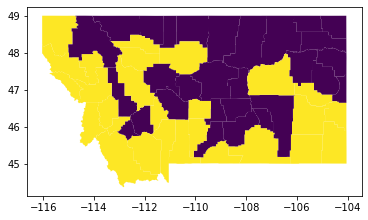

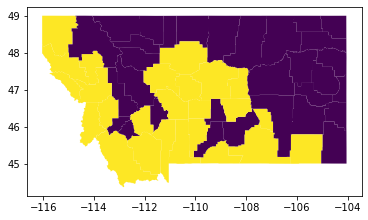

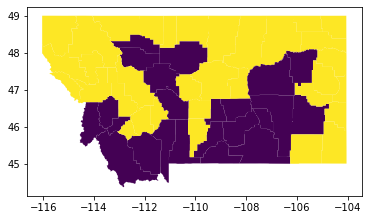

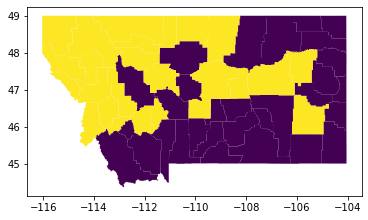

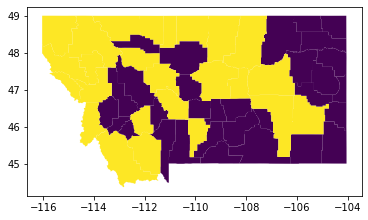

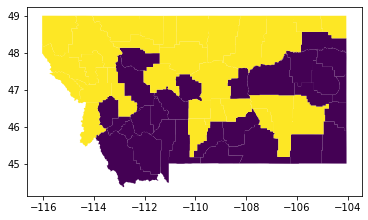

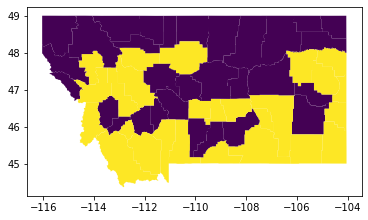

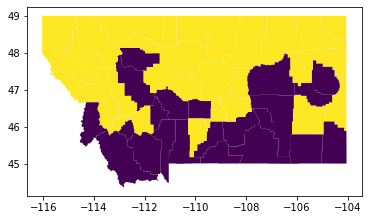

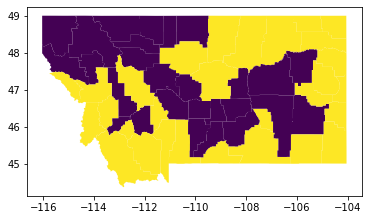

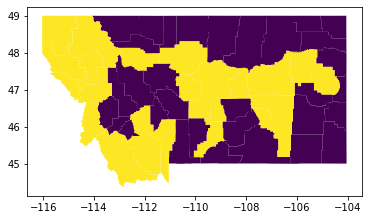

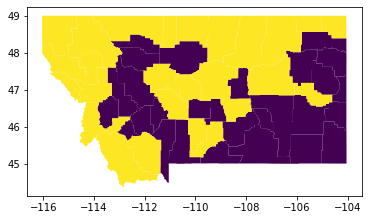

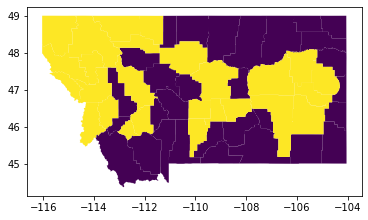

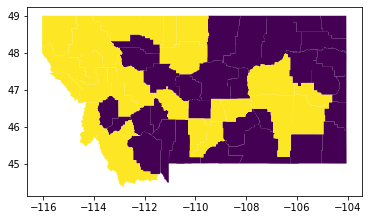

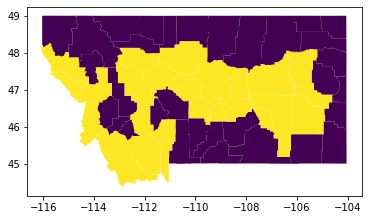

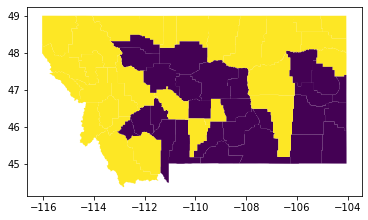

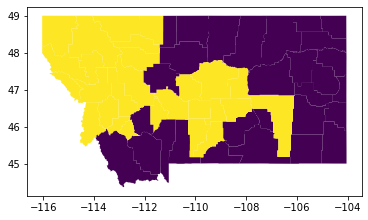

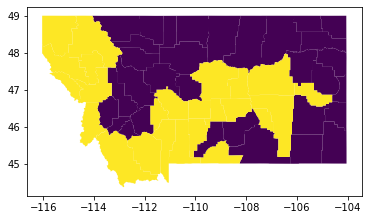

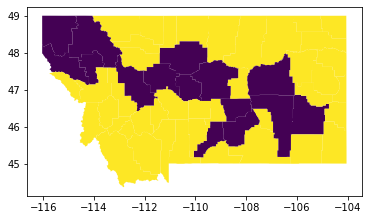

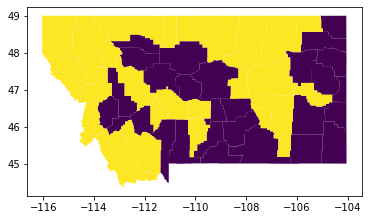

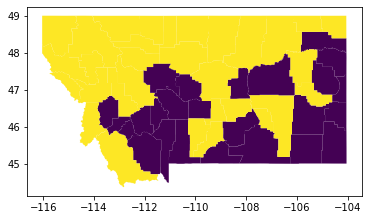

In [13]:
# Draw the districting plans.
# Limit of 20 images, due to large file size.

draw_limit = min( 20, m._number_of_districts )
filename = state + '_county.shp'

for p in range( draw_limit ):
    draw_single_district( filepath, filename, G, m._districts[p], zoom=False )
    #plt.figure()